### Import and init GPU

In [1]:
from IPython.display import Audio

In [2]:
import sys
sys.path.append('../../../')

In [3]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import tensorflow as tf

from tuner import HyperparameterTuner
from tuner import MyTask

use_tpu = False
use_gpu = True

if use_tpu:
    from tensorflow.contrib import tpu
    from tensorflow.contrib.cluster_resolver import TPUClusterResolver

if use_gpu:
    import os
    
%load_ext autoreload
%autoreload 2

In [4]:
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

In [5]:
if use_tpu:
    tpu_cluster = TPUClusterResolver(tpu=[tpu_name]).get_master()
    sess = tf.Session(tpu_cluster)
    sess.run(tpu.initialize_system())
elif use_gpu:
    sess = tf.Session(config=config)
else:
    sess = tf.Session()

In [6]:
from resnet import Network

In [7]:
network = Network()

In [8]:
task_home = ''
if use_tpu:
    pass
#     task_home = 'gs://continual_learning/permMNIST_EWC/'
else:
    task_home = '../../../../'

cur_dir = './'
checkpoint_path = cur_dir + 'checkpoints_2_0/'
summaries_path = cur_dir + 'summaries_2_0/'
data_path = task_home + 'cifar-100-python/'
split_path = './split.txt' 
if use_tpu:
    tpu_name = 'gectpu'
    
BATCH_SIZE = 128

### Dataset loading functions

In [9]:
label_smooth_param = 0

def splitDataset(dataset, dataset_split, seed):
    np.random.seed(seed)
    task_list = []
    train_labels = np.argmax(dataset.train.labels, axis=1)
    validation_labels = np.argmax(dataset.validation.labels, axis=1)
    test_labels = np.argmax(dataset.test.labels, axis=1)
    for i in range(len(dataset_split)):
        cur_train_indices = [False] * dataset.train.images.shape[0]
        cur_validation_indices = [False] * dataset.validation.images.shape[0]
        cur_test_indices = [False] * dataset.test.images.shape[0]
        for j in range(len(dataset_split[i])):
            cur_train_indices = np.logical_or(cur_train_indices, (train_labels == dataset_split[i][j]))
            cur_validation_indices = np.logical_or(cur_validation_indices, (validation_labels == dataset_split[i][j]))
            cur_test_indices = np.logical_or(cur_test_indices, (test_labels == dataset_split[i][j]))

        task = deepcopy(dataset)
        task.train.images = task.train.images[cur_train_indices]
        task.train.labels = task.train.labels[cur_train_indices]
        task.validation.images = task.validation.images[cur_validation_indices]
        task.validation.labels = task.validation.labels[cur_validation_indices]
        task.test.images = task.test.images[cur_test_indices]
        task.test.labels = task.test.labels[cur_test_indices]
        task = MyTask(task)
        task_list.append(task)

    return task_list
    
def smoothLabels(dataset):
    train_labels = dataset.train.labels
    train_labels_argmax = np.argmax(train_labels, axis=1)
    train_labels = train_labels + label_smooth_param / (train_labels.shape[1] - 1)
    train_labels[range(train_labels.shape[0]), train_labels_argmax] = 1 - label_smooth_param
    dataset.train._labels = train_labels

class TempDataset(object):
    def __init__(self):
        self.images = None
        self.labels = None
    
class TempTask(object):
    def __init__(self):
        self.train = TempDataset()
        self.validation = TempDataset()
        self.test = TempDataset()
    
    
def readDatasets():
    num_class = 100
    class_per_task = 2
    k = 0
    labels_list = list(range(num_class))
    seed = 0
    np.random.seed(seed)
    np.random.shuffle(labels_list)
    split = []
    task_weights = []
    while (k < num_class):
        split.append(labels_list[k : k + class_per_task])
        task_weights.append(class_per_task / num_class)
        k += class_per_task
        
    num_tasks = len(split)
    
    with open(data_path + 'train', 'rb') as f:
        f_train_data = pickle.load(f, encoding='bytes')
        
    with open(data_path + 'test', 'rb') as f:
        f_test_data = pickle.load(f, encoding='bytes')
        
    cifar_100 = TempTask()
    temp_train_labels = np.array(f_train_data[b'fine_labels'], dtype=np.int32)
    temp_test_labels = np.array(f_test_data[b'fine_labels'], dtype=np.int32)
    f_train_data[b'fine_labels'] = np.zeros((temp_train_labels.shape[0], num_class))
    (f_train_data[b'fine_labels'])[range(temp_train_labels.shape[0]), temp_train_labels] = 1
    f_test_data[b'fine_labels'] = np.zeros((temp_test_labels.shape[0], num_class))
    (f_test_data[b'fine_labels'])[range(temp_test_labels.shape[0]), temp_test_labels] = 1
    f_train_data[b'data'] = np.reshape(f_train_data[b'data'], (-1, 3, 32, 32))
    f_test_data[b'data'] = np.reshape(f_test_data[b'data'], (-1, 3, 32, 32))
    f_train_data[b'data'] = np.transpose(f_train_data[b'data'], (0, 2, 3, 1))
    f_test_data[b'data'] = np.transpose(f_test_data[b'data'], (0, 2, 3, 1))
    
    tr_data = f_train_data[b'data']
    te_data = f_test_data[b'data']
    # normalizing data
    avg = np.mean(tr_data, axis=(0, 1, 2))
    std = np.std(tr_data, axis=(0, 1, 2))
    
    f_train_data[b'data'] = (tr_data - avg) / std
    f_test_data[b'data'] = (te_data - avg) / std
    
    seed = 0
    np.random.seed(0)
    shuffle_train_perm = np.random.permutation(f_train_data[b'data'].shape[0])
    f_train_data[b'data'] = f_train_data[b'data'][shuffle_train_perm]
    f_train_data[b'fine_labels'] = f_train_data[b'fine_labels'][shuffle_train_perm]
    
    num_val_per_class = 20
    
    for i in range(num_class):
        pos = (np.argmax(f_train_data[b'fine_labels'], axis=1) == i)
        
        if (i == 0):
            cifar_100.validation.images = (f_train_data[b'data'][pos])[0 : num_val_per_class]
            cifar_100.validation.labels = (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]

            cifar_100.train.images = (f_train_data[b'data'][pos])[num_val_per_class : ]
            cifar_100.train.labels = (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]
        else:
            cifar_100.validation.images = np.concatenate((cifar_100.validation.images, (f_train_data[b'data'][pos])[0 : num_val_per_class]))
            cifar_100.validation.labels = np.concatenate((cifar_100.validation.labels, (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]))

            cifar_100.train.images = np.concatenate((cifar_100.train.images, (f_train_data[b'data'][pos])[num_val_per_class : ]))
            cifar_100.train.labels = np.concatenate((cifar_100.train.labels, (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]))
        
    cifar_100.test.images = f_test_data[b'data']
    cifar_100.test.labels = f_test_data[b'fine_labels']
    
    shuffle_train_perm = np.random.permutation(cifar_100.train.images.shape[0])
    cifar_100.train.images = cifar_100.train.images[shuffle_train_perm]
    cifar_100.train.labels = cifar_100.train.labels[shuffle_train_perm]
    
    if (label_smooth_param != 0):
        smoothLabels(cifar_100)
        
    task_list = splitDataset(cifar_100, split, seed)
    return split, num_tasks, task_weights, task_list

### Create tuner object and train!!

In [10]:
input_shape = (32, 32, 3)
output_shape = (100, )

In [11]:
tuner = HyperparameterTuner(sess=sess, network=network, 
                            input_shape=input_shape, output_shape=output_shape,
                            checkpoint_path=checkpoint_path, summaries_path=summaries_path, 
                            readDatasets=readDatasets, load_best_hparams=False)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [12]:
tuner.setPerExampleAppend(1.0)
tuner.updateTunerHparams({'mask_softmax' : True})

### Training each task separately

In [ ]:
t = 0
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 128
print(tuner.validationAccuracy(t, VALIDATION_BATCH_SIZE, restore_model=False))

In [ ]:
t = 1
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

### Train tasks together

In [13]:
t = 49
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)
    
for i in range(0, t + 1):
    tuner.hparams_list[i] = hparams
    

In [14]:
num_hparams = len(hparams)
num_epochs = 70
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 100

In [15]:
best_avg, best_hparams_index = tuner.tuneTasksInRange(0, t, BATCH_SIZE, num_hparams, 
                                                        num_updates=num_updates, verbose=True, 
                                                        random_crop_flip=True, 
                                                        equal_weights=True)

Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0
epoch: 1, iter: 0/8, validation accuracies: [0.5], average train loss: 1.245663, average train accuracy: 0.594727
epoch: 2, iter: 0/8, validation accuracies: [0.52499998], average train loss: 0.929772, average train accuracy: 0.629883
epoch: 3, iter: 0/8, validation accuracies: [0.75], average train loss: 0.657003, average train accuracy: 0.739258
epoch: 4, iter: 0/8, validation accuracies: [0.67500001], average train loss: 0.544812, average train accuracy: 0.769531
epoch: 5, iter: 0/8, validation accuracies: [0.75], average train loss: 0.468163, average train accuracy: 0.787109
epoch: 6, iter: 0/8, validation accuracies: [0.72500002], average train loss: 0.490762, average train accuracy: 0.790039
epoch: 7, iter: 0/8, validation accuracies: [0.82499999], average train loss: 0.475729, average train accuracy: 0.792969
epoch: 8, 

epoch: 66, iter: 0/8, validation accuracies: [0.85000002], average train loss: 0.114772, average train accuracy: 0.957031
epoch: 67, iter: 0/8, validation accuracies: [0.875], average train loss: 0.129407, average train accuracy: 0.954102
epoch: 68, iter: 0/8, validation accuracies: [0.875], average train loss: 0.113573, average train accuracy: 0.959961
epoch: 69, iter: 0/8, validation accuracies: [0.85000002], average train loss: 0.101148, average train accuracy: 0.964844
epoch: 70, iter: 0/8, validation accuracies: [0.82499999], average train loss: 0.102716, average train accuracy: 0.960938
epochs: 70.000000, final train loss: 0.096147, validation accuracies: [0.82499999]
best epochs: 22.000000, best_avg: 0.925000, validation accuracies: [0.92500001]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0 at time step 560
calculating penultimate output...
time taken: %f 0.45297980308532715
saving penul

epoch: 51, iter: 0/8, validation accuracies: [0.77499998 0.67500001], average train loss: 0.523730, average train accuracy: 0.795898
epoch: 52, iter: 0/8, validation accuracies: [0.80000001 0.72500002], average train loss: 0.481060, average train accuracy: 0.821289
epoch: 53, iter: 0/8, validation accuracies: [0.69999999 0.80000001], average train loss: 0.515480, average train accuracy: 0.800781
epoch: 54, iter: 0/8, validation accuracies: [0.77499998 0.80000001], average train loss: 0.452556, average train accuracy: 0.828125
epoch: 55, iter: 0/8, validation accuracies: [0.82499999 0.72500002], average train loss: 0.434099, average train accuracy: 0.834961
epoch: 56, iter: 0/8, validation accuracies: [0.77499998 0.67500001], average train loss: 0.453572, average train accuracy: 0.833008
epoch: 57, iter: 0/8, validation accuracies: [0.77499998 0.77499998], average train loss: 0.482752, average train accuracy: 0.820312
epoch: 58, iter: 0/8, validation accuracies: [0.77499998 0.72500002],

epoch: 32, iter: 0/8, validation accuracies: [0.82499999 0.5        0.67500001], average train loss: 0.691939, average train accuracy: 0.750977
epoch: 33, iter: 0/8, validation accuracies: [0.75       0.77499998 0.77499998], average train loss: 0.633180, average train accuracy: 0.776367
epoch: 34, iter: 0/8, validation accuracies: [0.80000001 0.72500002 0.5       ], average train loss: 0.660525, average train accuracy: 0.766602
epoch: 35, iter: 0/8, validation accuracies: [0.72500002 0.625      0.75      ], average train loss: 0.559550, average train accuracy: 0.794922
epoch: 36, iter: 0/8, validation accuracies: [0.77499998 0.77499998 0.72500002], average train loss: 0.582335, average train accuracy: 0.794922
epoch: 37, iter: 0/8, validation accuracies: [0.72500002 0.69999999 0.77499998], average train loss: 0.598484, average train accuracy: 0.781250
epoch: 37, iter: 4/8, loss: 0.616186, accuracy: 0.765625
epoch: 38, iter: 0/8, validation accuracies: [0.80000001 0.80000001 0.77499998]

epoch: 11, iter: 0/8, validation accuracies: [0.77499998 0.47499999 0.40000001 0.44999999], average train loss: 1.044926, average train accuracy: 0.626953
epoch: 12, iter: 0/8, validation accuracies: [0.60000002 0.69999999 0.64999998 0.67500001], average train loss: 1.027618, average train accuracy: 0.621094
epoch: 12, iter: 4/8, loss: 1.001493, accuracy: 0.679688
epoch: 13, iter: 0/8, validation accuracies: [0.69999999 0.67500001 0.55000001 0.67500001], average train loss: 0.954371, average train accuracy: 0.664062
epoch: 14, iter: 0/8, validation accuracies: [0.60000002 0.625      0.5        0.52499998], average train loss: 0.958479, average train accuracy: 0.663086
epoch: 15, iter: 0/8, validation accuracies: [0.60000002 0.64999998 0.52499998 0.69999999], average train loss: 0.938749, average train accuracy: 0.663086
epoch: 16, iter: 0/8, validation accuracies: [0.64999998 0.55000001 0.625      0.52499998], average train loss: 0.906326, average train accuracy: 0.691406
epoch: 17, it

epoch: 63, iter: 0/8, validation accuracies: [0.80000001 0.69999999 0.72500002 0.72500002], average train loss: 0.413278, average train accuracy: 0.866211
epoch: 64, iter: 0/8, validation accuracies: [0.85000002 0.72500002 0.77499998 0.72500002], average train loss: 0.432687, average train accuracy: 0.854492
epoch: 65, iter: 0/8, validation accuracies: [0.85000002 0.72500002 0.77499998 0.72500002], average train loss: 0.420672, average train accuracy: 0.859375
epoch: 66, iter: 0/8, validation accuracies: [0.82499999 0.72500002 0.77499998 0.72500002], average train loss: 0.388831, average train accuracy: 0.867188
epoch: 67, iter: 0/8, validation accuracies: [0.82499999 0.75       0.77499998 0.72500002], average train loss: 0.432343, average train accuracy: 0.845703
epoch: 68, iter: 0/8, validation accuracies: [0.82499999 0.75       0.75       0.72500002], average train loss: 0.382384, average train accuracy: 0.870117
epoch: 69, iter: 0/8, validation accuracies: [0.82499999 0.75       0.

epoch: 37, iter: 0/8, validation accuracies: [0.64999998 0.80000001 0.47499999 0.5        0.64999998], average train loss: 0.722204, average train accuracy: 0.733398
epoch: 37, iter: 4/8, loss: 0.733931, accuracy: 0.742188
epoch: 38, iter: 0/8, validation accuracies: [0.82499999 0.60000002 0.72500002 0.64999998 0.69999999], average train loss: 0.642785, average train accuracy: 0.773438
epoch: 39, iter: 0/8, validation accuracies: [0.47499999 0.52499998 0.60000002 0.67500001 0.80000001], average train loss: 0.689438, average train accuracy: 0.753906
epoch: 40, iter: 0/8, validation accuracies: [0.89999998 0.375      0.69999999 0.5        0.69999999], average train loss: 0.709352, average train accuracy: 0.754883
epoch: 41, iter: 0/8, validation accuracies: [0.72500002 0.5        0.69999999 0.64999998 0.75      ], average train loss: 0.604841, average train accuracy: 0.777344
epoch: 42, iter: 0/8, validation accuracies: [0.75       0.64999998 0.69999999 0.60000002 0.69999999], average tr

epoch: 9, iter: 0/8, validation accuracies: [0.69999999 0.32499999 0.44999999 0.57499999 0.40000001 0.77499998], average train loss: 1.042895, average train accuracy: 0.633789
epoch: 10, iter: 0/8, validation accuracies: [0.72500002 0.52499998 0.44999999 0.30000001 0.69999999 0.64999998], average train loss: 1.010095, average train accuracy: 0.635742
epoch: 11, iter: 0/8, validation accuracies: [0.625      0.52499998 0.34999999 0.75       0.47499999 0.69999999], average train loss: 0.990668, average train accuracy: 0.652344
epoch: 12, iter: 0/8, validation accuracies: [0.64999998 0.52499998 0.52499998 0.67500001 0.64999998 0.69999999], average train loss: 1.008842, average train accuracy: 0.647461
epoch: 12, iter: 4/8, loss: 1.000390, accuracy: 0.601562
epoch: 13, iter: 0/8, validation accuracies: [0.60000002 0.375      0.27500001 0.75       0.55000001 0.69999999], average train loss: 0.926610, average train accuracy: 0.670898
epoch: 14, iter: 0/8, validation accuracies: [0.60000002 0.

epoch: 55, iter: 0/8, validation accuracies: [0.82499999 0.55000001 0.75       0.72500002 0.875      0.69999999], average train loss: 0.469497, average train accuracy: 0.841797
epoch: 56, iter: 0/8, validation accuracies: [0.82499999 0.625      0.75       0.69999999 0.72500002 0.75      ], average train loss: 0.482729, average train accuracy: 0.824219
epoch: 57, iter: 0/8, validation accuracies: [0.82499999 0.67500001 0.75       0.67500001 0.69999999 0.75      ], average train loss: 0.467238, average train accuracy: 0.846680
epoch: 58, iter: 0/8, validation accuracies: [0.85000002 0.67500001 0.69999999 0.69999999 0.69999999 0.75      ], average train loss: 0.427534, average train accuracy: 0.864258
epoch: 59, iter: 0/8, validation accuracies: [0.80000001 0.72500002 0.72500002 0.67500001 0.77499998 0.77499998], average train loss: 0.462495, average train accuracy: 0.842773
epoch: 60, iter: 0/8, validation accuracies: [0.80000001 0.60000002 0.75       0.625      0.80000001 0.72500002], a

epoch: 24, iter: 0/8, validation accuracies: [0.64999998 0.15000001 0.47499999 0.625      0.55000001 0.55000001
 0.72500002], average train loss: 0.906091, average train accuracy: 0.688477
epoch: 25, iter: 0/8, validation accuracies: [0.30000001 0.64999998 0.72500002 0.67500001 0.625      0.82499999
 0.34999999], average train loss: 0.881575, average train accuracy: 0.696289
epoch: 25, iter: 0/8, loss: 0.730147, accuracy: 0.742188
epoch: 26, iter: 0/8, validation accuracies: [0.60000002 0.67500001 0.375      0.60000002 0.5        0.72500002
 0.57499999], average train loss: 0.931322, average train accuracy: 0.690430
epoch: 27, iter: 0/8, validation accuracies: [0.5        0.625      0.57499999 0.64999998 0.72500002 0.80000001
 0.44999999], average train loss: 0.832855, average train accuracy: 0.708984
epoch: 28, iter: 0/8, validation accuracies: [0.60000002 0.625      0.40000001 0.5        0.69999999 0.625
 0.55000001], average train loss: 0.802580, average train accuracy: 0.722656
epo

epoch: 67, iter: 0/8, validation accuracies: [0.77499998 0.80000001 0.69999999 0.57499999 0.85000002 0.82499999
 0.67500001], average train loss: 0.455339, average train accuracy: 0.845703
epoch: 68, iter: 0/8, validation accuracies: [0.77499998 0.82499999 0.69999999 0.57499999 0.82499999 0.82499999
 0.67500001], average train loss: 0.530865, average train accuracy: 0.823242
epoch: 69, iter: 0/8, validation accuracies: [0.77499998 0.82499999 0.69999999 0.57499999 0.82499999 0.82499999
 0.67500001], average train loss: 0.458820, average train accuracy: 0.843750
epoch: 70, iter: 0/8, validation accuracies: [0.77499998 0.82499999 0.67500001 0.60000002 0.80000001 0.82499999
 0.67500001], average train loss: 0.451882, average train accuracy: 0.845703
epochs: 70.000000, final train loss: 0.350849, validation accuracies: [0.77499998 0.82499999 0.67500001 0.60000002 0.80000001 0.82499999
 0.67500001]
best epochs: 67.000000, best_avg: 0.742857, validation accuracies: [0.77499998 0.80000001 0.69

epoch: 33, iter: 0/8, validation accuracies: [0.52499998 0.55000001 0.57499999 0.625      0.64999998 0.80000001
 0.625      0.52499998], average train loss: 0.865270, average train accuracy: 0.707031
epoch: 34, iter: 0/8, validation accuracies: [0.55000001 0.60000002 0.47499999 0.625      0.52499998 0.72500002
 0.64999998 0.67500001], average train loss: 0.831645, average train accuracy: 0.716797
epoch: 35, iter: 0/8, validation accuracies: [0.55000001 0.57499999 0.625      0.44999999 0.55000001 0.72500002
 0.625      0.375     ], average train loss: 0.811491, average train accuracy: 0.741211
epoch: 36, iter: 0/8, validation accuracies: [0.60000002 0.42500001 0.42500001 0.64999998 0.60000002 0.64999998
 0.67500001 0.625     ], average train loss: 0.876359, average train accuracy: 0.701172
epoch: 37, iter: 0/8, validation accuracies: [0.60000002 0.5        0.625      0.55000001 0.77499998 0.67500001
 0.55000001 0.47499999], average train loss: 0.821805, average train accuracy: 0.720703


time taken: %f 0.6668717861175537
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=8
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=7
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=7.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.1        0.42500001 0.         0.42500001 0.175      0.075
 0.22499999 0.25       0.        ], average train loss: 3.739189, average train accuracy: 0.246094
epoch: 2, iter: 0/8, validation accuracies: [0.175      0.375      0.05       0.2        0.075      0.55000001
 0.075      0.22499999 0.125     ], average train loss: 2.301002, average train accuracy: 0.297852
epoch: 3, iter

epoch: 37, iter: 0/8, validation accuracies: [0.77499998 0.30000001 0.47499999 0.5        0.69999999 0.625
 0.42500001 0.42500001 0.67500001], average train loss: 0.844187, average train accuracy: 0.720703
epoch: 37, iter: 4/8, loss: 0.765002, accuracy: 0.742188
epoch: 38, iter: 0/8, validation accuracies: [0.67500001 0.40000001 0.57499999 0.64999998 0.5        0.60000002
 0.625      0.55000001 0.44999999], average train loss: 0.809229, average train accuracy: 0.717773
epoch: 39, iter: 0/8, validation accuracies: [0.60000002 0.42500001 0.64999998 0.47499999 0.57499999 0.44999999
 0.72500002 0.57499999 0.55000001], average train loss: 0.822630, average train accuracy: 0.722656
epoch: 40, iter: 0/8, validation accuracies: [0.57499999 0.60000002 0.55000001 0.69999999 0.57499999 0.72500002
 0.69999999 0.5        0.625     ], average train loss: 0.759241, average train accuracy: 0.741211
epoch: 41, iter: 0/8, validation accuracies: [0.32499999 0.625      0.52499998 0.625      0.75       0.7

epoch: 1, iter: 0/8, validation accuracies: [0.27500001 0.         0.025      0.1        0.32499999 0.05
 0.025      0.         0.32499999 0.        ], average train loss: 4.699020, average train accuracy: 0.145508
epoch: 2, iter: 0/8, validation accuracies: [0.57499999 0.025      0.125      0.22499999 0.075      0.15000001
 0.05       0.15000001 0.32499999 0.025     ], average train loss: 2.544329, average train accuracy: 0.228516
epoch: 3, iter: 0/8, validation accuracies: [0.34999999 0.         0.55000001 0.075      0.         0.375
 0.32499999 0.22499999 0.75       0.175     ], average train loss: 2.286965, average train accuracy: 0.309570
epoch: 4, iter: 0/8, validation accuracies: [0.55000001 0.05       0.375      0.27500001 0.15000001 0.52499998
 0.32499999 0.34999999 0.67500001 0.375     ], average train loss: 2.071694, average train accuracy: 0.379883
epoch: 5, iter: 0/8, validation accuracies: [0.375      0.075      0.40000001 0.22499999 0.27500001 0.44999999
 0.34999999 0.34

epoch: 38, iter: 0/8, validation accuracies: [0.625      0.57499999 0.57499999 0.625      0.44999999 0.67500001
 0.625      0.57499999 0.69999999 0.77499998], average train loss: 0.790248, average train accuracy: 0.741211
epoch: 39, iter: 0/8, validation accuracies: [0.57499999 0.67500001 0.47499999 0.47499999 0.75       0.57499999
 0.625      0.34999999 0.69999999 0.625     ], average train loss: 0.835175, average train accuracy: 0.731445
epoch: 40, iter: 0/8, validation accuracies: [0.52499998 0.57499999 0.42500001 0.5        0.44999999 0.77499998
 0.64999998 0.625      0.69999999 0.64999998], average train loss: 0.853327, average train accuracy: 0.716797
epoch: 41, iter: 0/8, validation accuracies: [0.72500002 0.60000002 0.60000002 0.5        0.67500001 0.80000001
 0.60000002 0.32499999 0.77499998 0.55000001], average train loss: 0.803320, average train accuracy: 0.733398
epoch: 42, iter: 0/8, validation accuracies: [0.64999998 0.40000001 0.47499999 0.47499999 0.60000002 0.69999999


Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=9
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=9.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.175      0.1        0.72500002 0.1        0.44999999 0.
 0.1        0.1        0.15000001 0.         0.15000001], average train loss: 3.345593, average train accuracy: 0.386719
epoch: 2, iter: 0/8, validation accuracies: [0.44999999 0.15000001 0.30000001 0.375      0.67500001 0.175
 0.32499999 0.125      0.625      0.25       0.1       ], average train loss: 2.102419, average train accuracy: 0.360352
epoch: 3, iter: 0/8, validation accuracies: [0.60000002 0.40000001 0.85000002 0.60000002 0.40000001 0.1
 0.34999999 0.075      0.57499999 0.25       0.075     ], average train loss: 1.853057, average tra

epoch: 35, iter: 0/8, validation accuracies: [0.67500001 0.625      0.64999998 0.67500001 0.67500001 0.625
 0.69999999 0.47499999 0.60000002 0.67500001 0.57499999], average train loss: 0.758505, average train accuracy: 0.747070
epoch: 36, iter: 0/8, validation accuracies: [0.67500001 0.625      0.57499999 0.47499999 0.72500002 0.60000002
 0.47499999 0.44999999 0.69999999 0.77499998 0.47499999], average train loss: 0.802818, average train accuracy: 0.742188
epoch: 37, iter: 0/8, validation accuracies: [0.64999998 0.52499998 0.67500001 0.60000002 0.69999999 0.47499999
 0.47499999 0.57499999 0.69999999 0.60000002 0.77499998], average train loss: 0.845458, average train accuracy: 0.708008
epoch: 37, iter: 4/8, loss: 0.695743, accuracy: 0.750000
epoch: 38, iter: 0/8, validation accuracies: [0.60000002 0.52499998 0.55000001 0.64999998 0.75       0.72500002
 0.64999998 0.52499998 0.625      0.69999999 0.60000002], average train loss: 0.762925, average train accuracy: 0.748047
epoch: 39, iter:

epoch: 70, iter: 0/8, validation accuracies: [0.72500002 0.77499998 0.72500002 0.625      0.77499998 0.64999998
 0.64999998 0.47499999 0.75       0.77499998 0.72500002], average train loss: 0.504893, average train accuracy: 0.844727
epochs: 70.000000, final train loss: 0.405656, validation accuracies: [0.72500002 0.77499998 0.72500002 0.625      0.77499998 0.64999998
 0.64999998 0.47499999 0.75       0.77499998 0.72500002]
best epochs: 66.000000, best_avg: 0.697727, validation accuracies: [0.69999999 0.75       0.72500002 0.67500001 0.82499999 0.64999998
 0.60000002 0.5        0.72500002 0.77499998 0.75      ]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10 at time step 560
calculating penultimate output...
time taken: %f 0.8210873603820801
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mas

epoch: 29, iter: 0/8, validation accuracies: [0.77499998 0.47499999 0.52499998 0.52499998 0.625      0.47499999
 0.67500001 0.34999999 0.64999998 0.42500001 0.69999999 0.52499998], average train loss: 0.903356, average train accuracy: 0.693359
epoch: 30, iter: 0/8, validation accuracies: [0.64999998 0.40000001 0.40000001 0.40000001 0.34999999 0.67500001
 0.52499998 0.625      0.77499998 0.77499998 0.64999998 0.57499999], average train loss: 0.974138, average train accuracy: 0.685547
epoch: 31, iter: 0/8, validation accuracies: [0.60000002 0.52499998 0.40000001 0.47499999 0.57499999 0.55000001
 0.55000001 0.42500001 0.625      0.82499999 0.42500001 0.60000002], average train loss: 0.935072, average train accuracy: 0.688477
epoch: 32, iter: 0/8, validation accuracies: [0.55000001 0.42500001 0.60000002 0.625      0.34999999 0.75
 0.57499999 0.625      0.52499998 0.67500001 0.625      0.75      ], average train loss: 0.877928, average train accuracy: 0.708008
epoch: 33, iter: 0/8, validati

epoch: 63, iter: 0/8, validation accuracies: [0.69999999 0.57499999 0.625      0.60000002 0.72500002 0.60000002
 0.67500001 0.47499999 0.80000001 0.75       0.75       0.67500001], average train loss: 0.726949, average train accuracy: 0.757812
epoch: 64, iter: 0/8, validation accuracies: [0.69999999 0.57499999 0.625      0.57499999 0.75       0.60000002
 0.64999998 0.47499999 0.80000001 0.77499998 0.75       0.69999999], average train loss: 0.607774, average train accuracy: 0.807617
epoch: 65, iter: 0/8, validation accuracies: [0.72500002 0.55000001 0.625      0.60000002 0.75       0.60000002
 0.67500001 0.55000001 0.77499998 0.80000001 0.82499999 0.72500002], average train loss: 0.637316, average train accuracy: 0.794922
epoch: 66, iter: 0/8, validation accuracies: [0.72500002 0.57499999 0.64999998 0.60000002 0.75       0.69999999
 0.67500001 0.52499998 0.80000001 0.80000001 0.82499999 0.72500002], average train loss: 0.635309, average train accuracy: 0.790039
epoch: 67, iter: 0/8, va

epoch: 21, iter: 0/8, validation accuracies: [0.44999999 0.47499999 0.52499998 0.47499999 0.67500001 0.60000002
 0.625      0.5        0.52499998 0.57499999 0.80000001 0.72500002
 0.57499999], average train loss: 0.939434, average train accuracy: 0.694336
epoch: 22, iter: 0/8, validation accuracies: [0.80000001 0.47499999 0.67500001 0.5        0.80000001 0.67500001
 0.47499999 0.40000001 0.64999998 0.40000001 0.69999999 0.55000001
 0.60000002], average train loss: 0.912294, average train accuracy: 0.703125
epoch: 23, iter: 0/8, validation accuracies: [0.44999999 0.375      0.47499999 0.69999999 0.64999998 0.80000001
 0.72500002 0.52499998 0.5        0.625      0.52499998 0.67500001
 0.375     ], average train loss: 0.881694, average train accuracy: 0.704102
epoch: 24, iter: 0/8, validation accuracies: [0.5        0.55000001 0.57499999 0.60000002 0.80000001 0.69999999
 0.57499999 0.55000001 0.64999998 0.57499999 0.57499999 0.57499999
 0.60000002], average train loss: 0.842065, average t

epoch: 53, iter: 0/8, validation accuracies: [0.67500001 0.52499998 0.625      0.64999998 0.72500002 0.69999999
 0.67500001 0.60000002 0.77499998 0.69999999 0.82499999 0.64999998
 0.67500001], average train loss: 0.680813, average train accuracy: 0.767578
epoch: 54, iter: 0/8, validation accuracies: [0.625      0.57499999 0.625      0.67500001 0.69999999 0.67500001
 0.72500002 0.625      0.77499998 0.69999999 0.85000002 0.64999998
 0.60000002], average train loss: 0.683479, average train accuracy: 0.791016
epoch: 55, iter: 0/8, validation accuracies: [0.64999998 0.625      0.64999998 0.57499999 0.72500002 0.67500001
 0.69999999 0.67500001 0.69999999 0.57499999 0.82499999 0.625
 0.69999999], average train loss: 0.593691, average train accuracy: 0.814453
epoch: 56, iter: 0/8, validation accuracies: [0.67500001 0.625      0.52499998 0.57499999 0.77499998 0.69999999
 0.67500001 0.52499998 0.69999999 0.57499999 0.75       0.64999998
 0.72500002], average train loss: 0.591522, average train 

epoch: 11, iter: 0/8, validation accuracies: [0.57499999 0.27500001 0.44999999 0.15000001 0.60000002 0.69999999
 0.40000001 0.27500001 0.52499998 0.47499999 0.57499999 0.625
 0.60000002 0.34999999], average train loss: 1.429069, average train accuracy: 0.553711
epoch: 12, iter: 0/8, validation accuracies: [0.57499999 0.42500001 0.57499999 0.55000001 0.60000002 0.44999999
 0.2        0.47499999 0.72500002 0.67500001 0.67500001 0.5
 0.40000001 0.375     ], average train loss: 1.544139, average train accuracy: 0.526367
epoch: 12, iter: 4/8, loss: 1.461137, accuracy: 0.609375
epoch: 13, iter: 0/8, validation accuracies: [0.60000002 0.40000001 0.075      0.47499999 0.42500001 0.40000001
 0.375      0.5        0.75       0.67500001 0.72500002 0.60000002
 0.34999999 0.34999999], average train loss: 1.361637, average train accuracy: 0.599609
epoch: 14, iter: 0/8, validation accuracies: [0.67500001 0.52499998 0.44999999 0.57499999 0.52499998 0.625
 0.40000001 0.32499999 0.55000001 0.44999999 0.

epoch: 42, iter: 0/8, validation accuracies: [0.67500001 0.52499998 0.44999999 0.60000002 0.5        0.75
 0.5        0.27500001 0.5        0.72500002 0.64999998 0.875
 0.60000002 0.44999999], average train loss: 0.902968, average train accuracy: 0.709961
epoch: 43, iter: 0/8, validation accuracies: [0.80000001 0.34999999 0.44999999 0.47499999 0.67500001 0.69999999
 0.57499999 0.42500001 0.72500002 0.5        0.57499999 0.64999998
 0.55000001 0.40000001], average train loss: 0.945582, average train accuracy: 0.705078
epoch: 44, iter: 0/8, validation accuracies: [0.42500001 0.625      0.64999998 0.64999998 0.52499998 0.40000001
 0.5        0.40000001 0.55000001 0.57499999 0.52499998 0.57499999
 0.5        0.55000001], average train loss: 0.990447, average train accuracy: 0.696289
epoch: 45, iter: 0/8, validation accuracies: [0.77499998 0.52499998 0.55000001 0.64999998 0.5        0.5
 0.60000002 0.42500001 0.67500001 0.64999998 0.72500002 0.72500002
 0.64999998 0.57499999], average train

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=13 at time step 560
calculating penultimate output...
time taken: %f 1.1237664222717285
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=14
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=13
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=13.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.32499999 0.44999999 0.72500002 0.42500001 0.55000001 0.375
 0.175      0.75       0.75       0.52499998 0.60000002 0.
 0.025      0.         0.27500001], average train loss: 2.059458, aver

epoch: 28, iter: 0/8, validation accuracies: [0.64999998 0.57499999 0.55000001 0.55000001 0.67500001 0.625
 0.52499998 0.44999999 0.67500001 0.72500002 0.80000001 0.82499999
 0.625      0.52499998 0.875     ], average train loss: 0.956816, average train accuracy: 0.693359
epoch: 29, iter: 0/8, validation accuracies: [0.625      0.5        0.52499998 0.64999998 0.69999999 0.82499999
 0.625      0.55000001 0.67500001 0.72500002 0.64999998 0.64999998
 0.52499998 0.57499999 0.72500002], average train loss: 0.855361, average train accuracy: 0.740234
epoch: 30, iter: 0/8, validation accuracies: [0.64999998 0.55000001 0.52499998 0.52499998 0.57499999 0.64999998
 0.69999999 0.60000002 0.57499999 0.55000001 0.77499998 0.80000001
 0.60000002 0.52499998 0.67500001], average train loss: 0.761395, average train accuracy: 0.753906
epoch: 31, iter: 0/8, validation accuracies: [0.55000001 0.64999998 0.52499998 0.57499999 0.57499999 0.69999999
 0.67500001 0.375      0.64999998 0.60000002 0.67500001 0.6

epoch: 58, iter: 0/8, validation accuracies: [0.69999999 0.72500002 0.60000002 0.60000002 0.72500002 0.69999999
 0.64999998 0.5        0.72500002 0.72500002 0.75       0.64999998
 0.75       0.69999999 0.85000002], average train loss: 0.666347, average train accuracy: 0.796875
epoch: 59, iter: 0/8, validation accuracies: [0.67500001 0.69999999 0.57499999 0.64999998 0.72500002 0.75
 0.64999998 0.40000001 0.72500002 0.67500001 0.75       0.69999999
 0.75       0.64999998 0.77499998], average train loss: 0.658489, average train accuracy: 0.777344
epoch: 60, iter: 0/8, validation accuracies: [0.67500001 0.625      0.57499999 0.60000002 0.77499998 0.67500001
 0.625      0.42500001 0.75       0.75       0.75       0.75
 0.77499998 0.64999998 0.77499998], average train loss: 0.598578, average train accuracy: 0.815430
epoch: 61, iter: 0/8, validation accuracies: [0.67500001 0.67500001 0.5        0.60000002 0.75       0.72500002
 0.60000002 0.44999999 0.72500002 0.75       0.77499998 0.75
 0.80

epoch: 12, iter: 4/8, loss: 0.929643, accuracy: 0.710938
epoch: 13, iter: 0/8, validation accuracies: [0.72500002 0.32499999 0.75       0.52499998 0.80000001 0.64999998
 0.60000002 0.42500001 0.57499999 0.55000001 0.55000001 0.67500001
 0.57499999 0.55000001 0.67500001 0.5       ], average train loss: 0.926622, average train accuracy: 0.706055
epoch: 14, iter: 0/8, validation accuracies: [0.80000001 0.69999999 0.5        0.55000001 0.80000001 0.72500002
 0.47499999 0.40000001 0.64999998 0.67500001 0.57499999 0.625
 0.5        0.40000001 0.77499998 0.44999999], average train loss: 0.938833, average train accuracy: 0.686523
epoch: 15, iter: 0/8, validation accuracies: [0.72500002 0.47499999 0.42500001 0.55000001 0.57499999 0.5
 0.5        0.55000001 0.72500002 0.42500001 0.64999998 0.80000001
 0.67500001 0.60000002 0.77499998 0.44999999], average train loss: 1.013463, average train accuracy: 0.674805
epoch: 16, iter: 0/8, validation accuracies: [0.57499999 0.47499999 0.52499998 0.5      

epoch: 42, iter: 0/8, validation accuracies: [0.67500001 0.55000001 0.42500001 0.55000001 0.72500002 0.60000002
 0.55000001 0.44999999 0.625      0.42500001 0.75       0.60000002
 0.52499998 0.67500001 0.55000001 0.64999998], average train loss: 0.852673, average train accuracy: 0.729492
epoch: 43, iter: 0/8, validation accuracies: [0.64999998 0.52499998 0.64999998 0.47499999 0.72500002 0.5
 0.64999998 0.44999999 0.55000001 0.57499999 0.77499998 0.64999998
 0.625      0.80000001 0.80000001 0.55000001], average train loss: 0.870404, average train accuracy: 0.717773
epoch: 44, iter: 0/8, validation accuracies: [0.69999999 0.69999999 0.57499999 0.34999999 0.72500002 0.625
 0.57499999 0.42500001 0.77499998 0.57499999 0.60000002 0.47499999
 0.60000002 0.72500002 0.82499999 0.64999998], average train loss: 0.847323, average train accuracy: 0.724609
epoch: 45, iter: 0/8, validation accuracies: [0.52499998 0.52499998 0.40000001 0.57499999 0.52499998 0.60000002
 0.60000002 0.42500001 0.55000001

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=15 at time step 560
calculating penultimate output...
time taken: %f 1.332185983657837
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=16
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=15
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=15.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.52499998 0.52499998 0.69999999 0.40000001 0.57499999 0.15000001
 0.5        0.30000001 0.875      0.52499998 0.         0.
 0.         0.         0.075      0.1        0.125     ], average 

epoch: 26, iter: 0/8, validation accuracies: [0.47499999 0.47499999 0.52499998 0.67500001 0.77499998 0.34999999
 0.5        0.52499998 0.72500002 0.52499998 0.72500002 0.60000002
 0.47499999 0.52499998 0.89999998 0.57499999 0.52499998], average train loss: 0.944019, average train accuracy: 0.694336
epoch: 27, iter: 0/8, validation accuracies: [0.64999998 0.32499999 0.60000002 0.47499999 0.625      0.67500001
 0.5        0.5        0.75       0.55000001 0.60000002 0.40000001
 0.625      0.625      0.72500002 0.42500001 0.72500002], average train loss: 0.816046, average train accuracy: 0.738281
epoch: 28, iter: 0/8, validation accuracies: [0.64999998 0.5        0.625      0.55000001 0.60000002 0.625
 0.69999999 0.40000001 0.625      0.64999998 0.72500002 0.44999999
 0.72500002 0.60000002 0.60000002 0.57499999 0.75      ], average train loss: 0.808639, average train accuracy: 0.738281
epoch: 29, iter: 0/8, validation accuracies: [0.64999998 0.42500001 0.375      0.52499998 0.5        0.75

epoch: 54, iter: 0/8, validation accuracies: [0.69999999 0.5        0.52499998 0.52499998 0.67500001 0.69999999
 0.67500001 0.60000002 0.69999999 0.77499998 0.77499998 0.77499998
 0.75       0.72500002 0.85000002 0.64999998 0.77499998], average train loss: 0.698535, average train accuracy: 0.775391
epoch: 55, iter: 0/8, validation accuracies: [0.72500002 0.5        0.57499999 0.625      0.64999998 0.69999999
 0.625      0.60000002 0.69999999 0.75       0.80000001 0.77499998
 0.69999999 0.69999999 0.875      0.55000001 0.77499998], average train loss: 0.682503, average train accuracy: 0.768555
epoch: 56, iter: 0/8, validation accuracies: [0.75       0.52499998 0.625      0.625      0.69999999 0.64999998
 0.67500001 0.5        0.72500002 0.69999999 0.80000001 0.72500002
 0.77499998 0.69999999 0.875      0.52499998 0.75      ], average train loss: 0.635927, average train accuracy: 0.790039
epoch: 57, iter: 0/8, validation accuracies: [0.75       0.55000001 0.64999998 0.60000002 0.69999999

epoch: 7, iter: 0/8, validation accuracies: [0.57499999 0.52499998 0.52499998 0.57499999 0.52499998 0.42500001
 0.47499999 0.60000002 0.47499999 0.5        0.34999999 0.44999999
 0.22499999 0.47499999 0.72500002 0.44999999 0.57499999 0.075     ], average train loss: 1.505929, average train accuracy: 0.557617
epoch: 8, iter: 0/8, validation accuracies: [0.55000001 0.42500001 0.57499999 0.64999998 0.60000002 0.52499998
 0.34999999 0.44999999 0.44999999 0.47499999 0.55000001 0.52499998
 0.32499999 0.52499998 0.69999999 0.42500001 0.77499998 0.25      ], average train loss: 1.540604, average train accuracy: 0.551758
epoch: 9, iter: 0/8, validation accuracies: [0.67500001 0.57499999 0.47499999 0.57499999 0.57499999 0.47499999
 0.44999999 0.42500001 0.5        0.625      0.47499999 0.625
 0.40000001 0.47499999 0.5        0.57499999 0.57499999 0.175     ], average train loss: 1.357823, average train accuracy: 0.578125
epoch: 10, iter: 0/8, validation accuracies: [0.77499998 0.625      0.44999

epoch: 34, iter: 0/8, validation accuracies: [0.72500002 0.47499999 0.44999999 0.60000002 0.85000002 0.60000002
 0.57499999 0.375      0.625      0.55000001 0.55000001 0.57499999
 0.72500002 0.60000002 0.82499999 0.60000002 0.72500002 0.34999999], average train loss: 0.956974, average train accuracy: 0.723633
epoch: 35, iter: 0/8, validation accuracies: [0.64999998 0.52499998 0.42500001 0.60000002 0.64999998 0.55000001
 0.67500001 0.69999999 0.64999998 0.75       0.85000002 0.52499998
 0.57499999 0.40000001 0.69999999 0.5        0.77499998 0.40000001], average train loss: 0.930013, average train accuracy: 0.711914
epoch: 36, iter: 0/8, validation accuracies: [0.67500001 0.44999999 0.55000001 0.625      0.52499998 0.42500001
 0.57499999 0.60000002 0.64999998 0.60000002 0.77499998 0.60000002
 0.75       0.57499999 0.72500002 0.47499999 0.875      0.5       ], average train loss: 0.928817, average train accuracy: 0.716797
epoch: 37, iter: 0/8, validation accuracies: [0.77499998 0.44999999

epoch: 61, iter: 0/8, validation accuracies: [0.72500002 0.57499999 0.57499999 0.67500001 0.69999999 0.75
 0.67500001 0.57499999 0.72500002 0.75       0.72500002 0.72500002
 0.72500002 0.69999999 0.82499999 0.60000002 0.85000002 0.44999999], average train loss: 0.683990, average train accuracy: 0.780273
epoch: 62, iter: 0/8, validation accuracies: [0.72500002 0.625      0.55000001 0.64999998 0.69999999 0.75
 0.69999999 0.625      0.72500002 0.75       0.69999999 0.67500001
 0.69999999 0.69999999 0.82499999 0.625      0.89999998 0.5       ], average train loss: 0.678854, average train accuracy: 0.800781
epoch: 62, iter: 4/8, loss: 0.745783, accuracy: 0.773438
epoch: 63, iter: 0/8, validation accuracies: [0.72500002 0.625      0.52499998 0.625      0.75       0.75
 0.75       0.69999999 0.69999999 0.72500002 0.72500002 0.64999998
 0.69999999 0.67500001 0.85000002 0.60000002 0.89999998 0.5       ], average train loss: 0.690019, average train accuracy: 0.784180
epoch: 64, iter: 0/8, valida

epoch: 12, iter: 4/8, loss: 1.384141, accuracy: 0.515625
epoch: 13, iter: 0/8, validation accuracies: [0.64999998 0.625      0.52499998 0.40000001 0.52499998 0.69999999
 0.52499998 0.32499999 0.64999998 0.40000001 0.60000002 0.64999998
 0.52499998 0.52499998 0.67500001 0.52499998 0.82499999 0.47499999
 0.32499999], average train loss: 1.291537, average train accuracy: 0.619141
epoch: 14, iter: 0/8, validation accuracies: [0.72500002 0.67500001 0.40000001 0.34999999 0.57499999 0.67500001
 0.64999998 0.5        0.64999998 0.42500001 0.55000001 0.57499999
 0.55000001 0.52499998 0.75       0.40000001 0.625      0.52499998
 0.25      ], average train loss: 1.253196, average train accuracy: 0.633789
epoch: 15, iter: 0/8, validation accuracies: [0.57499999 0.52499998 0.625      0.55000001 0.69999999 0.64999998
 0.72500002 0.67500001 0.5        0.5        0.67500001 0.55000001
 0.60000002 0.64999998 0.69999999 0.42500001 0.64999998 0.34999999
 0.30000001], average train loss: 1.304914, average

epoch: 39, iter: 0/8, validation accuracies: [0.57499999 0.57499999 0.60000002 0.40000001 0.47499999 0.72500002
 0.69999999 0.75       0.57499999 0.5        0.60000002 0.60000002
 0.47499999 0.40000001 0.77499998 0.52499998 0.75       0.44999999
 0.42500001], average train loss: 1.003849, average train accuracy: 0.694336
epoch: 40, iter: 0/8, validation accuracies: [0.67500001 0.60000002 0.40000001 0.60000002 0.67500001 0.67500001
 0.55000001 0.25       0.80000001 0.64999998 0.77499998 0.55000001
 0.5        0.55000001 0.69999999 0.44999999 0.85000002 0.40000001
 0.42500001], average train loss: 0.866094, average train accuracy: 0.743164
epoch: 41, iter: 0/8, validation accuracies: [0.57499999 0.5        0.47499999 0.625      0.75       0.64999998
 0.47499999 0.32499999 0.60000002 0.47499999 0.77499998 0.60000002
 0.60000002 0.72500002 0.67500001 0.60000002 0.72500002 0.30000001
 0.40000001], average train loss: 0.961821, average train accuracy: 0.696289
epoch: 42, iter: 0/8, validatio

epoch: 65, iter: 0/8, validation accuracies: [0.77499998 0.52499998 0.60000002 0.57499999 0.82499999 0.75
 0.64999998 0.55000001 0.72500002 0.67500001 0.75       0.72500002
 0.72500002 0.67500001 0.85000002 0.57499999 0.85000002 0.57499999
 0.57499999], average train loss: 0.750807, average train accuracy: 0.771484
epoch: 66, iter: 0/8, validation accuracies: [0.77499998 0.52499998 0.57499999 0.57499999 0.82499999 0.75
 0.64999998 0.52499998 0.72500002 0.72500002 0.72500002 0.75
 0.69999999 0.72500002 0.85000002 0.57499999 0.875      0.60000002
 0.57499999], average train loss: 0.758197, average train accuracy: 0.770508
epoch: 67, iter: 0/8, validation accuracies: [0.77499998 0.52499998 0.57499999 0.57499999 0.82499999 0.75
 0.64999998 0.52499998 0.72500002 0.69999999 0.69999999 0.75
 0.69999999 0.69999999 0.82499999 0.55000001 0.875      0.60000002
 0.57499999], average train loss: 0.690479, average train accuracy: 0.788086
epoch: 68, iter: 0/8, validation accuracies: [0.77499998 0.52

epoch: 17, iter: 0/8, validation accuracies: [0.625      0.60000002 0.55000001 0.44999999 0.72500002 0.47499999
 0.40000001 0.52499998 0.67500001 0.52499998 0.72500002 0.625
 0.30000001 0.625      0.77499998 0.34999999 0.80000001 0.25
 0.40000001 0.55000001], average train loss: 1.077126, average train accuracy: 0.662109
epoch: 18, iter: 0/8, validation accuracies: [0.69999999 0.57499999 0.64999998 0.55000001 0.72500002 0.47499999
 0.44999999 0.30000001 0.60000002 0.57499999 0.64999998 0.55000001
 0.64999998 0.52499998 0.67500001 0.60000002 0.85000002 0.55000001
 0.55000001 0.175     ], average train loss: 1.100311, average train accuracy: 0.644531
epoch: 19, iter: 0/8, validation accuracies: [0.5        0.375      0.55000001 0.69999999 0.82499999 0.77499998
 0.64999998 0.32499999 0.52499998 0.64999998 0.57499999 0.64999998
 0.52499998 0.57499999 0.82499999 0.44999999 0.75       0.25
 0.55000001 0.34999999], average train loss: 1.118600, average train accuracy: 0.660156
epoch: 20, iter

epoch: 42, iter: 0/8, validation accuracies: [0.77499998 0.5        0.44999999 0.64999998 0.69999999 0.67500001
 0.64999998 0.64999998 0.55000001 0.82499999 0.72500002 0.52499998
 0.64999998 0.69999999 0.82499999 0.55000001 0.80000001 0.52499998
 0.47499999 0.34999999], average train loss: 0.944732, average train accuracy: 0.719727
epoch: 43, iter: 0/8, validation accuracies: [0.67500001 0.42500001 0.47499999 0.40000001 0.69999999 0.5
 0.625      0.64999998 0.60000002 0.67500001 0.69999999 0.57499999
 0.64999998 0.57499999 0.77499998 0.625      0.89999998 0.52499998
 0.47499999 0.47499999], average train loss: 0.938239, average train accuracy: 0.709961
epoch: 44, iter: 0/8, validation accuracies: [0.67500001 0.55000001 0.44999999 0.55000001 0.77499998 0.60000002
 0.375      0.67500001 0.52499998 0.77499998 0.72500002 0.69999999
 0.625      0.55000001 0.82499999 0.5        0.85000002 0.44999999
 0.69999999 0.44999999], average train loss: 1.004392, average train accuracy: 0.697266
epoch

epoch: 67, iter: 0/8, validation accuracies: [0.75       0.55000001 0.60000002 0.625      0.72500002 0.69999999
 0.67500001 0.67500001 0.67500001 0.77499998 0.67500001 0.67500001
 0.69999999 0.67500001 0.85000002 0.57499999 0.89999998 0.64999998
 0.57499999 0.47499999], average train loss: 0.731614, average train accuracy: 0.770508
epoch: 68, iter: 0/8, validation accuracies: [0.72500002 0.55000001 0.60000002 0.625      0.72500002 0.67500001
 0.67500001 0.625      0.67500001 0.77499998 0.69999999 0.67500001
 0.69999999 0.67500001 0.85000002 0.57499999 0.89999998 0.64999998
 0.57499999 0.47499999], average train loss: 0.730044, average train accuracy: 0.783203
epoch: 69, iter: 0/8, validation accuracies: [0.72500002 0.55000001 0.625      0.625      0.72500002 0.67500001
 0.67500001 0.625      0.67500001 0.77499998 0.67500001 0.69999999
 0.69999999 0.67500001 0.85000002 0.57499999 0.89999998 0.64999998
 0.57499999 0.47499999], average train loss: 0.690952, average train accuracy: 0.78808

epoch: 18, iter: 0/8, validation accuracies: [0.2        0.27500001 0.30000001 0.52499998 0.67500001 0.60000002
 0.5        0.52499998 0.44999999 0.72500002 0.40000001 0.44999999
 0.40000001 0.5        0.80000001 0.47499999 0.75       0.34999999
 0.5        0.42500001 0.44999999], average train loss: 1.369926, average train accuracy: 0.586914
epoch: 19, iter: 0/8, validation accuracies: [0.44999999 0.55000001 0.57499999 0.42500001 0.30000001 0.52499998
 0.47499999 0.44999999 0.64999998 0.625      0.72500002 0.44999999
 0.40000001 0.52499998 0.72500002 0.42500001 0.80000001 0.25
 0.57499999 0.175      0.25      ], average train loss: 1.376124, average train accuracy: 0.601562
epoch: 20, iter: 0/8, validation accuracies: [0.5        0.44999999 0.42500001 0.5        0.82499999 0.625
 0.375      0.5        0.72500002 0.60000002 0.67500001 0.40000001
 0.40000001 0.5        0.625      0.55000001 0.80000001 0.375
 0.64999998 0.5        0.32499999], average train loss: 1.390046, average train 

epoch: 42, iter: 0/8, validation accuracies: [0.60000002 0.57499999 0.40000001 0.57499999 0.75       0.72500002
 0.57499999 0.69999999 0.625      0.72500002 0.69999999 0.55000001
 0.47499999 0.52499998 0.80000001 0.52499998 0.875      0.47499999
 0.67500001 0.47499999 0.55000001], average train loss: 1.006661, average train accuracy: 0.689453
epoch: 43, iter: 0/8, validation accuracies: [0.42500001 0.47499999 0.52499998 0.57499999 0.5        0.57499999
 0.57499999 0.57499999 0.55000001 0.67500001 0.75       0.64999998
 0.55000001 0.60000002 0.75       0.55000001 0.80000001 0.625
 0.60000002 0.52499998 0.60000002], average train loss: 1.047612, average train accuracy: 0.682617
epoch: 44, iter: 0/8, validation accuracies: [0.52499998 0.42500001 0.44999999 0.57499999 0.875      0.57499999
 0.32499999 0.40000001 0.64999998 0.875      0.64999998 0.67500001
 0.47499999 0.47499999 0.80000001 0.55000001 0.82499999 0.44999999
 0.60000002 0.34999999 0.5       ], average train loss: 0.997074, ave

epoch: 66, iter: 0/8, validation accuracies: [0.625      0.52499998 0.5        0.60000002 0.72500002 0.67500001
 0.69999999 0.55000001 0.67500001 0.69999999 0.75       0.625
 0.72500002 0.77499998 0.82499999 0.60000002 0.85000002 0.52499998
 0.64999998 0.52499998 0.67500001], average train loss: 0.847095, average train accuracy: 0.749023
epoch: 67, iter: 0/8, validation accuracies: [0.64999998 0.52499998 0.5        0.625      0.72500002 0.67500001
 0.72500002 0.625      0.67500001 0.75       0.75       0.625
 0.72500002 0.77499998 0.82499999 0.60000002 0.85000002 0.52499998
 0.64999998 0.55000001 0.67500001], average train loss: 0.845620, average train accuracy: 0.736328
epoch: 68, iter: 0/8, validation accuracies: [0.67500001 0.5        0.52499998 0.625      0.77499998 0.67500001
 0.72500002 0.625      0.625      0.72500002 0.77499998 0.625
 0.69999999 0.77499998 0.82499999 0.60000002 0.85000002 0.52499998
 0.64999998 0.57499999 0.72500002], average train loss: 0.772243, average train

epoch: 16, iter: 0/8, validation accuracies: [0.67500001 0.52499998 0.44999999 0.67500001 0.72500002 0.69999999
 0.42500001 0.40000001 0.75       0.67500001 0.5        0.64999998
 0.42500001 0.60000002 0.75       0.375      0.77499998 0.40000001
 0.64999998 0.42500001 0.42500001 0.67500001], average train loss: 1.243548, average train accuracy: 0.642578
epoch: 17, iter: 0/8, validation accuracies: [0.69999999 0.57499999 0.47499999 0.47499999 0.67500001 0.52499998
 0.44999999 0.52499998 0.44999999 0.625      0.64999998 0.40000001
 0.82499999 0.47499999 0.69999999 0.5        0.77499998 0.52499998
 0.67500001 0.30000001 0.47499999 0.52499998], average train loss: 1.186824, average train accuracy: 0.666016
epoch: 18, iter: 0/8, validation accuracies: [0.72500002 0.47499999 0.44999999 0.52499998 0.625      0.55000001
 0.42500001 0.34999999 0.60000002 0.69999999 0.75       0.52499998
 0.42500001 0.69999999 0.75       0.44999999 0.67500001 0.34999999
 0.57499999 0.32499999 0.75       0.550000

epoch: 39, iter: 0/8, validation accuracies: [0.47499999 0.5        0.67500001 0.60000002 0.69999999 0.375
 0.57499999 0.625      0.32499999 0.47499999 0.75       0.69999999
 0.64999998 0.69999999 0.82499999 0.47499999 0.77499998 0.40000001
 0.57499999 0.5        0.80000001 0.64999998], average train loss: 1.059549, average train accuracy: 0.689453
epoch: 40, iter: 0/8, validation accuracies: [0.75       0.5        0.625      0.40000001 0.77499998 0.60000002
 0.55000001 0.52499998 0.69999999 0.40000001 0.55000001 0.69999999
 0.67500001 0.64999998 0.77499998 0.42500001 0.875      0.42500001
 0.52499998 0.32499999 0.42500001 0.75      ], average train loss: 1.087445, average train accuracy: 0.684570
epoch: 41, iter: 0/8, validation accuracies: [0.69999999 0.52499998 0.47499999 0.55000001 0.60000002 0.40000001
 0.52499998 0.60000002 0.47499999 0.44999999 0.72500002 0.57499999
 0.64999998 0.47499999 0.77499998 0.64999998 0.75       0.52499998
 0.5        0.55000001 0.69999999 0.5       ], 

epoch: 62, iter: 4/8, loss: 0.690445, accuracy: 0.773438
epoch: 63, iter: 0/8, validation accuracies: [0.77499998 0.52499998 0.57499999 0.625      0.85000002 0.60000002
 0.69999999 0.60000002 0.67500001 0.82499999 0.75       0.64999998
 0.67500001 0.625      0.77499998 0.55000001 0.875      0.55000001
 0.69999999 0.55000001 0.67500001 0.72500002], average train loss: 0.774851, average train accuracy: 0.768555
epoch: 64, iter: 0/8, validation accuracies: [0.77499998 0.52499998 0.57499999 0.625      0.77499998 0.60000002
 0.69999999 0.60000002 0.67500001 0.82499999 0.72500002 0.64999998
 0.67500001 0.64999998 0.77499998 0.57499999 0.875      0.55000001
 0.72500002 0.57499999 0.72500002 0.75      ], average train loss: 0.772921, average train accuracy: 0.765625
epoch: 65, iter: 0/8, validation accuracies: [0.77499998 0.52499998 0.57499999 0.625      0.77499998 0.60000002
 0.69999999 0.60000002 0.67500001 0.75       0.72500002 0.64999998
 0.67500001 0.64999998 0.77499998 0.57499999 0.89999

epoch: 12, iter: 0/8, validation accuracies: [0.55000001 0.42500001 0.44999999 0.47499999 0.60000002 0.55000001
 0.34999999 0.64999998 0.375      0.44999999 0.34999999 0.57499999
 0.67500001 0.57499999 0.55000001 0.52499998 0.67500001 0.34999999
 0.625      0.5        0.55000001 0.55000001 0.1       ], average train loss: 1.453802, average train accuracy: 0.576172
epoch: 12, iter: 4/8, loss: 1.363847, accuracy: 0.625000
epoch: 13, iter: 0/8, validation accuracies: [0.44999999 0.40000001 0.52499998 0.5        0.40000001 0.44999999
 0.34999999 0.55000001 0.72500002 0.75       0.625      0.375
 0.375      0.25       0.60000002 0.64999998 0.72500002 0.42500001
 0.40000001 0.42500001 0.625      0.57499999 0.34999999], average train loss: 1.369404, average train accuracy: 0.599609
epoch: 14, iter: 0/8, validation accuracies: [0.42500001 0.40000001 0.52499998 0.55000001 0.75       0.52499998
 0.40000001 0.375      0.375      0.625      0.625      0.47499999
 0.44999999 0.42500001 0.72500002 0

epoch: 35, iter: 0/8, validation accuracies: [0.5        0.44999999 0.69999999 0.60000002 0.875      0.55000001
 0.625      0.42500001 0.55000001 0.67500001 0.57499999 0.625
 0.60000002 0.40000001 0.75       0.47499999 0.77499998 0.34999999
 0.52499998 0.625      0.72500002 0.64999998 0.44999999], average train loss: 1.079160, average train accuracy: 0.683594
epoch: 36, iter: 0/8, validation accuracies: [0.69999999 0.47499999 0.47499999 0.60000002 0.625      0.52499998
 0.55000001 0.625      0.67500001 0.72500002 0.5        0.34999999
 0.67500001 0.57499999 0.875      0.52499998 0.82499999 0.60000002
 0.625      0.40000001 0.52499998 0.44999999 0.47499999], average train loss: 1.088554, average train accuracy: 0.666016
epoch: 37, iter: 0/8, validation accuracies: [0.67500001 0.47499999 0.64999998 0.64999998 0.82499999 0.47499999
 0.32499999 0.175      0.625      0.55000001 0.42500001 0.625
 0.55000001 0.75       0.75       0.52499998 0.75       0.25
 0.5        0.57499999 0.5        0.

epoch: 58, iter: 0/8, validation accuracies: [0.72500002 0.47499999 0.625      0.57499999 0.77499998 0.57499999
 0.67500001 0.55000001 0.64999998 0.75       0.72500002 0.67500001
 0.67500001 0.67500001 0.82499999 0.57499999 0.85000002 0.55000001
 0.64999998 0.60000002 0.67500001 0.67500001 0.375     ], average train loss: 0.957551, average train accuracy: 0.718750
epoch: 59, iter: 0/8, validation accuracies: [0.72500002 0.47499999 0.69999999 0.55000001 0.82499999 0.60000002
 0.64999998 0.52499998 0.60000002 0.75       0.82499999 0.80000001
 0.72500002 0.72500002 0.80000001 0.64999998 0.80000001 0.52499998
 0.64999998 0.55000001 0.75       0.60000002 0.42500001], average train loss: 0.909470, average train accuracy: 0.719727
epoch: 60, iter: 0/8, validation accuracies: [0.77499998 0.47499999 0.64999998 0.60000002 0.85000002 0.60000002
 0.72500002 0.52499998 0.55000001 0.72500002 0.75       0.77499998
 0.75       0.69999999 0.80000001 0.60000002 0.82499999 0.55000001
 0.64999998 0.474999

epoch: 7, iter: 0/8, validation accuracies: [0.77499998 0.375      0.34999999 0.34999999 0.75       0.40000001
 0.40000001 0.57499999 0.52499998 0.47499999 0.75       0.64999998
 0.32499999 0.67500001 0.52499998 0.47499999 0.64999998 0.25
 0.42500001 0.27500001 0.5        0.5        0.075      0.40000001], average train loss: 1.738160, average train accuracy: 0.516602
epoch: 8, iter: 0/8, validation accuracies: [0.60000002 0.44999999 0.5        0.40000001 0.72500002 0.52499998
 0.47499999 0.55000001 0.57499999 0.30000001 0.64999998 0.64999998
 0.44999999 0.44999999 0.77499998 0.5        0.82499999 0.30000001
 0.47499999 0.375      0.44999999 0.52499998 0.1        0.44999999], average train loss: 1.494940, average train accuracy: 0.578125
epoch: 9, iter: 0/8, validation accuracies: [0.52499998 0.52499998 0.625      0.55000001 0.80000001 0.375
 0.40000001 0.57499999 0.52499998 0.22499999 0.85000002 0.52499998
 0.75       0.57499999 0.80000001 0.52499998 0.625      0.22499999
 0.57499999 

epoch: 29, iter: 0/8, validation accuracies: [0.72500002 0.5        0.55000001 0.55000001 0.80000001 0.57499999
 0.22499999 0.32499999 0.69999999 0.44999999 0.67500001 0.67500001
 0.57499999 0.40000001 0.77499998 0.55000001 0.64999998 0.55000001
 0.60000002 0.47499999 0.5        0.55000001 0.2        0.5       ], average train loss: 1.107220, average train accuracy: 0.670898
epoch: 30, iter: 0/8, validation accuracies: [0.69999999 0.42500001 0.625      0.60000002 0.77499998 0.44999999
 0.52499998 0.375      0.5        0.60000002 0.67500001 0.625
 0.80000001 0.77499998 0.64999998 0.5        0.75       0.40000001
 0.64999998 0.375      0.55000001 0.72500002 0.25       0.47499999], average train loss: 1.127228, average train accuracy: 0.651367
epoch: 31, iter: 0/8, validation accuracies: [0.67500001 0.55000001 0.55000001 0.57499999 0.64999998 0.55000001
 0.40000001 0.60000002 0.55000001 0.85000002 0.5        0.52499998
 0.55000001 0.34999999 0.67500001 0.60000002 0.72500002 0.60000002
 0.

epoch: 51, iter: 0/8, validation accuracies: [0.75       0.47499999 0.60000002 0.57499999 0.72500002 0.625
 0.64999998 0.47499999 0.67500001 0.60000002 0.72500002 0.67500001
 0.77499998 0.57499999 0.82499999 0.625      0.80000001 0.57499999
 0.72500002 0.5        0.67500001 0.67500001 0.40000001 0.625     ], average train loss: 0.962826, average train accuracy: 0.715820
epoch: 52, iter: 0/8, validation accuracies: [0.80000001 0.5        0.625      0.52499998 0.80000001 0.67500001
 0.67500001 0.44999999 0.64999998 0.67500001 0.69999999 0.64999998
 0.85000002 0.60000002 0.82499999 0.55000001 0.85000002 0.625
 0.69999999 0.55000001 0.67500001 0.64999998 0.42500001 0.64999998], average train loss: 0.935790, average train accuracy: 0.730469
epoch: 53, iter: 0/8, validation accuracies: [0.72500002 0.47499999 0.60000002 0.52499998 0.77499998 0.625
 0.64999998 0.625      0.64999998 0.67500001 0.77499998 0.64999998
 0.75       0.64999998 0.80000001 0.57499999 0.85000002 0.69999999
 0.72500002 0

time taken: %f 1.9022679328918457
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=24
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=23
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=23.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.32499999 0.47499999 0.         0.47499999 0.1        0.025
 0.         0.         0.22499999 0.         0.25       0.
 0.         0.05       0.1        0.44999999 0.175      0.
 0.25       0.075      0.075      0.15000001 0.         0.
 0.05      ], average train loss: 5.903769, average train accuracy: 0.095703
epoch: 2, iter: 0/8, validation accuracies: [0.15000001 0.22499999

epoch: 21, iter: 0/8, validation accuracies: [0.69999999 0.42500001 0.55000001 0.60000002 0.64999998 0.69999999
 0.47499999 0.34999999 0.57499999 0.625      0.55000001 0.85000002
 0.64999998 0.60000002 0.82499999 0.57499999 0.80000001 0.42500001
 0.52499998 0.52499998 0.64999998 0.42500001 0.075      0.52499998
 0.2       ], average train loss: 1.332113, average train accuracy: 0.618164
epoch: 22, iter: 0/8, validation accuracies: [0.77499998 0.44999999 0.57499999 0.52499998 0.75       0.60000002
 0.57499999 0.47499999 0.57499999 0.67500001 0.375      0.57499999
 0.5        0.52499998 0.77499998 0.57499999 0.67500001 0.42500001
 0.625      0.25       0.72500002 0.80000001 0.57499999 0.625
 0.27500001], average train loss: 1.162408, average train accuracy: 0.668945
epoch: 23, iter: 0/8, validation accuracies: [0.57499999 0.44999999 0.5        0.5        0.75       0.55000001
 0.40000001 0.52499998 0.625      0.625      0.55000001 0.64999998
 0.72500002 0.55000001 0.69999999 0.57499999 0

epoch: 42, iter: 0/8, validation accuracies: [0.5        0.5        0.60000002 0.40000001 0.625      0.57499999
 0.42500001 0.77499998 0.57499999 0.5        0.57499999 0.72500002
 0.64999998 0.5        0.80000001 0.625      0.72500002 0.625
 0.625      0.27500001 0.625      0.77499998 0.42500001 0.40000001
 0.625     ], average train loss: 1.054665, average train accuracy: 0.686523
epoch: 43, iter: 0/8, validation accuracies: [0.64999998 0.57499999 0.55000001 0.55000001 0.80000001 0.67500001
 0.44999999 0.44999999 0.47499999 0.375      0.55000001 0.67500001
 0.67500001 0.5        0.80000001 0.64999998 0.82499999 0.47499999
 0.55000001 0.375      0.5        0.69999999 0.5        0.42500001
 0.32499999], average train loss: 1.145927, average train accuracy: 0.656250
epoch: 44, iter: 0/8, validation accuracies: [0.72500002 0.47499999 0.5        0.60000002 0.72500002 0.72500002
 0.625      0.5        0.42500001 0.69999999 0.69999999 0.52499998
 0.5        0.55000001 0.69999999 0.55000001 0

epoch: 63, iter: 0/8, validation accuracies: [0.72500002 0.55000001 0.57499999 0.55000001 0.75       0.60000002
 0.60000002 0.60000002 0.625      0.77499998 0.80000001 0.57499999
 0.64999998 0.57499999 0.77499998 0.57499999 0.85000002 0.625
 0.64999998 0.55000001 0.77499998 0.77499998 0.44999999 0.64999998
 0.55000001], average train loss: 0.861660, average train accuracy: 0.755859
epoch: 64, iter: 0/8, validation accuracies: [0.75       0.55000001 0.625      0.55000001 0.75       0.60000002
 0.60000002 0.60000002 0.625      0.75       0.80000001 0.60000002
 0.64999998 0.60000002 0.77499998 0.60000002 0.85000002 0.64999998
 0.57499999 0.55000001 0.77499998 0.77499998 0.44999999 0.625
 0.55000001], average train loss: 0.906565, average train accuracy: 0.730469
epoch: 65, iter: 0/8, validation accuracies: [0.72500002 0.57499999 0.625      0.55000001 0.77499998 0.625
 0.60000002 0.60000002 0.625      0.72500002 0.80000001 0.625
 0.67500001 0.60000002 0.77499998 0.60000002 0.82499999 0.649

epoch: 11, iter: 0/8, validation accuracies: [0.77499998 0.27500001 0.55000001 0.60000002 0.75       0.42500001
 0.375      0.60000002 0.55000001 0.75       0.85000002 0.72500002
 0.64999998 0.55000001 0.69999999 0.44999999 0.69999999 0.30000001
 0.60000002 0.40000001 0.625      0.67500001 0.22499999 0.32499999
 0.5        0.30000001], average train loss: 1.271702, average train accuracy: 0.625000
epoch: 12, iter: 0/8, validation accuracies: [0.64999998 0.5        0.57499999 0.55000001 0.77499998 0.52499998
 0.5        0.57499999 0.60000002 0.69999999 0.89999998 0.60000002
 0.67500001 0.55000001 0.75       0.52499998 0.75       0.47499999
 0.5        0.40000001 0.5        0.64999998 0.34999999 0.22499999
 0.375      0.42500001], average train loss: 1.277528, average train accuracy: 0.612305
epoch: 12, iter: 4/8, loss: 1.007882, accuracy: 0.695312
epoch: 13, iter: 0/8, validation accuracies: [0.47499999 0.44999999 0.57499999 0.57499999 0.64999998 0.55000001
 0.52499998 0.47499999 0.4749

epoch: 32, iter: 0/8, validation accuracies: [0.72500002 0.40000001 0.55000001 0.44999999 0.80000001 0.60000002
 0.60000002 0.375      0.52499998 0.47499999 0.64999998 0.55000001
 0.57499999 0.60000002 0.75       0.625      0.72500002 0.5
 0.60000002 0.34999999 0.55000001 0.72500002 0.30000001 0.625
 0.44999999 0.60000002], average train loss: 1.087415, average train accuracy: 0.684570
epoch: 33, iter: 0/8, validation accuracies: [0.625      0.40000001 0.55000001 0.57499999 0.44999999 0.72500002
 0.34999999 0.55000001 0.64999998 0.77499998 0.60000002 0.69999999
 0.64999998 0.57499999 0.72500002 0.44999999 0.77499998 0.625
 0.52499998 0.47499999 0.52499998 0.69999999 0.30000001 0.40000001
 0.44999999 0.57499999], average train loss: 1.086540, average train accuracy: 0.675781
epoch: 34, iter: 0/8, validation accuracies: [0.57499999 0.375      0.47499999 0.57499999 0.72500002 0.55000001
 0.52499998 0.5        0.67500001 0.625      0.80000001 0.625
 0.80000001 0.72500002 0.80000001 0.52499

epoch: 53, iter: 0/8, validation accuracies: [0.75       0.52499998 0.52499998 0.625      0.85000002 0.60000002
 0.625      0.57499999 0.72500002 0.80000001 0.80000001 0.625
 0.625      0.67500001 0.82499999 0.64999998 0.82499999 0.57499999
 0.625      0.60000002 0.64999998 0.69999999 0.42500001 0.60000002
 0.55000001 0.77499998], average train loss: 0.923889, average train accuracy: 0.712891
epoch: 54, iter: 0/8, validation accuracies: [0.75       0.52499998 0.57499999 0.69999999 0.85000002 0.625
 0.625      0.60000002 0.72500002 0.80000001 0.77499998 0.64999998
 0.67500001 0.64999998 0.82499999 0.625      0.82499999 0.57499999
 0.57499999 0.625      0.625      0.69999999 0.40000001 0.625
 0.5        0.80000001], average train loss: 0.915337, average train accuracy: 0.735352
epoch: 55, iter: 0/8, validation accuracies: [0.75       0.47499999 0.57499999 0.69999999 0.82499999 0.625
 0.625      0.57499999 0.72500002 0.80000001 0.72500002 0.60000002
 0.72500002 0.625      0.85000002 0.649

Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=25
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=25.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.1        0.         0.025      0.22499999 0.22499999 0.
 0.32499999 0.         0.175      0.025      0.         0.125
 0.1        0.         0.25       0.34999999 0.27500001 0.
 0.         0.05       0.         0.         0.025      0.05
 0.         0.         0.        ], average train loss: 6.787437, average train accuracy: 0.023438
epoch: 2, iter: 0/8, validation accuracies: [0.125      0.         0.05       0.075      0.175      0.
 0.2        0.         0.15000001 0.         0.         0.30000001
 0.47499999 0.125      0.22499999 0.5        0.32499999 0.025
 0.075      0.025      0.175      0.

epoch: 21, iter: 0/8, validation accuracies: [0.57499999 0.47499999 0.52499998 0.22499999 0.75       0.42500001
 0.625      0.60000002 0.55000001 0.625      0.64999998 0.625
 0.57499999 0.60000002 0.64999998 0.57499999 0.80000001 0.34999999
 0.40000001 0.32499999 0.55000001 0.47499999 0.52499998 0.57499999
 0.40000001 0.64999998 0.40000001], average train loss: 1.288013, average train accuracy: 0.620117
epoch: 22, iter: 0/8, validation accuracies: [0.60000002 0.44999999 0.625      0.64999998 0.85000002 0.60000002
 0.27500001 0.42500001 0.625      0.5        0.57499999 0.57499999
 0.75       0.40000001 0.72500002 0.67500001 0.75       0.32499999
 0.44999999 0.32499999 0.57499999 0.47499999 0.32499999 0.57499999
 0.25       0.34999999 0.22499999], average train loss: 1.349576, average train accuracy: 0.630859
epoch: 23, iter: 0/8, validation accuracies: [0.77499998 0.375      0.55000001 0.625      0.64999998 0.5
 0.52499998 0.375      0.44999999 0.52499998 0.64999998 0.5
 0.55000001 0.67

epoch: 41, iter: 0/8, validation accuracies: [0.64999998 0.57499999 0.47499999 0.52499998 0.80000001 0.64999998
 0.60000002 0.44999999 0.64999998 0.5        0.57499999 0.47499999
 0.77499998 0.625      0.77499998 0.64999998 0.85000002 0.55000001
 0.52499998 0.52499998 0.82499999 0.52499998 0.32499999 0.57499999
 0.30000001 0.625      0.5       ], average train loss: 1.128994, average train accuracy: 0.689453
epoch: 42, iter: 0/8, validation accuracies: [0.67500001 0.47499999 0.5        0.57499999 0.64999998 0.47499999
 0.67500001 0.44999999 0.67500001 0.32499999 0.57499999 0.64999998
 0.625      0.60000002 0.72500002 0.44999999 0.875      0.52499998
 0.64999998 0.5        0.625      0.67500001 0.375      0.60000002
 0.375      0.67500001 0.5       ], average train loss: 1.140072, average train accuracy: 0.666992
epoch: 43, iter: 0/8, validation accuracies: [0.75       0.60000002 0.5        0.5        0.82499999 0.57499999
 0.60000002 0.52499998 0.625      0.57499999 0.60000002 0.474999

epoch: 61, iter: 0/8, validation accuracies: [0.67500001 0.52499998 0.57499999 0.60000002 0.80000001 0.60000002
 0.67500001 0.625      0.60000002 0.69999999 0.67500001 0.64999998
 0.75       0.64999998 0.75       0.64999998 0.82499999 0.60000002
 0.67500001 0.5        0.69999999 0.75       0.47499999 0.67500001
 0.5        0.75       0.57499999], average train loss: 0.891147, average train accuracy: 0.742188
epoch: 62, iter: 0/8, validation accuracies: [0.72500002 0.5        0.55000001 0.625      0.77499998 0.57499999
 0.69999999 0.55000001 0.60000002 0.67500001 0.67500001 0.67500001
 0.75       0.60000002 0.75       0.64999998 0.85000002 0.60000002
 0.64999998 0.44999999 0.64999998 0.75       0.42500001 0.67500001
 0.5        0.77499998 0.60000002], average train loss: 0.852721, average train accuracy: 0.745117
epoch: 62, iter: 4/8, loss: 0.865853, accuracy: 0.757812
epoch: 63, iter: 0/8, validation accuracies: [0.75       0.52499998 0.67500001 0.64999998 0.75       0.55000001
 0.6750

epoch: 8, iter: 0/8, validation accuracies: [0.69999999 0.52499998 0.67500001 0.55000001 0.67500001 0.72500002
 0.5        0.44999999 0.42500001 0.32499999 0.47499999 0.5
 0.52499998 0.55000001 0.42500001 0.5        0.72500002 0.375
 0.47499999 0.34999999 0.57499999 0.47499999 0.25       0.60000002
 0.30000001 0.52499998 0.34999999 0.075     ], average train loss: 1.710111, average train accuracy: 0.534180
epoch: 9, iter: 0/8, validation accuracies: [0.64999998 0.40000001 0.55000001 0.60000002 0.57499999 0.55000001
 0.52499998 0.69999999 0.64999998 0.22499999 0.5        0.44999999
 0.52499998 0.47499999 0.5        0.625      0.75       0.375
 0.42500001 0.47499999 0.44999999 0.60000002 0.375      0.44999999
 0.32499999 0.625      0.34999999 0.25      ], average train loss: 1.547428, average train accuracy: 0.567383
epoch: 10, iter: 0/8, validation accuracies: [0.44999999 0.5        0.44999999 0.44999999 0.47499999 0.72500002
 0.57499999 0.67500001 0.625      0.44999999 0.52499998 0.349

epoch: 28, iter: 0/8, validation accuracies: [0.64999998 0.42500001 0.5        0.625      0.60000002 0.57499999
 0.75       0.67500001 0.52499998 0.60000002 0.47499999 0.5
 0.60000002 0.40000001 0.69999999 0.625      0.72500002 0.40000001
 0.52499998 0.5        0.625      0.57499999 0.25       0.52499998
 0.27500001 0.77499998 0.57499999 0.40000001], average train loss: 1.233207, average train accuracy: 0.647461
epoch: 29, iter: 0/8, validation accuracies: [0.82499999 0.47499999 0.60000002 0.47499999 0.60000002 0.67500001
 0.5        0.60000002 0.57499999 0.75       0.69999999 0.5
 0.57499999 0.5        0.77499998 0.67500001 0.64999998 0.44999999
 0.57499999 0.40000001 0.47499999 0.57499999 0.375      0.64999998
 0.60000002 0.57499999 0.32499999 0.25      ], average train loss: 1.190716, average train accuracy: 0.669922
epoch: 30, iter: 0/8, validation accuracies: [0.64999998 0.44999999 0.57499999 0.32499999 0.67500001 0.47499999
 0.34999999 0.42500001 0.625      0.5        0.375      

epoch: 48, iter: 0/8, validation accuracies: [0.60000002 0.55000001 0.5        0.52499998 0.75       0.47499999
 0.67500001 0.40000001 0.57499999 0.69999999 0.82499999 0.47499999
 0.5        0.42500001 0.69999999 0.60000002 0.75       0.57499999
 0.47499999 0.34999999 0.60000002 0.77499998 0.44999999 0.64999998
 0.42500001 0.72500002 0.60000002 0.44999999], average train loss: 1.134589, average train accuracy: 0.665039
epoch: 49, iter: 0/8, validation accuracies: [0.57499999 0.42500001 0.57499999 0.57499999 0.72500002 0.60000002
 0.52499998 0.77499998 0.60000002 0.60000002 0.47499999 0.60000002
 0.625      0.57499999 0.77499998 0.47499999 0.77499998 0.52499998
 0.625      0.57499999 0.60000002 0.77499998 0.42500001 0.69999999
 0.5        0.72500002 0.55000001 0.40000001], average train loss: 1.066688, average train accuracy: 0.670898
epoch: 50, iter: 0/8, validation accuracies: [0.64999998 0.5        0.57499999 0.57499999 0.75       0.69999999
 0.55000001 0.67500001 0.625      0.649999

epoch: 68, iter: 0/8, validation accuracies: [0.69999999 0.5        0.57499999 0.60000002 0.77499998 0.69999999
 0.625      0.625      0.60000002 0.64999998 0.77499998 0.57499999
 0.77499998 0.55000001 0.82499999 0.57499999 0.80000001 0.52499998
 0.60000002 0.60000002 0.72500002 0.72500002 0.5        0.72500002
 0.64999998 0.75       0.60000002 0.57499999], average train loss: 0.922822, average train accuracy: 0.728516
epoch: 69, iter: 0/8, validation accuracies: [0.69999999 0.5        0.57499999 0.60000002 0.77499998 0.69999999
 0.64999998 0.625      0.60000002 0.64999998 0.77499998 0.60000002
 0.77499998 0.55000001 0.82499999 0.57499999 0.80000001 0.52499998
 0.60000002 0.57499999 0.75       0.72500002 0.5        0.72500002
 0.64999998 0.75       0.60000002 0.57499999], average train loss: 0.894496, average train accuracy: 0.738281
epoch: 70, iter: 0/8, validation accuracies: [0.69999999 0.5        0.57499999 0.57499999 0.77499998 0.69999999
 0.69999999 0.625      0.60000002 0.625   

epoch: 14, iter: 0/8, validation accuracies: [0.55000001 0.075      0.44999999 0.47499999 0.72500002 0.375
 0.60000002 0.44999999 0.57499999 0.69999999 0.60000002 0.60000002
 0.625      0.57499999 0.64999998 0.44999999 0.60000002 0.55000001
 0.47499999 0.2        0.42500001 0.75       0.15000001 0.67500001
 0.55000001 0.77499998 0.52499998 0.47499999 0.27500001], average train loss: 1.392681, average train accuracy: 0.595703
epoch: 15, iter: 0/8, validation accuracies: [0.625      0.47499999 0.42500001 0.57499999 0.72500002 0.5
 0.52499998 0.22499999 0.5        0.52499998 0.22499999 0.5
 0.875      0.64999998 0.75       0.625      0.82499999 0.40000001
 0.52499998 0.44999999 0.57499999 0.55000001 0.40000001 0.5
 0.47499999 0.52499998 0.40000001 0.40000001 0.15000001], average train loss: 1.303868, average train accuracy: 0.608398
epoch: 16, iter: 0/8, validation accuracies: [0.60000002 0.15000001 0.55000001 0.67500001 0.75       0.55000001
 0.52499998 0.27500001 0.64999998 0.5        0

epoch: 33, iter: 0/8, validation accuracies: [0.42500001 0.32499999 0.64999998 0.72500002 0.625      0.55000001
 0.40000001 0.67500001 0.34999999 0.625      0.60000002 0.60000002
 0.52499998 0.64999998 0.67500001 0.55000001 0.77499998 0.34999999
 0.64999998 0.47499999 0.89999998 0.625      0.57499999 0.60000002
 0.47499999 0.67500001 0.42500001 0.5        0.22499999], average train loss: 1.298417, average train accuracy: 0.636719
epoch: 34, iter: 0/8, validation accuracies: [0.55000001 0.1        0.55000001 0.64999998 0.60000002 0.40000001
 0.5        0.32499999 0.69999999 0.47499999 0.47499999 0.57499999
 0.69999999 0.55000001 0.80000001 0.47499999 0.72500002 0.40000001
 0.47499999 0.375      0.32499999 0.55000001 0.75       0.625
 0.34999999 0.60000002 0.5        0.40000001 0.25      ], average train loss: 1.238321, average train accuracy: 0.641602
epoch: 35, iter: 0/8, validation accuracies: [0.64999998 0.44999999 0.52499998 0.42500001 0.625      0.64999998
 0.67500001 0.5        0.

epoch: 52, iter: 0/8, validation accuracies: [0.64999998 0.375      0.625      0.60000002 0.75       0.57499999
 0.52499998 0.57499999 0.625      0.69999999 0.64999998 0.55000001
 0.77499998 0.5        0.82499999 0.60000002 0.77499998 0.44999999
 0.67500001 0.52499998 0.69999999 0.64999998 0.47499999 0.60000002
 0.52499998 0.77499998 0.55000001 0.52499998 0.375     ], average train loss: 1.122099, average train accuracy: 0.676758
epoch: 53, iter: 0/8, validation accuracies: [0.72500002 0.34999999 0.60000002 0.57499999 0.72500002 0.57499999
 0.57499999 0.52499998 0.69999999 0.67500001 0.64999998 0.55000001
 0.72500002 0.55000001 0.82499999 0.57499999 0.80000001 0.40000001
 0.64999998 0.5        0.625      0.67500001 0.47499999 0.625
 0.57499999 0.77499998 0.57499999 0.52499998 0.375     ], average train loss: 1.068399, average train accuracy: 0.687500
epoch: 54, iter: 0/8, validation accuracies: [0.72500002 0.375      0.625      0.60000002 0.72500002 0.625
 0.57499999 0.5        0.67500

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=28 at time step 560
calculating penultimate output...
time taken: %f 2.27047061920166
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=29
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=28
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=28.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.55000001 0.15000001 0.40000001 0.52499998 0.625      0.1
 0.22499999 0.60000002 0.2        0.40000001 0.         0.
 0.175      0.         0.05       0.         0.27500001 0.
 0.22499999 0. 

epoch: 18, iter: 0/8, validation accuracies: [0.55000001 0.30000001 0.57499999 0.42500001 0.60000002 0.30000001
 0.64999998 0.67500001 0.42500001 0.64999998 0.64999998 0.57499999
 0.375      0.5        0.82499999 0.5        0.72500002 0.25
 0.57499999 0.57499999 0.82499999 0.625      0.15000001 0.52499998
 0.40000001 0.42500001 0.60000002 0.34999999 0.32499999 0.64999998], average train loss: 1.192752, average train accuracy: 0.646484
epoch: 19, iter: 0/8, validation accuracies: [0.69999999 0.125      0.5        0.34999999 0.69999999 0.625
 0.52499998 0.52499998 0.52499998 0.69999999 0.80000001 0.32499999
 0.55000001 0.57499999 0.82499999 0.42500001 0.69999999 0.52499998
 0.52499998 0.44999999 0.47499999 0.55000001 0.40000001 0.625
 0.52499998 0.5        0.5        0.375      0.34999999 0.72500002], average train loss: 1.351603, average train accuracy: 0.602539
epoch: 20, iter: 0/8, validation accuracies: [0.625      0.2        0.44999999 0.52499998 0.5        0.47499999
 0.34999999 0.

epoch: 37, iter: 0/8, validation accuracies: [0.67500001 0.27500001 0.40000001 0.60000002 0.75       0.60000002
 0.60000002 0.34999999 0.55000001 0.82499999 0.82499999 0.47499999
 0.57499999 0.64999998 0.80000001 0.42500001 0.72500002 0.44999999
 0.55000001 0.60000002 0.44999999 0.57499999 0.42500001 0.625
 0.52499998 0.44999999 0.40000001 0.55000001 0.27500001 0.77499998], average train loss: 1.185434, average train accuracy: 0.667969
epoch: 37, iter: 4/8, loss: 1.304607, accuracy: 0.601562
epoch: 38, iter: 0/8, validation accuracies: [0.57499999 0.32499999 0.625      0.67500001 0.64999998 0.64999998
 0.55000001 0.30000001 0.625      0.57499999 0.60000002 0.625
 0.47499999 0.34999999 0.69999999 0.64999998 0.77499998 0.375
 0.64999998 0.42500001 0.72500002 0.67500001 0.34999999 0.5
 0.52499998 0.64999998 0.40000001 0.47499999 0.30000001 0.57499999], average train loss: 1.143057, average train accuracy: 0.649414
epoch: 39, iter: 0/8, validation accuracies: [0.67500001 0.625      0.47499

epoch: 56, iter: 0/8, validation accuracies: [0.64999998 0.25       0.57499999 0.57499999 0.80000001 0.64999998
 0.55000001 0.60000002 0.55000001 0.69999999 0.69999999 0.44999999
 0.67500001 0.57499999 0.80000001 0.64999998 0.72500002 0.5
 0.72500002 0.5        0.77499998 0.72500002 0.52499998 0.80000001
 0.57499999 0.64999998 0.64999998 0.42500001 0.34999999 0.80000001], average train loss: 0.944886, average train accuracy: 0.708984
epoch: 57, iter: 0/8, validation accuracies: [0.625      0.25       0.57499999 0.57499999 0.80000001 0.625
 0.60000002 0.60000002 0.55000001 0.625      0.75       0.5
 0.64999998 0.60000002 0.80000001 0.60000002 0.77499998 0.5
 0.72500002 0.52499998 0.77499998 0.77499998 0.52499998 0.82499999
 0.57499999 0.60000002 0.64999998 0.42500001 0.34999999 0.82499999], average train loss: 0.917017, average train accuracy: 0.717773
epoch: 58, iter: 0/8, validation accuracies: [0.67500001 0.25       0.57499999 0.57499999 0.80000001 0.625
 0.57499999 0.52499998 0.5749

epoch: 1, iter: 0/8, validation accuracies: [0.5        0.40000001 0.72500002 0.55000001 0.27500001 0.
 0.05       0.2        0.025      0.15000001 0.175      0.
 0.         0.175      0.27500001 0.         0.025      0.075
 0.025      0.         0.025      0.         0.1        0.075
 0.025      0.375      0.25       0.         0.075      0.
 0.1       ], average train loss: 5.598610, average train accuracy: 0.145508
epoch: 2, iter: 0/8, validation accuracies: [0.34999999 0.         0.57499999 0.57499999 0.27500001 0.
 0.15000001 0.05       0.27500001 0.25       0.15000001 0.
 0.125      0.075      0.5        0.025      0.5        0.025
 0.32499999 0.05       0.27500001 0.025      0.         0.125
 0.05       0.22499999 0.27500001 0.1        0.075      0.025
 0.075     ], average train loss: 3.158772, average train accuracy: 0.227539
epoch: 3, iter: 0/8, validation accuracies: [0.44999999 0.175      0.5        0.47499999 0.32499999 0.15000001
 0.34999999 0.22499999 0.34999999 0.375   

epoch: 20, iter: 0/8, validation accuracies: [0.52499998 0.44999999 0.44999999 0.55000001 0.64999998 0.55000001
 0.60000002 0.25       0.44999999 0.44999999 0.55000001 0.55000001
 0.69999999 0.64999998 0.75       0.52499998 0.77499998 0.5
 0.52499998 0.40000001 0.625      0.67500001 0.42500001 0.44999999
 0.72500002 0.77499998 0.64999998 0.40000001 0.27500001 0.625
 0.40000001], average train loss: 1.313795, average train accuracy: 0.633789
epoch: 21, iter: 0/8, validation accuracies: [0.625      0.44999999 0.52499998 0.55000001 0.69999999 0.67500001
 0.60000002 0.34999999 0.64999998 0.44999999 0.44999999 0.64999998
 0.40000001 0.64999998 0.69999999 0.52499998 0.80000001 0.47499999
 0.64999998 0.40000001 0.40000001 0.69999999 0.30000001 0.625
 0.44999999 0.44999999 0.375      0.375      0.32499999 0.72500002
 0.27500001], average train loss: 1.274970, average train accuracy: 0.656250
epoch: 22, iter: 0/8, validation accuracies: [0.625      0.075      0.55000001 0.34999999 0.67500001 0.

epoch: 38, iter: 0/8, validation accuracies: [0.57499999 0.34999999 0.57499999 0.57499999 0.57499999 0.69999999
 0.5        0.625      0.55000001 0.85000002 0.67500001 0.52499998
 0.34999999 0.60000002 0.75       0.57499999 0.75       0.55000001
 0.57499999 0.5        0.64999998 0.69999999 0.30000001 0.72500002
 0.75       0.67500001 0.60000002 0.30000001 0.27500001 0.77499998
 0.375     ], average train loss: 1.221763, average train accuracy: 0.632812
epoch: 39, iter: 0/8, validation accuracies: [0.64999998 0.34999999 0.57499999 0.60000002 0.64999998 0.72500002
 0.52499998 0.60000002 0.40000001 0.67500001 0.67500001 0.625
 0.57499999 0.55000001 0.77499998 0.52499998 0.85000002 0.52499998
 0.55000001 0.40000001 0.67500001 0.72500002 0.5        0.55000001
 0.67500001 0.69999999 0.60000002 0.32499999 0.27500001 0.64999998
 0.27500001], average train loss: 1.209482, average train accuracy: 0.649414
epoch: 40, iter: 0/8, validation accuracies: [0.67500001 0.30000001 0.42500001 0.60000002 0

epoch: 56, iter: 0/8, validation accuracies: [0.60000002 0.47499999 0.55000001 0.625      0.80000001 0.60000002
 0.625      0.47499999 0.625      0.64999998 0.625      0.60000002
 0.75       0.625      0.85000002 0.60000002 0.85000002 0.55000001
 0.60000002 0.52499998 0.67500001 0.69999999 0.44999999 0.67500001
 0.57499999 0.75       0.625      0.64999998 0.375      0.69999999
 0.44999999], average train loss: 0.971829, average train accuracy: 0.714844
epoch: 57, iter: 0/8, validation accuracies: [0.67500001 0.34999999 0.55000001 0.625      0.80000001 0.625
 0.67500001 0.52499998 0.60000002 0.64999998 0.75       0.57499999
 0.80000001 0.625      0.875      0.60000002 0.82499999 0.55000001
 0.57499999 0.64999998 0.625      0.69999999 0.52499998 0.69999999
 0.55000001 0.75       0.69999999 0.55000001 0.42500001 0.69999999
 0.47499999], average train loss: 1.045283, average train accuracy: 0.695312
epoch: 58, iter: 0/8, validation accuracies: [0.64999998 0.32499999 0.55000001 0.625      0

epoch: 1, iter: 0/8, validation accuracies: [0.60000002 0.22499999 0.55000001 0.375      0.67500001 0.2
 0.60000002 0.67500001 0.52499998 0.57499999 0.60000002 0.52499998
 0.69999999 0.67500001 0.92500001 0.5        0.80000001 0.42500001
 0.64999998 0.55000001 0.375      0.         0.125      0.
 0.         0.         0.1        0.         0.27500001 0.
 0.05       0.        ], average train loss: 3.151672, average train accuracy: 0.466797
epoch: 2, iter: 0/8, validation accuracies: [0.57499999 0.1        0.375      0.40000001 0.47499999 0.67500001
 0.60000002 0.375      0.5        0.77499998 0.64999998 0.40000001
 0.42500001 0.64999998 0.77499998 0.5        0.69999999 0.625
 0.57499999 0.5        0.175      0.22499999 0.025      0.42500001
 0.         0.42500001 0.075      0.175      0.1        0.15000001
 0.27500001 0.        ], average train loss: 2.121523, average train accuracy: 0.488281
epoch: 3, iter: 0/8, validation accuracies: [0.64999998 0.175      0.52499998 0.57499999 0.600

epoch: 19, iter: 0/8, validation accuracies: [0.5        0.27500001 0.52499998 0.67500001 0.77499998 0.40000001
 0.5        0.625      0.57499999 0.57499999 0.75       0.5
 0.69999999 0.60000002 0.85000002 0.67500001 0.82499999 0.52499998
 0.57499999 0.55000001 0.69999999 0.60000002 0.42500001 0.60000002
 0.52499998 0.625      0.44999999 0.40000001 0.34999999 0.44999999
 0.44999999 0.40000001], average train loss: 1.211466, average train accuracy: 0.627930
epoch: 20, iter: 0/8, validation accuracies: [0.64999998 0.30000001 0.40000001 0.42500001 0.82499999 0.67500001
 0.34999999 0.52499998 0.44999999 0.67500001 0.60000002 0.47499999
 0.69999999 0.72500002 0.97500002 0.60000002 0.72500002 0.44999999
 0.60000002 0.47499999 0.69999999 0.57499999 0.32499999 0.60000002
 0.25       0.375      0.625      0.34999999 0.34999999 0.80000001
 0.5        0.1       ], average train loss: 1.145086, average train accuracy: 0.662109
epoch: 21, iter: 0/8, validation accuracies: [0.72500002 0.27500001 0.4

epoch: 37, iter: 0/8, validation accuracies: [0.77499998 0.22499999 0.625      0.625      0.75       0.57499999
 0.5        0.22499999 0.57499999 0.47499999 0.69999999 0.5
 0.85000002 0.64999998 0.72500002 0.64999998 0.77499998 0.47499999
 0.55000001 0.625      0.55000001 0.57499999 0.32499999 0.47499999
 0.42500001 0.67500001 0.69999999 0.375      0.22499999 0.625
 0.34999999 0.25      ], average train loss: 1.121815, average train accuracy: 0.669922
epoch: 37, iter: 4/8, loss: 0.893466, accuracy: 0.718750
epoch: 38, iter: 0/8, validation accuracies: [0.77499998 0.32499999 0.55000001 0.5        0.64999998 0.55000001
 0.64999998 0.34999999 0.64999998 0.60000002 0.77499998 0.52499998
 0.72500002 0.60000002 0.82499999 0.625      0.77499998 0.44999999
 0.55000001 0.55000001 0.64999998 0.57499999 0.44999999 0.72500002
 0.57499999 0.625      0.47499999 0.34999999 0.40000001 0.34999999
 0.5        0.44999999], average train loss: 1.133830, average train accuracy: 0.687500
epoch: 39, iter: 0/

epoch: 55, iter: 0/8, validation accuracies: [0.77499998 0.34999999 0.625      0.625      0.82499999 0.625
 0.60000002 0.44999999 0.64999998 0.82499999 0.69999999 0.55000001
 0.75       0.55000001 0.85000002 0.57499999 0.85000002 0.55000001
 0.55000001 0.55000001 0.72500002 0.69999999 0.44999999 0.67500001
 0.77499998 0.69999999 0.67500001 0.5        0.27500001 0.82499999
 0.5        0.42500001], average train loss: 0.963894, average train accuracy: 0.708008
epoch: 56, iter: 0/8, validation accuracies: [0.72500002 0.34999999 0.625      0.60000002 0.82499999 0.625
 0.67500001 0.375      0.625      0.67500001 0.69999999 0.52499998
 0.77499998 0.52499998 0.82499999 0.60000002 0.85000002 0.57499999
 0.55000001 0.625      0.69999999 0.67500001 0.40000001 0.69999999
 0.77499998 0.72500002 0.67500001 0.57499999 0.27500001 0.82499999
 0.44999999 0.5       ], average train loss: 0.950077, average train accuracy: 0.714844
epoch: 57, iter: 0/8, validation accuracies: [0.75       0.40000001 0.625 

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=31 at time step 560
calculating penultimate output...
time taken: %f 2.623394727706909
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=32
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=31
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=31.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.72500002 0.15000001 0.64999998 0.5        0.80000001 0.47499999
 0.57499999 0.64999998 0.60000002 0.625      0.75       0.60000002
 0.77499998 0.55000001 0.875      0.625      0.80000001 0.

epoch: 17, iter: 0/8, validation accuracies: [0.69999999 0.25       0.69999999 0.52499998 0.77499998 0.57499999
 0.47499999 0.57499999 0.375      0.52499998 0.69999999 0.42500001
 0.75       0.60000002 0.75       0.47499999 0.80000001 0.47499999
 0.69999999 0.52499998 0.64999998 0.625      0.47499999 0.55000001
 0.47499999 0.625      0.57499999 0.25       0.375      0.85000002
 0.5        0.625      0.52499998], average train loss: 1.171864, average train accuracy: 0.656250
epoch: 18, iter: 0/8, validation accuracies: [0.625      0.42500001 0.67500001 0.64999998 0.75       0.52499998
 0.52499998 0.34999999 0.5        0.60000002 0.47499999 0.47499999
 0.64999998 0.77499998 0.82499999 0.44999999 0.85000002 0.57499999
 0.72500002 0.625      0.57499999 0.72500002 0.32499999 0.67500001
 0.69999999 0.69999999 0.625      0.375      0.25       0.625
 0.47499999 0.375      0.52499998], average train loss: 1.181156, average train accuracy: 0.646484
epoch: 19, iter: 0/8, validation accuracies: [0

epoch: 35, iter: 0/8, validation accuracies: [0.60000002 0.22499999 0.72500002 0.52499998 0.75       0.52499998
 0.52499998 0.44999999 0.52499998 0.67500001 0.52499998 0.40000001
 0.60000002 0.69999999 0.89999998 0.57499999 0.55000001 0.44999999
 0.47499999 0.47499999 0.75       0.60000002 0.55000001 0.82499999
 0.72500002 0.72500002 0.5        0.42500001 0.34999999 0.85000002
 0.47499999 0.375      0.40000001], average train loss: 1.222190, average train accuracy: 0.637695
epoch: 36, iter: 0/8, validation accuracies: [0.52499998 0.44999999 0.64999998 0.42500001 0.80000001 0.67500001
 0.42500001 0.42500001 0.64999998 0.60000002 0.625      0.375
 0.625      0.72500002 0.82499999 0.57499999 0.80000001 0.5
 0.47499999 0.60000002 0.69999999 0.44999999 0.30000001 0.55000001
 0.47499999 0.67500001 0.55000001 0.64999998 0.22499999 0.85000002
 0.42500001 0.34999999 0.25      ], average train loss: 1.134761, average train accuracy: 0.656250
epoch: 37, iter: 0/8, validation accuracies: [0.699999

epoch: 53, iter: 0/8, validation accuracies: [0.69999999 0.47499999 0.60000002 0.67500001 0.75       0.625
 0.57499999 0.55000001 0.55000001 0.72500002 0.72500002 0.57499999
 0.72500002 0.67500001 0.875      0.57499999 0.64999998 0.55000001
 0.57499999 0.625      0.72500002 0.67500001 0.52499998 0.67500001
 0.75       0.55000001 0.67500001 0.57499999 0.32499999 0.89999998
 0.55000001 0.47499999 0.47499999], average train loss: 0.893977, average train accuracy: 0.738281
epoch: 54, iter: 0/8, validation accuracies: [0.69999999 0.5        0.60000002 0.64999998 0.82499999 0.625
 0.55000001 0.55000001 0.57499999 0.75       0.75       0.625
 0.72500002 0.64999998 0.85000002 0.60000002 0.69999999 0.55000001
 0.57499999 0.57499999 0.80000001 0.72500002 0.44999999 0.67500001
 0.75       0.67500001 0.77499998 0.52499998 0.40000001 0.89999998
 0.57499999 0.5        0.47499999], average train loss: 0.976752, average train accuracy: 0.682617
epoch: 55, iter: 0/8, validation accuracies: [0.69999999 

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=32 at time step 560
calculating penultimate output...
time taken: %f 2.6217851638793945
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=33
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=32
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=32.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.44999999 0.025      0.27500001 0.25       0.80000001 0.22499999
 0.32499999 0.27500001 0.89999998 0.42500001 0.5        0.44999999
 0.1        0.         0.05       0.         0.075      0

epoch: 17, iter: 0/8, validation accuracies: [0.64999998 0.30000001 0.47499999 0.625      0.64999998 0.52499998
 0.55000001 0.57499999 0.60000002 0.75       0.82499999 0.625
 0.55000001 0.52499998 0.69999999 0.5        0.64999998 0.32499999
 0.47499999 0.375      0.60000002 0.44999999 0.22499999 0.69999999
 0.375      0.64999998 0.55000001 0.44999999 0.27500001 0.60000002
 0.52499998 0.34999999 0.44999999 0.32499999], average train loss: 1.452738, average train accuracy: 0.590820
epoch: 18, iter: 0/8, validation accuracies: [0.75       0.22499999 0.55000001 0.47499999 0.72500002 0.67500001
 0.44999999 0.5        0.55000001 0.52499998 0.57499999 0.55000001
 0.60000002 0.57499999 0.72500002 0.52499998 0.69999999 0.34999999
 0.52499998 0.27500001 0.52499998 0.52499998 0.30000001 0.42500001
 0.30000001 0.44999999 0.5        0.44999999 0.2        0.82499999
 0.47499999 0.52499998 0.42500001 0.27500001], average train loss: 1.372972, average train accuracy: 0.609375
epoch: 19, iter: 0/8, val

epoch: 34, iter: 0/8, validation accuracies: [0.625      0.22499999 0.44999999 0.52499998 0.75       0.67500001
 0.60000002 0.40000001 0.5        0.64999998 0.72500002 0.60000002
 0.44999999 0.77499998 0.77499998 0.60000002 0.69999999 0.42500001
 0.55000001 0.32499999 0.52499998 0.47499999 0.32499999 0.625
 0.64999998 0.625      0.47499999 0.22499999 0.44999999 0.85000002
 0.625      0.57499999 0.44999999 0.175     ], average train loss: 1.247269, average train accuracy: 0.634766
epoch: 35, iter: 0/8, validation accuracies: [0.80000001 0.42500001 0.64999998 0.57499999 0.64999998 0.55000001
 0.52499998 0.44999999 0.42500001 0.75       0.5        0.47499999
 0.64999998 0.42500001 0.875      0.625      0.64999998 0.52499998
 0.69999999 0.47499999 0.60000002 0.60000002 0.40000001 0.60000002
 0.57499999 0.52499998 0.60000002 0.42500001 0.2        0.89999998
 0.42500001 0.625      0.5        0.34999999], average train loss: 1.246479, average train accuracy: 0.636719
epoch: 36, iter: 0/8, val

epoch: 51, iter: 0/8, validation accuracies: [0.60000002 0.375      0.55000001 0.57499999 0.77499998 0.55000001
 0.69999999 0.47499999 0.57499999 0.69999999 0.72500002 0.60000002
 0.69999999 0.57499999 0.77499998 0.52499998 0.80000001 0.57499999
 0.625      0.55000001 0.67500001 0.67500001 0.44999999 0.625
 0.60000002 0.75       0.57499999 0.42500001 0.27500001 0.80000001
 0.64999998 0.57499999 0.52499998 0.44999999], average train loss: 1.085421, average train accuracy: 0.680664
epoch: 52, iter: 0/8, validation accuracies: [0.60000002 0.30000001 0.55000001 0.60000002 0.75       0.52499998
 0.625      0.44999999 0.57499999 0.72500002 0.75       0.60000002
 0.69999999 0.60000002 0.80000001 0.55000001 0.80000001 0.55000001
 0.625      0.60000002 0.75       0.64999998 0.42500001 0.67500001
 0.52499998 0.64999998 0.69999999 0.34999999 0.27500001 0.77499998
 0.69999999 0.52499998 0.47499999 0.52499998], average train loss: 1.099511, average train accuracy: 0.688477
epoch: 53, iter: 0/8, val

epoch: 68, iter: 0/8, validation accuracies: [0.69999999 0.34999999 0.57499999 0.60000002 0.75       0.57499999
 0.69999999 0.57499999 0.64999998 0.75       0.72500002 0.625
 0.69999999 0.64999998 0.82499999 0.57499999 0.77499998 0.60000002
 0.57499999 0.60000002 0.69999999 0.67500001 0.47499999 0.67500001
 0.57499999 0.67500001 0.64999998 0.57499999 0.32499999 0.85000002
 0.60000002 0.52499998 0.5        0.44999999], average train loss: 1.003203, average train accuracy: 0.702148
epoch: 69, iter: 0/8, validation accuracies: [0.69999999 0.34999999 0.55000001 0.625      0.75       0.57499999
 0.69999999 0.57499999 0.625      0.75       0.72500002 0.625
 0.67500001 0.64999998 0.82499999 0.57499999 0.77499998 0.60000002
 0.625      0.60000002 0.69999999 0.67500001 0.47499999 0.67500001
 0.57499999 0.67500001 0.60000002 0.57499999 0.32499999 0.85000002
 0.625      0.52499998 0.5        0.47499999], average train loss: 1.037274, average train accuracy: 0.689453
epoch: 70, iter: 0/8, validati

epoch: 12, iter: 0/8, validation accuracies: [0.55000001 0.57499999 0.5        0.625      0.85000002 0.34999999
 0.40000001 0.40000001 0.47499999 0.5        0.80000001 0.57499999
 0.47499999 0.625      0.75       0.64999998 0.72500002 0.22499999
 0.5        0.2        0.52499998 0.57499999 0.1        0.64999998
 0.30000001 0.72500002 0.57499999 0.32499999 0.125      0.57499999
 0.25       0.42500001 0.5        0.22499999 0.075     ], average train loss: 1.680677, average train accuracy: 0.542969
epoch: 12, iter: 4/8, loss: 1.609116, accuracy: 0.546875
epoch: 13, iter: 0/8, validation accuracies: [0.5        0.40000001 0.375      0.625      0.5        0.77499998
 0.2        0.40000001 0.44999999 0.625      0.67500001 0.47499999
 0.64999998 0.57499999 0.67500001 0.44999999 0.72500002 0.47499999
 0.5        0.55000001 0.40000001 0.42500001 0.15000001 0.57499999
 0.375      0.42500001 0.55000001 0.32499999 0.175      0.82499999
 0.075      0.27500001 0.55000001 0.40000001 0.025     ], aver

epoch: 29, iter: 0/8, validation accuracies: [0.72500002 0.25       0.64999998 0.55000001 0.57499999 0.67500001
 0.44999999 0.60000002 0.55000001 0.625      0.44999999 0.5
 0.64999998 0.57499999 0.75       0.64999998 0.75       0.55000001
 0.52499998 0.60000002 0.60000002 0.625      0.375      0.625
 0.5        0.64999998 0.75       0.34999999 0.44999999 0.77499998
 0.5        0.47499999 0.57499999 0.40000001 0.2       ], average train loss: 1.357724, average train accuracy: 0.618164
epoch: 30, iter: 0/8, validation accuracies: [0.60000002 0.55000001 0.32499999 0.57499999 0.60000002 0.625
 0.375      0.40000001 0.60000002 0.69999999 0.72500002 0.5
 0.52499998 0.5        0.75       0.64999998 0.625      0.40000001
 0.60000002 0.55000001 0.55000001 0.55000001 0.5        0.69999999
 0.625      0.57499999 0.64999998 0.375      0.2        0.89999998
 0.42500001 0.44999999 0.40000001 0.5        0.40000001], average train loss: 1.355515, average train accuracy: 0.614258
epoch: 31, iter: 0/8, 

epoch: 46, iter: 0/8, validation accuracies: [0.625      0.40000001 0.5        0.47499999 0.75       0.55000001
 0.375      0.69999999 0.625      0.67500001 0.72500002 0.52499998
 0.69999999 0.60000002 0.67500001 0.52499998 0.60000002 0.30000001
 0.57499999 0.60000002 0.47499999 0.55000001 0.60000002 0.5
 0.52499998 0.69999999 0.625      0.57499999 0.42500001 0.47499999
 0.44999999 0.5        0.47499999 0.375      0.30000001], average train loss: 1.271250, average train accuracy: 0.633789
epoch: 47, iter: 0/8, validation accuracies: [0.5        0.42500001 0.55000001 0.5        0.64999998 0.67500001
 0.60000002 0.5        0.67500001 0.77499998 0.625      0.60000002
 0.64999998 0.625      0.69999999 0.52499998 0.67500001 0.42500001
 0.625      0.64999998 0.57499999 0.55000001 0.57499999 0.64999998
 0.52499998 0.44999999 0.64999998 0.32499999 0.32499999 0.94999999
 0.42500001 0.34999999 0.40000001 0.34999999 0.375     ], average train loss: 1.227554, average train accuracy: 0.648438
epoch

epoch: 62, iter: 4/8, loss: 0.872125, accuracy: 0.726562
epoch: 63, iter: 0/8, validation accuracies: [0.64999998 0.375      0.55000001 0.64999998 0.75       0.60000002
 0.55000001 0.57499999 0.64999998 0.77499998 0.80000001 0.57499999
 0.72500002 0.64999998 0.77499998 0.57499999 0.80000001 0.57499999
 0.64999998 0.52499998 0.64999998 0.625      0.52499998 0.69999999
 0.64999998 0.75       0.72500002 0.55000001 0.34999999 0.77499998
 0.625      0.44999999 0.60000002 0.5        0.47499999], average train loss: 1.091646, average train accuracy: 0.677734
epoch: 64, iter: 0/8, validation accuracies: [0.64999998 0.375      0.57499999 0.625      0.75       0.60000002
 0.55000001 0.57499999 0.67500001 0.82499999 0.80000001 0.52499998
 0.69999999 0.64999998 0.77499998 0.57499999 0.80000001 0.57499999
 0.64999998 0.57499999 0.64999998 0.625      0.55000001 0.69999999
 0.625      0.80000001 0.72500002 0.57499999 0.34999999 0.77499998
 0.625      0.44999999 0.57499999 0.5        0.42500001], aver

epoch: 6, iter: 0/8, validation accuracies: [0.75       0.27500001 0.5        0.5        0.55000001 0.55000001
 0.375      0.69999999 0.375      0.625      0.60000002 0.175
 0.30000001 0.40000001 0.64999998 0.32499999 0.625      0.32499999
 0.30000001 0.25       0.44999999 0.57499999 0.27500001 0.60000002
 0.15000001 0.625      0.60000002 0.2        0.22499999 0.72500002
 0.375      0.075      0.175      0.40000001 0.075      0.025     ], average train loss: 2.178763, average train accuracy: 0.458984
epoch: 7, iter: 0/8, validation accuracies: [0.55000001 0.22499999 0.5        0.60000002 0.67500001 0.44999999
 0.57499999 0.60000002 0.47499999 0.42500001 0.64999998 0.44999999
 0.40000001 0.40000001 0.625      0.42500001 0.55000001 0.22499999
 0.375      0.27500001 0.40000001 0.55000001 0.30000001 0.375
 0.125      0.85000002 0.57499999 0.44999999 0.27500001 0.57499999
 0.47499999 0.15000001 0.15000001 0.44999999 0.075      0.025     ], average train loss: 2.014194, average train accurac

epoch: 23, iter: 0/8, validation accuracies: [0.67500001 0.375      0.64999998 0.64999998 0.72500002 0.60000002
 0.57499999 0.375      0.72500002 0.72500002 0.80000001 0.69999999
 0.57499999 0.5        0.75       0.42500001 0.67500001 0.30000001
 0.60000002 0.52499998 0.67500001 0.69999999 0.42500001 0.57499999
 0.44999999 0.57499999 0.72500002 0.40000001 0.25       0.77499998
 0.175      0.34999999 0.47499999 0.42500001 0.175      0.25      ], average train loss: 1.464725, average train accuracy: 0.591797
epoch: 24, iter: 0/8, validation accuracies: [0.72500002 0.375      0.55000001 0.67500001 0.75       0.625
 0.5        0.52499998 0.67500001 0.64999998 0.60000002 0.5
 0.44999999 0.55000001 0.82499999 0.60000002 0.75       0.30000001
 0.44999999 0.52499998 0.5        0.625      0.25       0.69999999
 0.60000002 0.57499999 0.72500002 0.32499999 0.375      0.85000002
 0.55000001 0.22499999 0.5        0.44999999 0.1        0.075     ], average train loss: 1.361162, average train accurac

epoch: 39, iter: 0/8, validation accuracies: [0.60000002 0.375      0.47499999 0.57499999 0.60000002 0.69999999
 0.69999999 0.69999999 0.47499999 0.52499998 0.625      0.34999999
 0.64999998 0.64999998 0.80000001 0.57499999 0.77499998 0.375
 0.55000001 0.44999999 0.64999998 0.625      0.15000001 0.64999998
 0.52499998 0.60000002 0.44999999 0.40000001 0.34999999 0.80000001
 0.57499999 0.375      0.5        0.47499999 0.27500001 0.125     ], average train loss: 1.271843, average train accuracy: 0.644531
epoch: 40, iter: 0/8, validation accuracies: [0.67500001 0.34999999 0.55000001 0.60000002 0.75       0.625
 0.64999998 0.47499999 0.67500001 0.47499999 0.67500001 0.60000002
 0.67500001 0.69999999 0.72500002 0.52499998 0.67500001 0.375
 0.625      0.44999999 0.625      0.52499998 0.375      0.625
 0.375      0.57499999 0.64999998 0.5        0.34999999 0.77499998
 0.42500001 0.64999998 0.47499999 0.5        0.25       0.2       ], average train loss: 1.322333, average train accuracy: 0.624

epoch: 56, iter: 0/8, validation accuracies: [0.77499998 0.375      0.55000001 0.60000002 0.75       0.64999998
 0.60000002 0.57499999 0.64999998 0.75       0.77499998 0.64999998
 0.67500001 0.64999998 0.80000001 0.60000002 0.82499999 0.44999999
 0.57499999 0.47499999 0.60000002 0.625      0.47499999 0.67500001
 0.57499999 0.72500002 0.67500001 0.55000001 0.32499999 0.85000002
 0.42500001 0.52499998 0.57499999 0.47499999 0.5        0.25      ], average train loss: 1.088031, average train accuracy: 0.684570
epoch: 57, iter: 0/8, validation accuracies: [0.77499998 0.34999999 0.5        0.60000002 0.75       0.64999998
 0.57499999 0.5        0.67500001 0.80000001 0.75       0.67500001
 0.69999999 0.64999998 0.80000001 0.60000002 0.82499999 0.52499998
 0.55000001 0.5        0.625      0.64999998 0.47499999 0.64999998
 0.55000001 0.77499998 0.67500001 0.55000001 0.32499999 0.72500002
 0.44999999 0.55000001 0.5        0.47499999 0.55000001 0.25      ], average train loss: 1.046830, average t

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=35 at time step 560
calculating penultimate output...
time taken: %f 2.8364477157592773
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=36
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=35
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=35.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.57499999 0.625      0.64999998 0.44999999 0.75       0.55000001
 0.47499999 0.44999999 0.67500001 0.64999998 0.44999999 0.44999999
 0.75       0.625      0.82499999 0.625      0.82499999 0

epoch: 16, iter: 0/8, validation accuracies: [0.67500001 0.27500001 0.55000001 0.60000002 0.82499999 0.52499998
 0.60000002 0.40000001 0.55000001 0.5        0.67500001 0.40000001
 0.80000001 0.5        0.80000001 0.44999999 0.69999999 0.5
 0.55000001 0.30000001 0.64999998 0.5        0.25       0.64999998
 0.32499999 0.60000002 0.67500001 0.5        0.27500001 0.875
 0.52499998 0.55000001 0.47499999 0.375      0.32499999 0.2
 0.2       ], average train loss: 1.477632, average train accuracy: 0.585938
epoch: 17, iter: 0/8, validation accuracies: [0.60000002 0.34999999 0.42500001 0.625      0.55000001 0.625
 0.42500001 0.55000001 0.625      0.80000001 0.77499998 0.55000001
 0.67500001 0.42500001 0.75       0.625      0.72500002 0.34999999
 0.47499999 0.40000001 0.69999999 0.69999999 0.34999999 0.67500001
 0.55000001 0.60000002 0.67500001 0.40000001 0.27500001 0.75
 0.375      0.40000001 0.55000001 0.15000001 0.375      0.125
 0.15000001], average train loss: 1.484174, average train accura

epoch: 32, iter: 0/8, validation accuracies: [0.69999999 0.375      0.60000002 0.60000002 0.82499999 0.42500001
 0.55000001 0.375      0.55000001 0.75       0.625      0.32499999
 0.77499998 0.57499999 0.72500002 0.60000002 0.72500002 0.375
 0.57499999 0.32499999 0.5        0.57499999 0.2        0.64999998
 0.5        0.72500002 0.625      0.32499999 0.32499999 0.625
 0.32499999 0.47499999 0.60000002 0.42500001 0.34999999 0.375
 0.375     ], average train loss: 1.308598, average train accuracy: 0.622070
epoch: 33, iter: 0/8, validation accuracies: [0.64999998 0.42500001 0.5        0.57499999 0.64999998 0.67500001
 0.42500001 0.69999999 0.625      0.875      0.75       0.5
 0.67500001 0.52499998 0.80000001 0.55000001 0.75       0.44999999
 0.44999999 0.47499999 0.57499999 0.60000002 0.32499999 0.69999999
 0.25       0.67500001 0.64999998 0.52499998 0.32499999 0.47499999
 0.32499999 0.27500001 0.55000001 0.44999999 0.32499999 0.1
 0.27500001], average train loss: 1.300339, average train 

epoch: 48, iter: 0/8, validation accuracies: [0.67500001 0.47499999 0.40000001 0.5        0.47499999 0.44999999
 0.42500001 0.625      0.52499998 0.77499998 0.47499999 0.57499999
 0.625      0.57499999 0.67500001 0.5        0.72500002 0.47499999
 0.55000001 0.47499999 0.5        0.625      0.57499999 0.60000002
 0.47499999 0.69999999 0.67500001 0.30000001 0.27500001 0.82499999
 0.67500001 0.44999999 0.5        0.47499999 0.67500001 0.27500001
 0.34999999], average train loss: 1.302561, average train accuracy: 0.642578
epoch: 49, iter: 0/8, validation accuracies: [0.57499999 0.375      0.60000002 0.47499999 0.60000002 0.52499998
 0.5        0.47499999 0.55000001 0.72500002 0.67500001 0.27500001
 0.60000002 0.69999999 0.80000001 0.55000001 0.64999998 0.32499999
 0.75       0.375      0.5        0.5        0.42500001 0.5
 0.625      0.64999998 0.72500002 0.57499999 0.30000001 0.82499999
 0.34999999 0.42500001 0.60000002 0.22499999 0.27500001 0.2
 0.25      ], average train loss: 1.276749,

epoch: 64, iter: 0/8, validation accuracies: [0.72500002 0.40000001 0.57499999 0.60000002 0.72500002 0.625
 0.52499998 0.47499999 0.60000002 0.75       0.72500002 0.57499999
 0.72500002 0.5        0.80000001 0.60000002 0.72500002 0.625
 0.69999999 0.52499998 0.67500001 0.77499998 0.42500001 0.72500002
 0.60000002 0.69999999 0.72500002 0.47499999 0.34999999 0.80000001
 0.47499999 0.55000001 0.55000001 0.52499998 0.60000002 0.32499999
 0.57499999], average train loss: 1.022482, average train accuracy: 0.725586
epoch: 65, iter: 0/8, validation accuracies: [0.72500002 0.40000001 0.60000002 0.60000002 0.75       0.625
 0.57499999 0.47499999 0.60000002 0.75       0.69999999 0.57499999
 0.69999999 0.55000001 0.80000001 0.60000002 0.72500002 0.625
 0.69999999 0.57499999 0.67500001 0.77499998 0.5        0.72500002
 0.625      0.69999999 0.69999999 0.47499999 0.34999999 0.82499999
 0.47499999 0.55000001 0.57499999 0.47499999 0.55000001 0.375
 0.55000001], average train loss: 0.970780, average tr

epoch: 7, iter: 0/8, validation accuracies: [0.57499999 0.27500001 0.40000001 0.55000001 0.77499998 0.60000002
 0.42500001 0.67500001 0.57499999 0.625      0.67500001 0.30000001
 0.60000002 0.77499998 0.625      0.60000002 0.67500001 0.57499999
 0.60000002 0.55000001 0.64999998 0.69999999 0.27500001 0.57499999
 0.27500001 0.77499998 0.69999999 0.25       0.42500001 0.72500002
 0.34999999 0.47499999 0.34999999 0.25       0.32499999 0.15000001
 0.27500001 0.1       ], average train loss: 1.426996, average train accuracy: 0.627930
epoch: 8, iter: 0/8, validation accuracies: [0.55000001 0.27500001 0.40000001 0.55000001 0.64999998 0.55000001
 0.52499998 0.5        0.64999998 0.69999999 0.72500002 0.34999999
 0.55000001 0.64999998 0.75       0.5        0.625      0.42500001
 0.72500002 0.55000001 0.52499998 0.57499999 0.60000002 0.64999998
 0.40000001 0.60000002 0.44999999 0.30000001 0.42500001 0.77499998
 0.375      0.57499999 0.32499999 0.34999999 0.32499999 0.15000001
 0.15000001 0.125   

epoch: 23, iter: 0/8, validation accuracies: [0.52499998 0.25       0.44999999 0.42500001 0.77499998 0.77499998
 0.64999998 0.57499999 0.60000002 0.80000001 0.55000001 0.34999999
 0.5        0.5        0.77499998 0.77499998 0.75       0.375
 0.72500002 0.47499999 0.80000001 0.60000002 0.32499999 0.44999999
 0.40000001 0.67500001 0.67500001 0.375      0.32499999 0.625
 0.34999999 0.32499999 0.52499998 0.44999999 0.32499999 0.25
 0.32499999 0.34999999], average train loss: 1.372673, average train accuracy: 0.597656
epoch: 24, iter: 0/8, validation accuracies: [0.67500001 0.42500001 0.625      0.27500001 0.67500001 0.55000001
 0.47499999 0.55000001 0.5        0.55000001 0.64999998 0.32499999
 0.25       0.44999999 0.77499998 0.57499999 0.67500001 0.55000001
 0.60000002 0.69999999 0.57499999 0.64999998 0.375      0.55000001
 0.44999999 0.64999998 0.67500001 0.40000001 0.2        0.64999998
 0.60000002 0.375      0.5        0.52499998 0.30000001 0.2
 0.32499999 0.40000001], average train lo

epoch: 39, iter: 0/8, validation accuracies: [0.55000001 0.30000001 0.55000001 0.52499998 0.82499999 0.75
 0.57499999 0.47499999 0.69999999 0.60000002 0.64999998 0.57499999
 0.75       0.44999999 0.57499999 0.40000001 0.77499998 0.60000002
 0.42500001 0.375      0.57499999 0.85000002 0.42500001 0.57499999
 0.27500001 0.64999998 0.64999998 0.52499998 0.32499999 0.80000001
 0.175      0.55000001 0.5        0.375      0.5        0.25
 0.375      0.52499998], average train loss: 1.275738, average train accuracy: 0.615234
epoch: 40, iter: 0/8, validation accuracies: [0.57499999 0.22499999 0.47499999 0.55000001 0.72500002 0.40000001
 0.57499999 0.69999999 0.47499999 0.47499999 0.69999999 0.32499999
 0.77499998 0.60000002 0.77499998 0.5        0.60000002 0.625
 0.64999998 0.52499998 0.57499999 0.72500002 0.05       0.40000001
 0.25       0.69999999 0.69999999 0.55000001 0.34999999 0.82499999
 0.40000001 0.52499998 0.60000002 0.22499999 0.40000001 0.125
 0.42500001 0.32499999], average train l

epoch: 55, iter: 0/8, validation accuracies: [0.625      0.34999999 0.52499998 0.5        0.80000001 0.72500002
 0.60000002 0.42500001 0.64999998 0.69999999 0.85000002 0.55000001
 0.69999999 0.60000002 0.82499999 0.69999999 0.69999999 0.57499999
 0.625      0.60000002 0.67500001 0.69999999 0.52499998 0.64999998
 0.44999999 0.75       0.75       0.5        0.42500001 0.69999999
 0.55000001 0.44999999 0.57499999 0.60000002 0.47499999 0.27500001
 0.60000002 0.27500001], average train loss: 1.018702, average train accuracy: 0.694336
epoch: 56, iter: 0/8, validation accuracies: [0.69999999 0.32499999 0.55000001 0.5        0.77499998 0.75
 0.625      0.52499998 0.64999998 0.67500001 0.80000001 0.60000002
 0.67500001 0.57499999 0.82499999 0.67500001 0.69999999 0.57499999
 0.57499999 0.52499998 0.75       0.72500002 0.47499999 0.64999998
 0.5        0.77499998 0.72500002 0.44999999 0.34999999 0.67500001
 0.60000002 0.44999999 0.52499998 0.55000001 0.57499999 0.27500001
 0.55000001 0.375     ],

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=37 at time step 560
calculating penultimate output...
time taken: %f 3.1085169315338135
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=38
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=37
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=37.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.69999999 0.375      0.44999999 0.44999999 0.67500001 0.5
 0.42500001 0.44999999 0.77499998 0.         0.         0.
 0.2        0.         0.1        0.         0.32499999 0.
 0.025      0

epoch: 15, iter: 0/8, validation accuracies: [0.57499999 0.34999999 0.69999999 0.52499998 0.82499999 0.5
 0.5        0.5        0.47499999 0.34999999 0.67500001 0.52499998
 0.64999998 0.52499998 0.625      0.67500001 0.75       0.55000001
 0.47499999 0.27500001 0.52499998 0.52499998 0.30000001 0.57499999
 0.40000001 0.82499999 0.55000001 0.34999999 0.34999999 0.72500002
 0.27500001 0.44999999 0.57499999 0.15000001 0.47499999 0.175
 0.32499999 0.2        0.72500002], average train loss: 1.632601, average train accuracy: 0.536133
epoch: 16, iter: 0/8, validation accuracies: [0.60000002 0.32499999 0.52499998 0.64999998 0.67500001 0.55000001
 0.5        0.375      0.5        0.40000001 0.67500001 0.42500001
 0.42500001 0.47499999 0.57499999 0.44999999 0.72500002 0.57499999
 0.42500001 0.42500001 0.57499999 0.77499998 0.34999999 0.625
 0.5        0.77499998 0.69999999 0.375      0.27500001 0.69999999
 0.25       0.44999999 0.44999999 0.27500001 0.375      0.22499999
 0.32499999 0.32499999 0

epoch: 31, iter: 0/8, validation accuracies: [0.57499999 0.30000001 0.44999999 0.34999999 0.85000002 0.72500002
 0.40000001 0.44999999 0.44999999 0.47499999 0.69999999 0.52499998
 0.5        0.64999998 0.85000002 0.625      0.80000001 0.375
 0.55000001 0.30000001 0.77499998 0.64999998 0.34999999 0.60000002
 0.52499998 0.60000002 0.69999999 0.47499999 0.40000001 0.80000001
 0.375      0.47499999 0.40000001 0.32499999 0.30000001 0.30000001
 0.5        0.25       0.69999999], average train loss: 1.279886, average train accuracy: 0.641602
epoch: 32, iter: 0/8, validation accuracies: [0.44999999 0.52499998 0.44999999 0.625      0.64999998 0.57499999
 0.55000001 0.55000001 0.5        0.5        0.60000002 0.47499999
 0.52499998 0.52499998 0.64999998 0.625      0.69999999 0.375
 0.77499998 0.52499998 0.60000002 0.67500001 0.44999999 0.55000001
 0.55000001 0.75       0.625      0.32499999 0.175      0.72500002
 0.42500001 0.60000002 0.5        0.30000001 0.375      0.30000001
 0.42500001 0.400

epoch: 47, iter: 0/8, validation accuracies: [0.67500001 0.30000001 0.42500001 0.72500002 0.72500002 0.75
 0.5        0.40000001 0.44999999 0.625      0.72500002 0.52499998
 0.75       0.60000002 0.69999999 0.47499999 0.77499998 0.2
 0.42500001 0.40000001 0.625      0.57499999 0.40000001 0.69999999
 0.40000001 0.625      0.55000001 0.44999999 0.175      0.47499999
 0.52499998 0.47499999 0.40000001 0.42500001 0.42500001 0.30000001
 0.625      0.57499999 0.64999998], average train loss: 1.276369, average train accuracy: 0.640625
epoch: 48, iter: 0/8, validation accuracies: [0.75       0.47499999 0.52499998 0.67500001 0.77499998 0.64999998
 0.42500001 0.52499998 0.34999999 0.625      0.57499999 0.375
 0.69999999 0.69999999 0.69999999 0.47499999 0.64999998 0.34999999
 0.57499999 0.34999999 0.34999999 0.57499999 0.175      0.47499999
 0.47499999 0.52499998 0.34999999 0.375      0.30000001 0.89999998
 0.44999999 0.82499999 0.5        0.44999999 0.42500001 0.30000001
 0.55000001 0.30000001 0.

epoch: 62, iter: 4/8, loss: 1.266875, accuracy: 0.632812
epoch: 63, iter: 0/8, validation accuracies: [0.69999999 0.5        0.47499999 0.60000002 0.82499999 0.69999999
 0.55000001 0.57499999 0.57499999 0.67500001 0.67500001 0.55000001
 0.72500002 0.52499998 0.75       0.60000002 0.75       0.64999998
 0.64999998 0.64999998 0.60000002 0.64999998 0.44999999 0.69999999
 0.625      0.80000001 0.77499998 0.44999999 0.30000001 0.67500001
 0.52499998 0.60000002 0.57499999 0.52499998 0.5        0.25
 0.67500001 0.44999999 0.82499999], average train loss: 1.156697, average train accuracy: 0.668945
epoch: 64, iter: 0/8, validation accuracies: [0.69999999 0.5        0.47499999 0.60000002 0.82499999 0.625
 0.55000001 0.57499999 0.57499999 0.67500001 0.75       0.55000001
 0.69999999 0.55000001 0.75       0.60000002 0.75       0.625
 0.60000002 0.64999998 0.625      0.64999998 0.42500001 0.69999999
 0.60000002 0.80000001 0.77499998 0.44999999 0.30000001 0.69999999
 0.52499998 0.625      0.57499999

epoch: 5, iter: 0/8, validation accuracies: [0.625      0.42500001 0.47499999 0.52499998 0.72500002 0.67500001
 0.57499999 0.55000001 0.60000002 0.47499999 0.64999998 0.72500002
 0.625      0.60000002 0.64999998 0.57499999 0.69999999 0.5
 0.57499999 0.47499999 0.60000002 0.44999999 0.47499999 0.5
 0.52499998 0.77499998 0.72500002 0.375      0.175      0.625
 0.32499999 0.075      0.22499999 0.1        0.27500001 0.075
 0.47499999 0.27500001 0.55000001 0.05      ], average train loss: 1.864930, average train accuracy: 0.507812
epoch: 6, iter: 0/8, validation accuracies: [0.69999999 0.5        0.27500001 0.625      0.85000002 0.60000002
 0.55000001 0.42500001 0.57499999 0.44999999 0.625      0.52499998
 0.57499999 0.57499999 0.57499999 0.52499998 0.625      0.52499998
 0.52499998 0.25       0.60000002 0.44999999 0.30000001 0.5
 0.57499999 0.75       0.77499998 0.60000002 0.2        0.64999998
 0.32499999 0.05       0.47499999 0.15000001 0.47499999 0.22499999
 0.40000001 0.30000001 0.5500

epoch: 20, iter: 0/8, validation accuracies: [0.69999999 0.32499999 0.57499999 0.60000002 0.42500001 0.69999999
 0.69999999 0.85000002 0.47499999 0.57499999 0.44999999 0.52499998
 0.625      0.34999999 0.77499998 0.40000001 0.69999999 0.40000001
 0.67500001 0.32499999 0.75       0.625      0.52499998 0.72500002
 0.34999999 0.67500001 0.69999999 0.52499998 0.05       0.64999998
 0.42500001 0.52499998 0.40000001 0.30000001 0.55000001 0.375
 0.32499999 0.625      0.67500001 0.175     ], average train loss: 1.372193, average train accuracy: 0.618164
epoch: 21, iter: 0/8, validation accuracies: [0.72500002 0.5        0.52499998 0.67500001 0.80000001 0.34999999
 0.60000002 0.5        0.55000001 0.77499998 0.75       0.57499999
 0.34999999 0.40000001 0.69999999 0.40000001 0.82499999 0.2
 0.67500001 0.52499998 0.72500002 0.55000001 0.52499998 0.67500001
 0.42500001 0.67500001 0.52499998 0.55000001 0.22499999 0.67500001
 0.57499999 0.44999999 0.52499998 0.30000001 0.22499999 0.32499999
 0.40000

epoch: 35, iter: 0/8, validation accuracies: [0.67500001 0.22499999 0.625      0.5        0.69999999 0.375
 0.57499999 0.55000001 0.5        0.67500001 0.875      0.57499999
 0.69999999 0.57499999 0.75       0.44999999 0.77499998 0.5
 0.57499999 0.52499998 0.60000002 0.57499999 0.32499999 0.57499999
 0.5        0.55000001 0.5        0.42500001 0.42500001 0.875
 0.375      0.42500001 0.60000002 0.375      0.27500001 0.27500001
 0.55000001 0.44999999 0.72500002 0.175     ], average train loss: 1.286988, average train accuracy: 0.627930
epoch: 36, iter: 0/8, validation accuracies: [0.77499998 0.44999999 0.44999999 0.44999999 0.64999998 0.57499999
 0.42500001 0.30000001 0.47499999 0.5        0.80000001 0.57499999
 0.75       0.57499999 0.72500002 0.44999999 0.72500002 0.44999999
 0.52499998 0.52499998 0.47499999 0.69999999 0.30000001 0.44999999
 0.44999999 0.625      0.64999998 0.47499999 0.2        0.625
 0.57499999 0.64999998 0.5        0.5        0.57499999 0.40000001
 0.55000001 0.375 

epoch: 50, iter: 0/8, validation accuracies: [0.67500001 0.30000001 0.52499998 0.67500001 0.77499998 0.67500001
 0.5        0.57499999 0.47499999 0.72500002 0.72500002 0.57499999
 0.69999999 0.625      0.77499998 0.52499998 0.75       0.47499999
 0.55000001 0.42500001 0.72500002 0.64999998 0.34999999 0.69999999
 0.47499999 0.67500001 0.55000001 0.34999999 0.27500001 0.67500001
 0.42500001 0.42500001 0.52499998 0.40000001 0.625      0.34999999
 0.57499999 0.52499998 0.89999998 0.22499999], average train loss: 1.224730, average train accuracy: 0.646484
epoch: 50, iter: 0/8, loss: 1.127638, accuracy: 0.687500
epoch: 51, iter: 0/8, validation accuracies: [0.69999999 0.42500001 0.55000001 0.64999998 0.82499999 0.625
 0.52499998 0.5        0.52499998 0.67500001 0.82499999 0.52499998
 0.72500002 0.67500001 0.75       0.52499998 0.80000001 0.44999999
 0.55000001 0.5        0.69999999 0.77499998 0.375      0.72500002
 0.5        0.72500002 0.625      0.44999999 0.27500001 0.625
 0.44999999 0.57

epoch: 65, iter: 0/8, validation accuracies: [0.69999999 0.47499999 0.5        0.64999998 0.80000001 0.625
 0.60000002 0.55000001 0.57499999 0.77499998 0.82499999 0.55000001
 0.80000001 0.52499998 0.80000001 0.57499999 0.82499999 0.625
 0.60000002 0.52499998 0.75       0.69999999 0.44999999 0.57499999
 0.67500001 0.69999999 0.80000001 0.5        0.375      0.80000001
 0.52499998 0.47499999 0.55000001 0.42500001 0.47499999 0.40000001
 0.64999998 0.5        0.875      0.22499999], average train loss: 1.174452, average train accuracy: 0.660156
epoch: 66, iter: 0/8, validation accuracies: [0.69999999 0.47499999 0.52499998 0.625      0.80000001 0.69999999
 0.57499999 0.57499999 0.57499999 0.75       0.82499999 0.55000001
 0.80000001 0.55000001 0.80000001 0.57499999 0.80000001 0.57499999
 0.60000002 0.52499998 0.75       0.69999999 0.42500001 0.60000002
 0.67500001 0.72500002 0.75       0.5        0.34999999 0.80000001
 0.55000001 0.5        0.55000001 0.42500001 0.47499999 0.40000001
 0.649

epoch: 7, iter: 0/8, validation accuracies: [0.52499998 0.25       0.47499999 0.64999998 0.75       0.67500001
 0.52499998 0.30000001 0.60000002 0.42500001 0.52499998 0.375
 0.44999999 0.27500001 0.57499999 0.40000001 0.22499999 0.175
 0.44999999 0.25       0.44999999 0.30000001 0.52499998 0.52499998
 0.42500001 0.75       0.42500001 0.27500001 0.125      0.44999999
 0.1        0.22499999 0.375      0.         0.30000001 0.125
 0.40000001 0.625      0.5        0.1        0.025     ], average train loss: 2.272957, average train accuracy: 0.420898
epoch: 8, iter: 0/8, validation accuracies: [0.5        0.32499999 0.625      0.625      0.77499998 0.52499998
 0.52499998 0.67500001 0.52499998 0.52499998 0.57499999 0.34999999
 0.5        0.32499999 0.72500002 0.34999999 0.375      0.22499999
 0.5        0.47499999 0.47499999 0.34999999 0.40000001 0.47499999
 0.40000001 0.60000002 0.69999999 0.40000001 0.175      0.625
 0.375      0.25       0.2        0.075      0.375      0.075
 0.55000001 

epoch: 22, iter: 0/8, validation accuracies: [0.69999999 0.40000001 0.57499999 0.64999998 0.67500001 0.57499999
 0.42500001 0.42500001 0.625      0.47499999 0.44999999 0.52499998
 0.69999999 0.55000001 0.77499998 0.47499999 0.75       0.44999999
 0.52499998 0.22499999 0.625      0.60000002 0.30000001 0.40000001
 0.2        0.67500001 0.60000002 0.375      0.05       0.72500002
 0.25       0.375      0.42500001 0.47499999 0.52499998 0.32499999
 0.47499999 0.44999999 0.82499999 0.15000001 0.25      ], average train loss: 1.512783, average train accuracy: 0.569336
epoch: 23, iter: 0/8, validation accuracies: [0.625      0.125      0.55000001 0.375      0.625      0.375
 0.5        0.55000001 0.67500001 0.67500001 0.82499999 0.60000002
 0.42500001 0.55000001 0.69999999 0.57499999 0.75       0.52499998
 0.55000001 0.32499999 0.60000002 0.72500002 0.42500001 0.625
 0.57499999 0.47499999 0.5        0.47499999 0.2        0.77499998
 0.27500001 0.42500001 0.60000002 0.375      0.40000001 0.3249

epoch: 37, iter: 0/8, validation accuracies: [0.72500002 0.34999999 0.40000001 0.52499998 0.69999999 0.67500001
 0.625      0.67500001 0.52499998 0.60000002 0.75       0.47499999
 0.72500002 0.52499998 0.69999999 0.57499999 0.64999998 0.57499999
 0.55000001 0.40000001 0.44999999 0.60000002 0.375      0.52499998
 0.42500001 0.69999999 0.67500001 0.40000001 0.34999999 0.69999999
 0.27500001 0.40000001 0.625      0.32499999 0.47499999 0.25
 0.52499998 0.44999999 0.80000001 0.2        0.175     ], average train loss: 1.390559, average train accuracy: 0.633789
epoch: 37, iter: 4/8, loss: 1.371114, accuracy: 0.632812
epoch: 38, iter: 0/8, validation accuracies: [0.75       0.27500001 0.5        0.60000002 0.60000002 0.625
 0.52499998 0.625      0.47499999 0.85000002 0.52499998 0.60000002
 0.52499998 0.57499999 0.82499999 0.55000001 0.625      0.30000001
 0.625      0.47499999 0.77499998 0.57499999 0.44999999 0.55000001
 0.67500001 0.55000001 0.60000002 0.44999999 0.42500001 0.82499999
 0.400

epoch: 52, iter: 0/8, validation accuracies: [0.625      0.27500001 0.47499999 0.64999998 0.72500002 0.625
 0.64999998 0.625      0.57499999 0.72500002 0.82499999 0.52499998
 0.625      0.60000002 0.85000002 0.52499998 0.80000001 0.55000001
 0.64999998 0.57499999 0.77499998 0.77499998 0.52499998 0.64999998
 0.5        0.77499998 0.60000002 0.55000001 0.34999999 0.72500002
 0.57499999 0.44999999 0.55000001 0.42500001 0.55000001 0.27500001
 0.72500002 0.55000001 0.82499999 0.22499999 0.22499999], average train loss: 1.239532, average train accuracy: 0.625000
epoch: 53, iter: 0/8, validation accuracies: [0.625      0.375      0.44999999 0.64999998 0.77499998 0.57499999
 0.625      0.64999998 0.55000001 0.75       0.85000002 0.57499999
 0.625      0.60000002 0.85000002 0.52499998 0.80000001 0.55000001
 0.64999998 0.44999999 0.77499998 0.67500001 0.52499998 0.625
 0.52499998 0.77499998 0.625      0.57499999 0.34999999 0.67500001
 0.57499999 0.47499999 0.52499998 0.42500001 0.5        0.3000

epoch: 67, iter: 0/8, validation accuracies: [0.72500002 0.40000001 0.5        0.625      0.69999999 0.60000002
 0.57499999 0.52499998 0.57499999 0.80000001 0.80000001 0.60000002
 0.72500002 0.55000001 0.77499998 0.52499998 0.80000001 0.55000001
 0.64999998 0.44999999 0.72500002 0.67500001 0.47499999 0.55000001
 0.5        0.72500002 0.64999998 0.69999999 0.40000001 0.75
 0.57499999 0.57499999 0.55000001 0.42500001 0.64999998 0.25
 0.625      0.52499998 0.89999998 0.25       0.27500001], average train loss: 1.023624, average train accuracy: 0.701172
epoch: 68, iter: 0/8, validation accuracies: [0.72500002 0.40000001 0.47499999 0.625      0.69999999 0.57499999
 0.57499999 0.52499998 0.57499999 0.82499999 0.80000001 0.57499999
 0.625      0.55000001 0.77499998 0.52499998 0.80000001 0.55000001
 0.625      0.42500001 0.72500002 0.67500001 0.47499999 0.60000002
 0.52499998 0.72500002 0.64999998 0.67500001 0.40000001 0.75
 0.57499999 0.55000001 0.57499999 0.44999999 0.60000002 0.25
 0.625   

epoch: 9, iter: 0/8, validation accuracies: [0.75       0.30000001 0.375      0.47499999 0.75       0.52499998
 0.30000001 0.42500001 0.75       0.82499999 0.72500002 0.55000001
 0.60000002 0.60000002 0.72500002 0.57499999 0.64999998 0.47499999
 0.57499999 0.32499999 0.25       0.375      0.15000001 0.60000002
 0.175      0.42500001 0.57499999 0.34999999 0.2        0.60000002
 0.22499999 0.34999999 0.60000002 0.30000001 0.1        0.2
 0.5        0.44999999 0.75       0.2        0.2        0.32499999], average train loss: 1.651305, average train accuracy: 0.568359
epoch: 10, iter: 0/8, validation accuracies: [0.57499999 0.27500001 0.44999999 0.55000001 0.625      0.52499998
 0.64999998 0.5        0.60000002 0.75       0.69999999 0.34999999
 0.60000002 0.60000002 0.75       0.625      0.69999999 0.34999999
 0.60000002 0.60000002 0.55000001 0.60000002 0.22499999 0.52499998
 0.32499999 0.64999998 0.55000001 0.34999999 0.27500001 0.77499998
 0.15000001 0.34999999 0.64999998 0.22499999 0.2 

epoch: 24, iter: 0/8, validation accuracies: [0.82499999 0.32499999 0.55000001 0.47499999 0.67500001 0.42500001
 0.64999998 0.60000002 0.57499999 0.69999999 0.47499999 0.47499999
 0.5        0.67500001 0.60000002 0.5        0.72500002 0.47499999
 0.67500001 0.44999999 0.57499999 0.5        0.34999999 0.55000001
 0.40000001 0.60000002 0.57499999 0.44999999 0.25       0.72500002
 0.30000001 0.5        0.60000002 0.34999999 0.30000001 0.30000001
 0.42500001 0.30000001 0.77499998 0.15000001 0.25       0.32499999], average train loss: 1.441009, average train accuracy: 0.580078
epoch: 25, iter: 0/8, validation accuracies: [0.80000001 0.2        0.34999999 0.5        0.80000001 0.57499999
 0.60000002 0.47499999 0.67500001 0.57499999 0.72500002 0.55000001
 0.72500002 0.52499998 0.67500001 0.52499998 0.69999999 0.375
 0.52499998 0.40000001 0.72500002 0.69999999 0.375      0.67500001
 0.44999999 0.80000001 0.64999998 0.55000001 0.32499999 0.42500001
 0.27500001 0.30000001 0.44999999 0.40000001 0

epoch: 39, iter: 0/8, validation accuracies: [0.67500001 0.34999999 0.52499998 0.42500001 0.82499999 0.42500001
 0.75       0.55000001 0.52499998 0.52499998 0.52499998 0.625
 0.77499998 0.52499998 0.77499998 0.5        0.72500002 0.34999999
 0.625      0.60000002 0.72500002 0.55000001 0.40000001 0.52499998
 0.27500001 0.625      0.55000001 0.34999999 0.175      0.85000002
 0.375      0.375      0.44999999 0.25       0.32499999 0.22499999
 0.52499998 0.625      0.82499999 0.175      0.34999999 0.1       ], average train loss: 1.291389, average train accuracy: 0.615234
epoch: 40, iter: 0/8, validation accuracies: [0.67500001 0.40000001 0.52499998 0.57499999 0.52499998 0.57499999
 0.5        0.75       0.57499999 0.72500002 0.57499999 0.64999998
 0.75       0.67500001 0.75       0.52499998 0.80000001 0.47499999
 0.67500001 0.67500001 0.60000002 0.47499999 0.125      0.57499999
 0.22499999 0.625      0.625      0.52499998 0.1        0.89999998
 0.375      0.47499999 0.44999999 0.34999999 0

epoch: 54, iter: 0/8, validation accuracies: [0.77499998 0.34999999 0.55000001 0.57499999 0.77499998 0.64999998
 0.44999999 0.57499999 0.60000002 0.72500002 0.72500002 0.55000001
 0.625      0.64999998 0.77499998 0.55000001 0.82499999 0.40000001
 0.64999998 0.40000001 0.67500001 0.67500001 0.44999999 0.67500001
 0.64999998 0.72500002 0.69999999 0.42500001 0.25       0.80000001
 0.625      0.55000001 0.55000001 0.47499999 0.625      0.30000001
 0.69999999 0.5        0.85000002 0.27500001 0.30000001 0.34999999], average train loss: 1.166417, average train accuracy: 0.659180
epoch: 55, iter: 0/8, validation accuracies: [0.69999999 0.375      0.55000001 0.57499999 0.77499998 0.64999998
 0.44999999 0.60000002 0.60000002 0.72500002 0.72500002 0.55000001
 0.64999998 0.64999998 0.80000001 0.60000002 0.80000001 0.40000001
 0.69999999 0.44999999 0.64999998 0.72500002 0.375      0.67500001
 0.67500001 0.75       0.72500002 0.44999999 0.27500001 0.875
 0.55000001 0.5        0.52499998 0.40000001 0

epoch: 69, iter: 0/8, validation accuracies: [0.75       0.375      0.55000001 0.60000002 0.75       0.625
 0.44999999 0.72500002 0.64999998 0.80000001 0.82499999 0.60000002
 0.64999998 0.64999998 0.80000001 0.60000002 0.82499999 0.47499999
 0.625      0.60000002 0.625      0.72500002 0.44999999 0.625
 0.55000001 0.77499998 0.72500002 0.55000001 0.30000001 0.80000001
 0.57499999 0.52499998 0.52499998 0.47499999 0.60000002 0.30000001
 0.625      0.60000002 0.80000001 0.30000001 0.375      0.40000001], average train loss: 0.995364, average train accuracy: 0.709961
epoch: 70, iter: 0/8, validation accuracies: [0.75       0.32499999 0.55000001 0.60000002 0.75       0.625
 0.5        0.72500002 0.64999998 0.77499998 0.77499998 0.60000002
 0.64999998 0.625      0.80000001 0.625      0.82499999 0.44999999
 0.64999998 0.57499999 0.64999998 0.72500002 0.44999999 0.64999998
 0.5        0.77499998 0.75       0.52499998 0.25       0.82499999
 0.57499999 0.52499998 0.52499998 0.5        0.57499999 

epoch: 11, iter: 0/8, validation accuracies: [0.69999999 0.34999999 0.42500001 0.64999998 0.64999998 0.625
 0.42500001 0.55000001 0.60000002 0.72500002 0.75       0.60000002
 0.57499999 0.52499998 0.82499999 0.42500001 0.82499999 0.34999999
 0.42500001 0.25       0.52499998 0.625      0.22499999 0.42500001
 0.27500001 0.64999998 0.64999998 0.34999999 0.05       0.5
 0.375      0.34999999 0.55000001 0.25       0.34999999 0.25
 0.52499998 0.34999999 0.82499999 0.125      0.32499999 0.22499999
 0.05      ], average train loss: 1.616913, average train accuracy: 0.580078
epoch: 12, iter: 0/8, validation accuracies: [0.60000002 0.34999999 0.5        0.625      0.69999999 0.625
 0.44999999 0.34999999 0.625      0.875      0.75       0.44999999
 0.47499999 0.625      0.77499998 0.42500001 0.85000002 0.375
 0.44999999 0.375      0.57499999 0.57499999 0.40000001 0.72500002
 0.27500001 0.47499999 0.60000002 0.30000001 0.125      0.89999998
 0.375      0.27500001 0.47499999 0.375      0.25       0

epoch: 26, iter: 0/8, validation accuracies: [0.75       0.34999999 0.52499998 0.47499999 0.67500001 0.52499998
 0.55000001 0.375      0.55000001 0.625      0.34999999 0.375
 0.47499999 0.5        0.57499999 0.69999999 0.77499998 0.34999999
 0.44999999 0.30000001 0.60000002 0.57499999 0.25       0.47499999
 0.55000001 0.75       0.55000001 0.42500001 0.34999999 0.57499999
 0.625      0.5        0.52499998 0.44999999 0.47499999 0.125
 0.44999999 0.42500001 0.875      0.22499999 0.34999999 0.25
 0.15000001], average train loss: 1.460240, average train accuracy: 0.591797
epoch: 27, iter: 0/8, validation accuracies: [0.625      0.34999999 0.47499999 0.625      0.625      0.625
 0.60000002 0.64999998 0.57499999 0.77499998 0.60000002 0.375
 0.57499999 0.64999998 0.75       0.47499999 0.69999999 0.34999999
 0.52499998 0.375      0.625      0.625      0.32499999 0.40000001
 0.42500001 0.77499998 0.64999998 0.44999999 0.32499999 0.80000001
 0.47499999 0.57499999 0.55000001 0.47499999 0.60000002

epoch: 40, iter: 0/8, validation accuracies: [0.625      0.22499999 0.57499999 0.52499998 0.75       0.42500001
 0.5        0.64999998 0.60000002 0.64999998 0.67500001 0.30000001
 0.77499998 0.625      0.72500002 0.625      0.77499998 0.44999999
 0.64999998 0.5        0.44999999 0.52499998 0.34999999 0.47499999
 0.55000001 0.52499998 0.60000002 0.42500001 0.34999999 0.72500002
 0.52499998 0.44999999 0.55000001 0.375      0.52499998 0.42500001
 0.52499998 0.34999999 0.72500002 0.27500001 0.40000001 0.15000001
 0.2       ], average train loss: 1.381220, average train accuracy: 0.624023
epoch: 41, iter: 0/8, validation accuracies: [0.64999998 0.5        0.375      0.55000001 0.77499998 0.625
 0.60000002 0.2        0.625      0.625      0.69999999 0.5
 0.625      0.44999999 0.67500001 0.57499999 0.52499998 0.375
 0.47499999 0.375      0.57499999 0.67500001 0.25       0.67500001
 0.64999998 0.67500001 0.57499999 0.44999999 0.125      0.55000001
 0.34999999 0.57499999 0.60000002 0.40000001 0

epoch: 54, iter: 0/8, validation accuracies: [0.72500002 0.375      0.52499998 0.57499999 0.80000001 0.64999998
 0.52499998 0.60000002 0.625      0.80000001 0.77499998 0.60000002
 0.72500002 0.625      0.85000002 0.55000001 0.77499998 0.5
 0.625      0.55000001 0.64999998 0.75       0.375      0.55000001
 0.64999998 0.72500002 0.64999998 0.57499999 0.2        0.72500002
 0.5        0.42500001 0.57499999 0.47499999 0.5        0.32499999
 0.57499999 0.42500001 0.82499999 0.375      0.40000001 0.375
 0.27500001], average train loss: 1.201628, average train accuracy: 0.642578
epoch: 55, iter: 0/8, validation accuracies: [0.72500002 0.42500001 0.5        0.60000002 0.77499998 0.625
 0.55000001 0.57499999 0.60000002 0.80000001 0.77499998 0.64999998
 0.80000001 0.625      0.85000002 0.69999999 0.80000001 0.55000001
 0.60000002 0.5        0.57499999 0.77499998 0.34999999 0.57499999
 0.52499998 0.72500002 0.64999998 0.57499999 0.30000001 0.75
 0.5        0.47499999 0.57499999 0.47499999 0.52499

epoch: 68, iter: 0/8, validation accuracies: [0.72500002 0.34999999 0.5        0.625      0.75       0.67500001
 0.64999998 0.625      0.625      0.69999999 0.77499998 0.625
 0.80000001 0.55000001 0.85000002 0.55000001 0.82499999 0.57499999
 0.625      0.5        0.60000002 0.69999999 0.375      0.60000002
 0.625      0.75       0.72500002 0.57499999 0.34999999 0.77499998
 0.52499998 0.52499998 0.57499999 0.44999999 0.57499999 0.34999999
 0.57499999 0.44999999 0.875      0.34999999 0.375      0.34999999
 0.42500001], average train loss: 1.112224, average train accuracy: 0.693359
epoch: 69, iter: 0/8, validation accuracies: [0.69999999 0.34999999 0.5        0.625      0.75       0.69999999
 0.67500001 0.625      0.625      0.69999999 0.72500002 0.60000002
 0.80000001 0.52499998 0.80000001 0.55000001 0.82499999 0.57499999
 0.625      0.52499998 0.60000002 0.75       0.375      0.625
 0.67500001 0.75       0.72500002 0.57499999 0.32499999 0.77499998
 0.52499998 0.52499998 0.57499999 0.474

epoch: 9, iter: 0/8, validation accuracies: [0.57499999 0.40000001 0.32499999 0.32499999 0.64999998 0.30000001
 0.34999999 0.67500001 0.34999999 0.25       0.625      0.44999999
 0.5        0.44999999 0.64999998 0.44999999 0.80000001 0.34999999
 0.47499999 0.25       0.625      0.5        0.2        0.60000002
 0.2        0.75       0.42500001 0.42500001 0.2        0.40000001
 0.52499998 0.44999999 0.34999999 0.075      0.125      0.34999999
 0.5        0.47499999 0.72500002 0.15000001 0.375      0.075
 0.2        0.075     ], average train loss: 2.028210, average train accuracy: 0.494141
epoch: 10, iter: 0/8, validation accuracies: [0.47499999 0.375      0.32499999 0.34999999 0.47499999 0.375
 0.27500001 0.57499999 0.5        0.375      0.77499998 0.57499999
 0.60000002 0.27500001 0.55000001 0.57499999 0.60000002 0.22499999
 0.40000001 0.25       0.64999998 0.52499998 0.27500001 0.69999999
 0.34999999 0.625      0.25       0.44999999 0.25       0.47499999
 0.52499998 0.47499999 0.4250

epoch: 23, iter: 0/8, validation accuracies: [0.47499999 0.175      0.55000001 0.55000001 0.47499999 0.64999998
 0.22499999 0.42500001 0.64999998 0.52499998 0.82499999 0.77499998
 0.67500001 0.52499998 0.67500001 0.44999999 0.72500002 0.32499999
 0.5        0.40000001 0.44999999 0.47499999 0.2        0.27500001
 0.30000001 0.72500002 0.52499998 0.34999999 0.125      0.77499998
 0.44999999 0.55000001 0.44999999 0.22499999 0.40000001 0.42500001
 0.42500001 0.64999998 0.89999998 0.30000001 0.34999999 0.32499999
 0.25       0.30000001], average train loss: 1.620873, average train accuracy: 0.565430
epoch: 24, iter: 0/8, validation accuracies: [0.5        0.25       0.375      0.52499998 0.47499999 0.60000002
 0.375      0.55000001 0.47499999 0.69999999 0.64999998 0.42500001
 0.44999999 0.42500001 0.77499998 0.42500001 0.80000001 0.47499999
 0.55000001 0.175      0.5        0.52499998 0.30000001 0.69999999
 0.34999999 0.625      0.64999998 0.40000001 0.25       0.72500002
 0.52499998 0.1500

epoch: 37, iter: 0/8, validation accuracies: [0.67500001 0.25       0.34999999 0.44999999 0.80000001 0.625
 0.42500001 0.47499999 0.55000001 0.52499998 0.625      0.60000002
 0.44999999 0.5        0.67500001 0.57499999 0.77499998 0.44999999
 0.52499998 0.40000001 0.52499998 0.375      0.25       0.57499999
 0.42500001 0.64999998 0.44999999 0.25       0.25       0.69999999
 0.42500001 0.44999999 0.55000001 0.375      0.32499999 0.27500001
 0.34999999 0.52499998 0.80000001 0.25       0.32499999 0.2
 0.42500001 0.44999999], average train loss: 1.420514, average train accuracy: 0.589844
epoch: 37, iter: 4/8, loss: 1.292237, accuracy: 0.601562
epoch: 38, iter: 0/8, validation accuracies: [0.55000001 0.34999999 0.34999999 0.55000001 0.60000002 0.5
 0.5        0.55000001 0.60000002 0.57499999 0.64999998 0.5
 0.44999999 0.57499999 0.72500002 0.52499998 0.64999998 0.42500001
 0.64999998 0.42500001 0.47499999 0.64999998 0.42500001 0.375
 0.52499998 0.69999999 0.5        0.375      0.2        0.7

epoch: 51, iter: 0/8, validation accuracies: [0.80000001 0.44999999 0.5        0.64999998 0.75       0.55000001
 0.42500001 0.60000002 0.57499999 0.72500002 0.625      0.52499998
 0.57499999 0.55000001 0.82499999 0.44999999 0.80000001 0.625
 0.64999998 0.5        0.64999998 0.625      0.55000001 0.57499999
 0.55000001 0.82499999 0.69999999 0.60000002 0.2        0.77499998
 0.55000001 0.52499998 0.60000002 0.42500001 0.55000001 0.27500001
 0.57499999 0.47499999 0.875      0.1        0.47499999 0.32499999
 0.375      0.55000001], average train loss: 1.258210, average train accuracy: 0.639648
epoch: 52, iter: 0/8, validation accuracies: [0.75       0.42500001 0.5        0.67500001 0.69999999 0.57499999
 0.47499999 0.60000002 0.5        0.875      0.69999999 0.47499999
 0.60000002 0.57499999 0.82499999 0.47499999 0.80000001 0.55000001
 0.57499999 0.47499999 0.625      0.60000002 0.5        0.55000001
 0.5        0.85000002 0.64999998 0.57499999 0.22499999 0.72500002
 0.57499999 0.55000001 

epoch: 65, iter: 0/8, validation accuracies: [0.69999999 0.375      0.47499999 0.625      0.77499998 0.60000002
 0.52499998 0.57499999 0.625      0.89999998 0.80000001 0.52499998
 0.64999998 0.57499999 0.82499999 0.55000001 0.80000001 0.60000002
 0.60000002 0.5        0.69999999 0.72500002 0.47499999 0.60000002
 0.55000001 0.80000001 0.69999999 0.57499999 0.25       0.82499999
 0.57499999 0.60000002 0.60000002 0.47499999 0.625      0.34999999
 0.55000001 0.42500001 0.94999999 0.2        0.40000001 0.40000001
 0.44999999 0.60000002], average train loss: 1.178859, average train accuracy: 0.666992
epoch: 66, iter: 0/8, validation accuracies: [0.69999999 0.40000001 0.47499999 0.625      0.77499998 0.60000002
 0.5        0.57499999 0.625      0.89999998 0.80000001 0.55000001
 0.625      0.57499999 0.82499999 0.55000001 0.80000001 0.57499999
 0.60000002 0.47499999 0.72500002 0.72500002 0.44999999 0.60000002
 0.52499998 0.80000001 0.69999999 0.60000002 0.27500001 0.82499999
 0.52499998 0.625 

epoch: 6, iter: 0/8, validation accuracies: [0.64999998 0.375      0.55000001 0.52499998 0.625      0.55000001
 0.34999999 0.72500002 0.47499999 0.82499999 0.80000001 0.5
 0.40000001 0.57499999 0.77499998 0.42500001 0.52499998 0.32499999
 0.60000002 0.44999999 0.625      0.57499999 0.32499999 0.47499999
 0.44999999 0.52499998 0.77499998 0.34999999 0.27500001 0.52499998
 0.69999999 0.125      0.44999999 0.27500001 0.34999999 0.22499999
 0.47499999 0.34999999 0.85000002 0.         0.175      0.25
 0.         0.40000001 0.075     ], average train loss: 1.745390, average train accuracy: 0.539062
epoch: 7, iter: 0/8, validation accuracies: [0.60000002 0.22499999 0.52499998 0.625      0.60000002 0.60000002
 0.375      0.32499999 0.60000002 0.52499998 0.47499999 0.44999999
 0.625      0.67500001 0.82499999 0.44999999 0.52499998 0.27500001
 0.67500001 0.52499998 0.625      0.44999999 0.25       0.42500001
 0.5        0.72500002 0.57499999 0.47499999 0.175      0.625
 0.34999999 0.15000001 0.34

epoch: 20, iter: 0/8, validation accuracies: [0.55000001 0.44999999 0.625      0.52499998 0.69999999 0.42500001
 0.34999999 0.34999999 0.5        0.60000002 0.42500001 0.44999999
 0.67500001 0.625      0.67500001 0.55000001 0.67500001 0.34999999
 0.57499999 0.64999998 0.52499998 0.52499998 0.57499999 0.55000001
 0.27500001 0.5        0.67500001 0.30000001 0.25       0.80000001
 0.625      0.52499998 0.55000001 0.32499999 0.22499999 0.15000001
 0.47499999 0.34999999 0.85000002 0.30000001 0.30000001 0.22499999
 0.15000001 0.42500001 0.1       ], average train loss: 1.503721, average train accuracy: 0.566406
epoch: 21, iter: 0/8, validation accuracies: [0.55000001 0.15000001 0.55000001 0.5        0.625      0.60000002
 0.52499998 0.64999998 0.52499998 0.60000002 0.67500001 0.55000001
 0.5        0.47499999 0.55000001 0.55000001 0.80000001 0.22499999
 0.625      0.34999999 0.625      0.5        0.32499999 0.52499998
 0.25       0.55000001 0.69999999 0.44999999 0.2        0.64999998
 0.5749

epoch: 34, iter: 0/8, validation accuracies: [0.75       0.40000001 0.47499999 0.57499999 0.69999999 0.42500001
 0.25       0.55000001 0.44999999 0.55000001 0.69999999 0.57499999
 0.75       0.625      0.75       0.47499999 0.80000001 0.375
 0.52499998 0.44999999 0.52499998 0.60000002 0.40000001 0.47499999
 0.52499998 0.67500001 0.60000002 0.57499999 0.1        0.85000002
 0.64999998 0.42500001 0.625      0.27500001 0.55000001 0.30000001
 0.67500001 0.52499998 0.875      0.125      0.42500001 0.27500001
 0.15000001 0.57499999 0.32499999], average train loss: 1.345859, average train accuracy: 0.626953
epoch: 35, iter: 0/8, validation accuracies: [0.55000001 0.22499999 0.5        0.40000001 0.72500002 0.47499999
 0.44999999 0.60000002 0.72500002 0.75       0.57499999 0.47499999
 0.40000001 0.52499998 0.77499998 0.5        0.625      0.44999999
 0.5        0.55000001 0.42500001 0.67500001 0.40000001 0.625
 0.42500001 0.75       0.625      0.52499998 0.15000001 0.80000001
 0.52499998 0.574

epoch: 48, iter: 0/8, validation accuracies: [0.60000002 0.34999999 0.5        0.55000001 0.67500001 0.47499999
 0.34999999 0.67500001 0.40000001 0.80000001 0.5        0.5
 0.625      0.42500001 0.67500001 0.42500001 0.52499998 0.42500001
 0.55000001 0.32499999 0.67500001 0.64999998 0.44999999 0.60000002
 0.57499999 0.77499998 0.57499999 0.52499998 0.22499999 0.5
 0.44999999 0.60000002 0.32499999 0.25       0.5        0.22499999
 0.67500001 0.34999999 0.77499998 0.15000001 0.5        0.40000001
 0.2        0.60000002 0.47499999], average train loss: 1.422997, average train accuracy: 0.606445
epoch: 49, iter: 0/8, validation accuracies: [0.625      0.22499999 0.375      0.47499999 0.80000001 0.55000001
 0.22499999 0.40000001 0.47499999 0.77499998 0.40000001 0.5
 0.40000001 0.52499998 0.75       0.67500001 0.57499999 0.57499999
 0.69999999 0.44999999 0.625      0.64999998 0.42500001 0.72500002
 0.5        0.64999998 0.57499999 0.40000001 0.32499999 0.57499999
 0.22499999 0.375      0.400

epoch: 62, iter: 0/8, validation accuracies: [0.64999998 0.44999999 0.60000002 0.625      0.72500002 0.44999999
 0.47499999 0.67500001 0.625      0.77499998 0.72500002 0.67500001
 0.69999999 0.60000002 0.72500002 0.55000001 0.80000001 0.55000001
 0.67500001 0.52499998 0.625      0.64999998 0.52499998 0.64999998
 0.60000002 0.75       0.69999999 0.47499999 0.32499999 0.77499998
 0.52499998 0.5        0.55000001 0.40000001 0.52499998 0.27500001
 0.67500001 0.47499999 0.92500001 0.2        0.34999999 0.34999999
 0.40000001 0.72500002 0.5       ], average train loss: 1.106102, average train accuracy: 0.680664
epoch: 62, iter: 4/8, loss: 0.979076, accuracy: 0.757812
epoch: 63, iter: 0/8, validation accuracies: [0.625      0.44999999 0.60000002 0.625      0.72500002 0.5
 0.44999999 0.60000002 0.57499999 0.82499999 0.80000001 0.625
 0.69999999 0.60000002 0.75       0.55000001 0.82499999 0.57499999
 0.67500001 0.52499998 0.625      0.625      0.52499998 0.625
 0.64999998 0.75       0.67500001 

epoch: 3, iter: 0/8, validation accuracies: [0.52499998 0.30000001 0.5        0.44999999 0.5        0.55000001
 0.22499999 0.55000001 0.375      0.55000001 0.55000001 0.44999999
 0.32499999 0.42500001 0.67500001 0.42500001 0.67500001 0.
 0.27500001 0.1        0.175      0.30000001 0.         0.40000001
 0.05       0.34999999 0.32499999 0.175      0.         0.075
 0.075      0.2        0.125      0.         0.05       0.125
 0.375      0.1        0.27500001 0.075      0.         0.075
 0.         0.40000001 0.075      0.        ], average train loss: 2.961714, average train accuracy: 0.295898
epoch: 4, iter: 0/8, validation accuracies: [0.57499999 0.47499999 0.60000002 0.52499998 0.64999998 0.64999998
 0.32499999 0.5        0.44999999 0.69999999 0.57499999 0.625
 0.77499998 0.375      0.375      0.42500001 0.77499998 0.
 0.32499999 0.025      0.22499999 0.25       0.025      0.27500001
 0.025      0.67500001 0.44999999 0.22499999 0.075      0.375
 0.15000001 0.125      0.1        0.   

epoch: 17, iter: 0/8, validation accuracies: [0.42500001 0.375      0.47499999 0.5        0.69999999 0.42500001
 0.27500001 0.32499999 0.5        0.625      0.55000001 0.67500001
 0.60000002 0.55000001 0.625      0.47499999 0.72500002 0.25
 0.42500001 0.34999999 0.5        0.52499998 0.40000001 0.5
 0.42500001 0.5        0.64999998 0.40000001 0.32499999 0.72500002
 0.27500001 0.42500001 0.625      0.34999999 0.30000001 0.44999999
 0.40000001 0.375      0.85000002 0.25       0.25       0.27500001
 0.25       0.75       0.32499999 0.27500001], average train loss: 1.457263, average train accuracy: 0.603516
epoch: 18, iter: 0/8, validation accuracies: [0.5        0.32499999 0.57499999 0.55000001 0.64999998 0.55000001
 0.375      0.625      0.55000001 0.75       0.72500002 0.57499999
 0.625      0.47499999 0.67500001 0.5        0.69999999 0.25
 0.47499999 0.5        0.44999999 0.77499998 0.27500001 0.47499999
 0.34999999 0.69999999 0.55000001 0.60000002 0.34999999 0.64999998
 0.175      0.5

epoch: 31, iter: 0/8, validation accuracies: [0.60000002 0.47499999 0.55000001 0.5        0.60000002 0.44999999
 0.30000001 0.69999999 0.69999999 0.625      0.75       0.60000002
 0.60000002 0.69999999 0.57499999 0.47499999 0.69999999 0.32499999
 0.60000002 0.27500001 0.47499999 0.40000001 0.375      0.64999998
 0.47499999 0.72500002 0.67500001 0.42500001 0.075      0.69999999
 0.375      0.42500001 0.40000001 0.32499999 0.375      0.2
 0.375      0.625      0.875      0.15000001 0.1        0.22499999
 0.25       0.55000001 0.34999999 0.52499998], average train loss: 1.486904, average train accuracy: 0.581055
epoch: 32, iter: 0/8, validation accuracies: [0.42500001 0.22499999 0.42500001 0.55000001 0.57499999 0.55000001
 0.42500001 0.69999999 0.64999998 0.625      0.625      0.52499998
 0.47499999 0.52499998 0.72500002 0.47499999 0.57499999 0.22499999
 0.52499998 0.34999999 0.57499999 0.5        0.22499999 0.69999999
 0.44999999 0.67500001 0.57499999 0.5        0.375      0.64999998
 0.

epoch: 45, iter: 0/8, validation accuracies: [0.55000001 0.175      0.57499999 0.42500001 0.72500002 0.64999998
 0.52499998 0.44999999 0.5        0.69999999 0.57499999 0.55000001
 0.42500001 0.44999999 0.60000002 0.47499999 0.75       0.40000001
 0.60000002 0.40000001 0.64999998 0.75       0.5        0.55000001
 0.625      0.67500001 0.72500002 0.375      0.22499999 0.625
 0.57499999 0.52499998 0.52499998 0.32499999 0.52499998 0.42500001
 0.375      0.52499998 0.80000001 0.22499999 0.52499998 0.34999999
 0.34999999 0.5        0.34999999 0.32499999], average train loss: 1.374502, average train accuracy: 0.601562
epoch: 46, iter: 0/8, validation accuracies: [0.69999999 0.44999999 0.55000001 0.44999999 0.55000001 0.47499999
 0.32499999 0.60000002 0.44999999 0.72500002 0.72500002 0.42500001
 0.5        0.60000002 0.72500002 0.625      0.77499998 0.55000001
 0.52499998 0.42500001 0.55000001 0.52499998 0.47499999 0.57499999
 0.57499999 0.69999999 0.64999998 0.44999999 0.30000001 0.75
 0.2   

epoch: 59, iter: 0/8, validation accuracies: [0.57499999 0.42500001 0.5        0.57499999 0.72500002 0.55000001
 0.60000002 0.67500001 0.625      0.82499999 0.875      0.69999999
 0.64999998 0.625      0.75       0.57499999 0.80000001 0.60000002
 0.47499999 0.55000001 0.72500002 0.69999999 0.47499999 0.625
 0.40000001 0.72500002 0.625      0.375      0.30000001 0.75
 0.57499999 0.55000001 0.57499999 0.44999999 0.57499999 0.375
 0.625      0.44999999 0.82499999 0.25       0.32499999 0.375
 0.40000001 0.67500001 0.47499999 0.64999998], average train loss: 1.281499, average train accuracy: 0.622070
epoch: 60, iter: 0/8, validation accuracies: [0.625      0.42500001 0.5        0.60000002 0.69999999 0.57499999
 0.64999998 0.69999999 0.625      0.80000001 0.82499999 0.72500002
 0.625      0.60000002 0.75       0.52499998 0.77499998 0.60000002
 0.47499999 0.52499998 0.69999999 0.64999998 0.42500001 0.64999998
 0.40000001 0.67500001 0.60000002 0.44999999 0.27500001 0.75
 0.57499999 0.55000001 

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=45 at time step 560
calculating penultimate output...
time taken: %f 3.7349581718444824
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=46
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=45
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=45.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.69999999 0.40000001 0.52499998 0.32499999 0.67500001 0.44999999
 0.55000001 0.625      0.80000001 0.75       0.         0.
 0.175      0.         0.125      0.         0.05       0.
 0.075

epoch: 14, iter: 0/8, validation accuracies: [0.67500001 0.375      0.44999999 0.52499998 0.75       0.44999999
 0.40000001 0.5        0.625      0.57499999 0.57499999 0.375
 0.57499999 0.52499998 0.60000002 0.52499998 0.67500001 0.30000001
 0.32499999 0.57499999 0.52499998 0.44999999 0.5        0.5
 0.34999999 0.72500002 0.42500001 0.375      0.125      0.77499998
 0.30000001 0.375      0.47499999 0.44999999 0.375      0.1
 0.5        0.375      0.72500002 0.1        0.175      0.32499999
 0.2        0.44999999 0.27500001 0.32499999 0.2       ], average train loss: 1.695154, average train accuracy: 0.544922
epoch: 15, iter: 0/8, validation accuracies: [0.44999999 0.42500001 0.42500001 0.47499999 0.57499999 0.375
 0.22499999 0.75       0.57499999 0.55000001 0.47499999 0.625
 0.52499998 0.60000002 0.57499999 0.5        0.625      0.27500001
 0.44999999 0.5        0.47499999 0.57499999 0.32499999 0.42500001
 0.375      0.75       0.77499998 0.30000001 0.25       0.75
 0.42500001 0.425000

epoch: 28, iter: 0/8, validation accuracies: [0.69999999 0.32499999 0.52499998 0.57499999 0.72500002 0.42500001
 0.2        0.44999999 0.55000001 0.64999998 0.32499999 0.34999999
 0.57499999 0.34999999 0.77499998 0.47499999 0.69999999 0.64999998
 0.52499998 0.64999998 0.75       0.44999999 0.125      0.55000001
 0.60000002 0.67500001 0.55000001 0.32499999 0.34999999 0.80000001
 0.5        0.5        0.52499998 0.5        0.32499999 0.175
 0.72500002 0.34999999 0.82499999 0.2        0.42500001 0.32499999
 0.42500001 0.60000002 0.44999999 0.30000001 0.22499999], average train loss: 1.539791, average train accuracy: 0.572266
epoch: 29, iter: 0/8, validation accuracies: [0.64999998 0.25       0.55000001 0.625      0.64999998 0.55000001
 0.30000001 0.67500001 0.57499999 0.67500001 0.375      0.40000001
 0.52499998 0.40000001 0.75       0.52499998 0.72500002 0.5
 0.44999999 0.44999999 0.69999999 0.5        0.34999999 0.60000002
 0.40000001 0.69999999 0.57499999 0.40000001 0.27500001 0.774999

epoch: 42, iter: 0/8, validation accuracies: [0.72500002 0.34999999 0.5        0.30000001 0.72500002 0.57499999
 0.34999999 0.34999999 0.57499999 0.55000001 0.67500001 0.52499998
 0.47499999 0.60000002 0.69999999 0.42500001 0.60000002 0.44999999
 0.44999999 0.60000002 0.67500001 0.52499998 0.34999999 0.40000001
 0.27500001 0.55000001 0.67500001 0.5        0.32499999 0.875
 0.375      0.40000001 0.47499999 0.47499999 0.34999999 0.27500001
 0.5        0.44999999 0.72500002 0.375      0.27500001 0.27500001
 0.375      0.40000001 0.40000001 0.44999999 0.44999999], average train loss: 1.579002, average train accuracy: 0.550781
epoch: 43, iter: 0/8, validation accuracies: [0.72500002 0.32499999 0.52499998 0.5        0.77499998 0.47499999
 0.40000001 0.32499999 0.55000001 0.60000002 0.64999998 0.34999999
 0.55000001 0.625      0.67500001 0.60000002 0.75       0.47499999
 0.55000001 0.44999999 0.64999998 0.60000002 0.30000001 0.57499999
 0.34999999 0.55000001 0.60000002 0.32499999 0.15000001 0

epoch: 56, iter: 0/8, validation accuracies: [0.67500001 0.44999999 0.57499999 0.60000002 0.69999999 0.67500001
 0.55000001 0.67500001 0.60000002 0.67500001 0.72500002 0.52499998
 0.625      0.55000001 0.75       0.44999999 0.80000001 0.42500001
 0.5        0.64999998 0.64999998 0.72500002 0.44999999 0.69999999
 0.5        0.64999998 0.77499998 0.375      0.25       0.85000002
 0.55000001 0.55000001 0.55000001 0.375      0.47499999 0.30000001
 0.64999998 0.42500001 0.85000002 0.34999999 0.30000001 0.40000001
 0.5        0.55000001 0.55000001 0.55000001 0.42500001], average train loss: 1.225002, average train accuracy: 0.666016
epoch: 57, iter: 0/8, validation accuracies: [0.67500001 0.44999999 0.5        0.67500001 0.75       0.67500001
 0.47499999 0.60000002 0.625      0.67500001 0.77499998 0.52499998
 0.69999999 0.57499999 0.72500002 0.40000001 0.80000001 0.44999999
 0.5        0.60000002 0.69999999 0.69999999 0.55000001 0.69999999
 0.55000001 0.64999998 0.72500002 0.32499999 0.25   

epoch: 70, iter: 0/8, validation accuracies: [0.67500001 0.34999999 0.52499998 0.67500001 0.77499998 0.57499999
 0.57499999 0.64999998 0.625      0.80000001 0.77499998 0.52499998
 0.72500002 0.60000002 0.75       0.5        0.85000002 0.5
 0.57499999 0.60000002 0.69999999 0.67500001 0.44999999 0.64999998
 0.5        0.625      0.69999999 0.40000001 0.27500001 0.85000002
 0.52499998 0.57499999 0.57499999 0.5        0.57499999 0.32499999
 0.64999998 0.55000001 0.89999998 0.22499999 0.42500001 0.47499999
 0.55000001 0.60000002 0.625      0.5        0.5       ], average train loss: 1.197170, average train accuracy: 0.654297
epochs: 70.000000, final train loss: 1.248246, validation accuracies: [0.67500001 0.34999999 0.52499998 0.67500001 0.77499998 0.57499999
 0.57499999 0.64999998 0.625      0.80000001 0.77499998 0.52499998
 0.72500002 0.60000002 0.75       0.5        0.85000002 0.5
 0.57499999 0.60000002 0.69999999 0.67500001 0.44999999 0.64999998
 0.5        0.625      0.69999999 0.40000

epoch: 11, iter: 0/8, validation accuracies: [0.60000002 0.375      0.5        0.55000001 0.40000001 0.47499999
 0.25       0.75       0.57499999 0.77499998 0.52499998 0.55000001
 0.42500001 0.40000001 0.67500001 0.5        0.55000001 0.375
 0.42500001 0.55000001 0.67500001 0.42500001 0.075      0.55000001
 0.375      0.69999999 0.40000001 0.22499999 0.075      0.42500001
 0.22499999 0.32499999 0.52499998 0.40000001 0.2        0.27500001
 0.69999999 0.44999999 0.89999998 0.         0.22499999 0.2
 0.025      0.30000001 0.30000001 0.42500001 0.2        0.25      ], average train loss: 2.127430, average train accuracy: 0.458984
epoch: 12, iter: 0/8, validation accuracies: [0.69999999 0.30000001 0.55000001 0.55000001 0.57499999 0.34999999
 0.30000001 0.30000001 0.375      0.40000001 0.69999999 0.42500001
 0.55000001 0.55000001 0.69999999 0.52499998 0.77499998 0.27500001
 0.375      0.32499999 0.60000002 0.64999998 0.2        0.625
 0.44999999 0.52499998 0.5        0.32499999 0.2        0.

epoch: 24, iter: 0/8, validation accuracies: [0.75       0.27500001 0.60000002 0.375      0.69999999 0.5
 0.22499999 0.69999999 0.40000001 0.47499999 0.5        0.42500001
 0.60000002 0.55000001 0.69999999 0.52499998 0.69999999 0.42500001
 0.60000002 0.55000001 0.625      0.625      0.25       0.30000001
 0.47499999 0.5        0.60000002 0.25       0.34999999 0.85000002
 0.32499999 0.5        0.47499999 0.40000001 0.69999999 0.22499999
 0.64999998 0.57499999 0.85000002 0.27500001 0.27500001 0.175
 0.32499999 0.64999998 0.34999999 0.42500001 0.40000001 0.47499999], average train loss: 1.641792, average train accuracy: 0.559570
epoch: 25, iter: 0/8, validation accuracies: [0.55000001 0.27500001 0.47499999 0.375      0.75       0.30000001
 0.52499998 0.57499999 0.625      0.72500002 0.64999998 0.5
 0.64999998 0.375      0.69999999 0.55000001 0.72500002 0.42500001
 0.55000001 0.52499998 0.75       0.64999998 0.27500001 0.44999999
 0.34999999 0.67500001 0.44999999 0.27500001 0.22499999 0.5


epoch: 37, iter: 0/8, validation accuracies: [0.69999999 0.25       0.5        0.40000001 0.625      0.34999999
 0.44999999 0.55000001 0.52499998 0.69999999 0.40000001 0.40000001
 0.60000002 0.47499999 0.67500001 0.44999999 0.69999999 0.55000001
 0.64999998 0.52499998 0.64999998 0.72500002 0.42500001 0.57499999
 0.32499999 0.625      0.60000002 0.34999999 0.15000001 0.82499999
 0.52499998 0.625      0.60000002 0.42500001 0.42500001 0.125
 0.375      0.2        0.89999998 0.175      0.30000001 0.5
 0.375      0.69999999 0.5        0.32499999 0.375      0.42500001], average train loss: 1.524024, average train accuracy: 0.568359
epoch: 37, iter: 4/8, loss: 1.431332, accuracy: 0.601562
epoch: 38, iter: 0/8, validation accuracies: [0.57499999 0.2        0.55000001 0.44999999 0.60000002 0.375
 0.64999998 0.67500001 0.47499999 0.57499999 0.72500002 0.625
 0.42500001 0.5        0.67500001 0.42500001 0.75       0.5
 0.57499999 0.375      0.64999998 0.57499999 0.32499999 0.52499998
 0.60000002 0

epoch: 50, iter: 0/8, validation accuracies: [0.69999999 0.34999999 0.47499999 0.47499999 0.72500002 0.67500001
 0.32499999 0.57499999 0.69999999 0.72500002 0.60000002 0.52499998
 0.57499999 0.55000001 0.75       0.44999999 0.625      0.375
 0.5        0.52499998 0.60000002 0.72500002 0.40000001 0.64999998
 0.47499999 0.69999999 0.72500002 0.32499999 0.2        0.625
 0.57499999 0.57499999 0.44999999 0.40000001 0.60000002 0.42500001
 0.55000001 0.5        0.875      0.175      0.30000001 0.55000001
 0.47499999 0.57499999 0.375      0.55000001 0.34999999 0.52499998], average train loss: 1.458966, average train accuracy: 0.597656
epoch: 50, iter: 0/8, loss: 1.379173, accuracy: 0.593750
epoch: 51, iter: 0/8, validation accuracies: [0.64999998 0.34999999 0.52499998 0.52499998 0.72500002 0.625
 0.34999999 0.60000002 0.60000002 0.72500002 0.5        0.55000001
 0.625      0.52499998 0.75       0.44999999 0.72500002 0.5
 0.52499998 0.52499998 0.69999999 0.72500002 0.5        0.67500001
 0.449

epoch: 62, iter: 4/8, loss: 1.125411, accuracy: 0.671875
epoch: 63, iter: 0/8, validation accuracies: [0.64999998 0.30000001 0.625      0.625      0.67500001 0.55000001
 0.5        0.60000002 0.625      0.77499998 0.60000002 0.625
 0.625      0.5        0.77499998 0.5        0.77499998 0.5
 0.60000002 0.52499998 0.64999998 0.64999998 0.5        0.64999998
 0.57499999 0.77499998 0.60000002 0.42500001 0.32499999 0.82499999
 0.47499999 0.57499999 0.64999998 0.52499998 0.5        0.375
 0.625      0.47499999 0.89999998 0.32499999 0.40000001 0.40000001
 0.40000001 0.67500001 0.67500001 0.52499998 0.42500001 0.55000001], average train loss: 1.266823, average train accuracy: 0.640625
epoch: 64, iter: 0/8, validation accuracies: [0.69999999 0.30000001 0.64999998 0.625      0.67500001 0.55000001
 0.52499998 0.60000002 0.625      0.77499998 0.64999998 0.60000002
 0.64999998 0.5        0.77499998 0.52499998 0.77499998 0.5
 0.625      0.52499998 0.64999998 0.64999998 0.52499998 0.625
 0.60000002 0

epoch: 3, iter: 0/8, validation accuracies: [0.52499998 0.25       0.60000002 0.34999999 0.75       0.625
 0.47499999 0.47499999 0.52499998 0.625      0.67500001 0.34999999
 0.67500001 0.5        0.64999998 0.60000002 0.875      0.32499999
 0.34999999 0.44999999 0.42500001 0.52499998 0.22499999 0.57499999
 0.34999999 0.55000001 0.5        0.30000001 0.22499999 0.82499999
 0.47499999 0.         0.22499999 0.22499999 0.175      0.125
 0.175      0.42500001 0.5        0.025      0.         0.125
 0.         0.22499999 0.05       0.1        0.05       0.25
 0.025     ], average train loss: 2.385527, average train accuracy: 0.430664
epoch: 4, iter: 0/8, validation accuracies: [0.60000002 0.22499999 0.55000001 0.42500001 0.64999998 0.57499999
 0.52499998 0.60000002 0.55000001 0.44999999 0.55000001 0.55000001
 0.40000001 0.5        0.75       0.375      0.875      0.34999999
 0.30000001 0.60000002 0.47499999 0.40000001 0.375      0.52499998
 0.25       0.64999998 0.625      0.22499999 0.30000

epoch: 16, iter: 0/8, validation accuracies: [0.72500002 0.30000001 0.55000001 0.375      0.80000001 0.44999999
 0.5        0.375      0.375      0.60000002 0.25       0.57499999
 0.67500001 0.52499998 0.75       0.44999999 0.85000002 0.375
 0.5        0.60000002 0.75       0.5        0.2        0.69999999
 0.52499998 0.5        0.5        0.40000001 0.025      0.69999999
 0.22499999 0.52499998 0.42500001 0.44999999 0.47499999 0.42500001
 0.75       0.5        0.67500001 0.125      0.27500001 0.075
 0.125      0.57499999 0.40000001 0.52499998 0.42500001 0.375
 0.125     ], average train loss: 1.687032, average train accuracy: 0.547852
epoch: 17, iter: 0/8, validation accuracies: [0.69999999 0.30000001 0.44999999 0.52499998 0.60000002 0.42500001
 0.40000001 0.82499999 0.5        0.625      0.52499998 0.375
 0.44999999 0.42500001 0.75       0.47499999 0.69999999 0.52499998
 0.57499999 0.42500001 0.625      0.60000002 0.25       0.75
 0.47499999 0.625      0.60000002 0.42500001 0.175     

epoch: 29, iter: 0/8, validation accuracies: [0.60000002 0.25       0.57499999 0.57499999 0.57499999 0.52499998
 0.47499999 0.47499999 0.55000001 0.42500001 0.34999999 0.5
 0.625      0.57499999 0.67500001 0.52499998 0.52499998 0.30000001
 0.52499998 0.47499999 0.625      0.77499998 0.52499998 0.57499999
 0.57499999 0.67500001 0.64999998 0.42500001 0.30000001 0.30000001
 0.44999999 0.67500001 0.44999999 0.375      0.27500001 0.25
 0.47499999 0.625      0.77499998 0.175      0.27500001 0.175
 0.22499999 0.57499999 0.34999999 0.375      0.44999999 0.625
 0.25      ], average train loss: 1.496477, average train accuracy: 0.583008
epoch: 30, iter: 0/8, validation accuracies: [0.64999998 0.30000001 0.60000002 0.60000002 0.75       0.34999999
 0.44999999 0.375      0.69999999 0.47499999 0.47499999 0.52499998
 0.69999999 0.57499999 0.77499998 0.44999999 0.80000001 0.40000001
 0.47499999 0.52499998 0.60000002 0.55000001 0.30000001 0.47499999
 0.5        0.55000001 0.42500001 0.44999999 0.175  

epoch: 42, iter: 0/8, validation accuracies: [0.75       0.55000001 0.625      0.60000002 0.57499999 0.47499999
 0.57499999 0.55000001 0.60000002 0.52499998 0.57499999 0.625
 0.625      0.625      0.69999999 0.52499998 0.72500002 0.42500001
 0.5        0.44999999 0.75       0.52499998 0.34999999 0.57499999
 0.47499999 0.625      0.72500002 0.375      0.25       0.625
 0.47499999 0.52499998 0.60000002 0.44999999 0.57499999 0.5
 0.55000001 0.52499998 0.92500001 0.175      0.2        0.2
 0.30000001 0.47499999 0.55000001 0.42500001 0.44999999 0.57499999
 0.025     ], average train loss: 1.514192, average train accuracy: 0.588867
epoch: 43, iter: 0/8, validation accuracies: [0.64999998 0.32499999 0.67500001 0.57499999 0.75       0.375
 0.27500001 0.5        0.625      0.67500001 0.47499999 0.52499998
 0.69999999 0.57499999 0.75       0.52499998 0.75       0.40000001
 0.69999999 0.32499999 0.60000002 0.5        0.27500001 0.60000002
 0.47499999 0.72500002 0.52499998 0.30000001 0.1        0.

epoch: 55, iter: 0/8, validation accuracies: [0.625      0.42500001 0.64999998 0.64999998 0.75       0.52499998
 0.55000001 0.67500001 0.60000002 0.75       0.55000001 0.57499999
 0.67500001 0.44999999 0.69999999 0.60000002 0.85000002 0.52499998
 0.55000001 0.60000002 0.64999998 0.625      0.44999999 0.67500001
 0.52499998 0.625      0.72500002 0.5        0.25       0.77499998
 0.5        0.57499999 0.625      0.52499998 0.44999999 0.30000001
 0.64999998 0.40000001 0.85000002 0.25       0.44999999 0.375
 0.40000001 0.75       0.625      0.52499998 0.625      0.64999998
 0.34999999], average train loss: 1.371112, average train accuracy: 0.617188
epoch: 56, iter: 0/8, validation accuracies: [0.64999998 0.34999999 0.625      0.64999998 0.72500002 0.5
 0.52499998 0.72500002 0.60000002 0.75       0.625      0.57499999
 0.625      0.47499999 0.69999999 0.60000002 0.82499999 0.5
 0.57499999 0.57499999 0.67500001 0.67500001 0.42500001 0.67500001
 0.52499998 0.625      0.72500002 0.5        0.2

epoch: 68, iter: 0/8, validation accuracies: [0.72500002 0.40000001 0.60000002 0.625      0.77499998 0.60000002
 0.52499998 0.64999998 0.64999998 0.69999999 0.72500002 0.57499999
 0.67500001 0.55000001 0.72500002 0.55000001 0.80000001 0.5
 0.55000001 0.55000001 0.69999999 0.67500001 0.47499999 0.60000002
 0.5        0.67500001 0.72500002 0.47499999 0.25       0.82499999
 0.52499998 0.60000002 0.60000002 0.60000002 0.5        0.34999999
 0.67500001 0.47499999 0.85000002 0.22499999 0.5        0.375
 0.44999999 0.69999999 0.52499998 0.625      0.625      0.52499998
 0.22499999], average train loss: 1.226051, average train accuracy: 0.645508
epoch: 69, iter: 0/8, validation accuracies: [0.69999999 0.40000001 0.625      0.625      0.77499998 0.60000002
 0.52499998 0.625      0.64999998 0.69999999 0.72500002 0.60000002
 0.67500001 0.52499998 0.75       0.55000001 0.77499998 0.52499998
 0.55000001 0.55000001 0.67500001 0.69999999 0.44999999 0.60000002
 0.55000001 0.67500001 0.75       0.47499

epoch: 8, iter: 0/8, validation accuracies: [0.72500002 0.2        0.55000001 0.55000001 0.67500001 0.44999999
 0.375      0.44999999 0.64999998 0.64999998 0.625      0.60000002
 0.75       0.67500001 0.80000001 0.47499999 0.57499999 0.34999999
 0.55000001 0.47499999 0.40000001 0.44999999 0.175      0.34999999
 0.55000001 0.40000001 0.72500002 0.375      0.375      0.375
 0.32499999 0.40000001 0.57499999 0.15000001 0.27500001 0.1
 0.55000001 0.30000001 0.80000001 0.175      0.2        0.30000001
 0.175      0.32499999 0.5        0.40000001 0.15000001 0.5
 0.15000001 0.125     ], average train loss: 1.971706, average train accuracy: 0.504883
epoch: 9, iter: 0/8, validation accuracies: [0.64999998 0.44999999 0.60000002 0.52499998 0.57499999 0.55000001
 0.25       0.42500001 0.625      0.67500001 0.47499999 0.67500001
 0.55000001 0.64999998 0.64999998 0.375      0.82499999 0.34999999
 0.44999999 0.67500001 0.55000001 0.625      0.27500001 0.375
 0.375      0.30000001 0.55000001 0.30000001

epoch: 21, iter: 0/8, validation accuracies: [0.75       0.27500001 0.5        0.57499999 0.60000002 0.57499999
 0.55000001 0.75       0.5        0.60000002 0.47499999 0.375
 0.5        0.44999999 0.75       0.52499998 0.80000001 0.40000001
 0.44999999 0.34999999 0.60000002 0.5        0.30000001 0.375
 0.34999999 0.77499998 0.69999999 0.32499999 0.40000001 0.42500001
 0.40000001 0.47499999 0.55000001 0.27500001 0.44999999 0.25
 0.5        0.27500001 0.82499999 0.25       0.27500001 0.25
 0.375      0.57499999 0.40000001 0.55000001 0.47499999 0.55000001
 0.1        0.2       ], average train loss: 1.524230, average train accuracy: 0.567383
epoch: 22, iter: 0/8, validation accuracies: [0.72500002 0.375      0.55000001 0.5        0.64999998 0.34999999
 0.34999999 0.55000001 0.52499998 0.625      0.69999999 0.42500001
 0.80000001 0.69999999 0.67500001 0.60000002 0.875      0.55000001
 0.47499999 0.47499999 0.5        0.5        0.30000001 0.57499999
 0.32499999 0.5        0.625      0.3249

epoch: 34, iter: 0/8, validation accuracies: [0.75       0.42500001 0.64999998 0.57499999 0.77499998 0.5
 0.5        0.44999999 0.55000001 0.40000001 0.32499999 0.57499999
 0.67500001 0.47499999 0.57499999 0.47499999 0.75       0.34999999
 0.60000002 0.40000001 0.625      0.64999998 0.30000001 0.55000001
 0.64999998 0.57499999 0.60000002 0.34999999 0.25       0.75
 0.42500001 0.57499999 0.57499999 0.47499999 0.5        0.34999999
 0.69999999 0.34999999 0.75       0.2        0.375      0.32499999
 0.34999999 0.625      0.30000001 0.55000001 0.625      0.34999999
 0.15000001 0.15000001], average train loss: 1.571817, average train accuracy: 0.577148
epoch: 35, iter: 0/8, validation accuracies: [0.72500002 0.30000001 0.57499999 0.47499999 0.64999998 0.375
 0.60000002 0.64999998 0.60000002 0.72500002 0.2        0.55000001
 0.625      0.5        0.625      0.40000001 0.57499999 0.30000001
 0.5        0.42500001 0.69999999 0.60000002 0.25       0.375
 0.30000001 0.60000002 0.44999999 0.34999

epoch: 47, iter: 0/8, validation accuracies: [0.69999999 0.47499999 0.60000002 0.57499999 0.57499999 0.44999999
 0.42500001 0.60000002 0.375      0.57499999 0.57499999 0.2
 0.75       0.52499998 0.80000001 0.52499998 0.72500002 0.42500001
 0.40000001 0.60000002 0.55000001 0.57499999 0.25       0.64999998
 0.55000001 0.80000001 0.60000002 0.40000001 0.15000001 0.64999998
 0.64999998 0.69999999 0.52499998 0.2        0.40000001 0.27500001
 0.47499999 0.2        0.77499998 0.15000001 0.32499999 0.57499999
 0.42500001 0.69999999 0.27500001 0.32499999 0.44999999 0.55000001
 0.30000001 0.15000001], average train loss: 1.460794, average train accuracy: 0.579102
epoch: 48, iter: 0/8, validation accuracies: [0.625      0.44999999 0.57499999 0.375      0.69999999 0.375
 0.32499999 0.69999999 0.60000002 0.625      0.60000002 0.64999998
 0.67500001 0.625      0.67500001 0.47499999 0.77499998 0.175
 0.60000002 0.52499998 0.72500002 0.57499999 0.375      0.72500002
 0.44999999 0.72500002 0.60000002 0

epoch: 60, iter: 0/8, validation accuracies: [0.67500001 0.40000001 0.55000001 0.625      0.69999999 0.55000001
 0.44999999 0.55000001 0.69999999 0.67500001 0.67500001 0.57499999
 0.77499998 0.67500001 0.75       0.55000001 0.85000002 0.5
 0.57499999 0.57499999 0.72500002 0.60000002 0.40000001 0.64999998
 0.55000001 0.72500002 0.69999999 0.44999999 0.25       0.72500002
 0.55000001 0.60000002 0.55000001 0.52499998 0.60000002 0.40000001
 0.67500001 0.67500001 0.89999998 0.25       0.5        0.40000001
 0.47499999 0.67500001 0.52499998 0.52499998 0.67500001 0.60000002
 0.44999999 0.27500001], average train loss: 1.248708, average train accuracy: 0.655273
epoch: 61, iter: 0/8, validation accuracies: [0.625      0.34999999 0.57499999 0.625      0.64999998 0.57499999
 0.47499999 0.77499998 0.69999999 0.69999999 0.77499998 0.57499999
 0.75       0.64999998 0.75       0.55000001 0.85000002 0.5
 0.60000002 0.57499999 0.75       0.64999998 0.44999999 0.64999998
 0.5        0.69999999 0.6499999

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=49 at time step 560
calculating penultimate output...
time taken: %f 3.924544095993042
saving penultimate output...


In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_epoch = cur_res['best_epoch']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_epoch))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][-1], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [19]:
tuner.saveResultsList()
tuner.saveBestHparams()

In [16]:
TEST_BATCH_SIZE = 128
test_accuracies = []
for i in range(t + 1):
    accuracy = tuner.test(i, TEST_BATCH_SIZE, restore_model=True)
    test_accuracies.append(np.mean(accuracy))

INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=1.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=3.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=4.ckpt-560
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=42.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=43.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=44.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=45.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=46.ckpt-560
INFO:tensorflow:Rest

/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


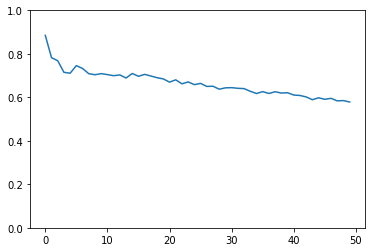

In [17]:
plt.plot(test_accuracies)
plt.ylim(ymin=0, ymax=1)
plt.show()

In [18]:
DB1_test_accuracies = test_accuracies
%store DB1_test_accuracies

Stored 'DB1_test_accuracies' (list)


In [ ]:
if use_tpu:
    sess.run(tpu.shutdown_system())

sess.close()

In [ ]:
import shelve
filename='code_state.bak'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()